# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


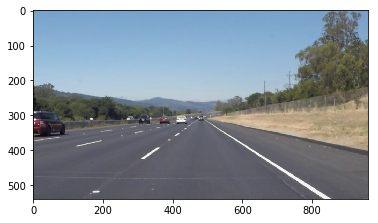

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


AssertionError: 

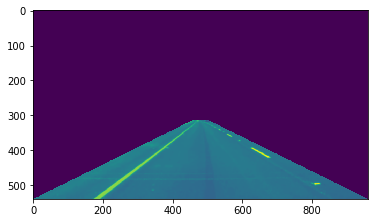

In [214]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def cvtline(px1, py1, px2, py2):
    A = (py1 - py2)
    B = (px2 - px1)
    C = (px1*py2 - px2*py1)
    return A, B, -C

def calcintersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


#reading in an image
image = mpimg.imread('test_images/test_error.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

grey = grayscale (image)
plt.imshow(grey, cmap='gray')

blurred = gaussian_blur(grey, 5)
cannied = canny(blurred, 50, 150)

#premasked = region_of_interest(blurred, vertices)
#plt.imshow(premasked)

print (imgx)
print (imgy)
imgx = image.shape[1]
imgy = image.shape[0]
vertices = np.array([[(0,imgy),(imgx*0.48, imgy*0.58), (imgx*0.52, imgy*0.58), (imgx,imgy)]], dtype=np.int32)

masked = region_of_interest(cannied, vertices)
plt.imshow(masked, cmap='gray')

rho=1
theta=np.pi/180
threshold=3
min_line_len=5
max_line_gap=2
lines = cv2.HoughLinesP(masked, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
houghlined = np.zeros((masked.shape[0], masked.shape[1], 3), dtype=np.uint8)
draw_lines(houghlined, lines)

houghedimg = weighted_img(image, houghlined)
plt.imshow(houghedimg)

leftpoints=[]
rightpoints=[]
leftmaxx=0
rightminx=imgx
for line in lines:
    for x1,y1,x2,y2 in line:
        xdist = x2-x1
        ydist = y2-y1
        slope = 0 if ydist==0 else xdist/ydist
        if (abs (slope) > 0.5 and abs(slope) < 2):
            if (slope < 0):
                leftpoints.append((x1, y1))
                leftpoints.append((x2, y2))
                if x1 > leftmaxx:
                    leftmaxx = x1
                if x2 > leftmaxx:
                    leftmaxx = x2
            else:
                rightpoints.append((x1, y1))
                rightpoints.append((x2, y2))
                if x1 < rightminx:
                    rightminx = x1
                if x2 < rightminx:
                    rightminx = x2
            
leftarray = np.array(leftpoints, dtype=np.int32)
rightarray = np.array(rightpoints, dtype=np.int32)
leftline = cv2.fitLine(leftarray, cv2.DIST_L2,0,0.01,0.01)
rightline = cv2.fitLine(rightarray, cv2.DIST_L2,0,0.01,0.01)
print (leftmaxx)
print (rightminx)
    
print (leftline)
print (rightline)

dx0=leftmaxx-leftline[2][0]
dy0=dx0*leftline[1][0]/leftline[0][0]
dy1=imgy-leftline[3][0]
dx1=dy1*leftline[0][0]/leftline[1][0]
leftresult = (int(leftline[2][0]+dx1), int(imgy), int(leftmaxx), int(leftline[3][0]+dy0))
print (leftresult)

dx2=rightline[2][0]-rightminx
dy2=dx2*rightline[1][0]/rightline[0][0]
dy3=imgy-rightline[3][0]
dx3=dy3*rightline[0][0]/rightline[1][0]
rightresult = (int(rightminx), int(rightline[3][0]-dy2),int(rightline[2][0]+dx3),int(imgy))
print (rightresult)


L1 = cvtline(*leftresult)
L2 = cvtline(*rightresult)

R = calcintersection(L1, L2)
if R:
    print ("Intersection detected:", R)
else:
    print ("No single intersection point detected")



interpolated = np.zeros((masked.shape[0], masked.shape[1], 3), dtype=np.uint8)
print (  ( [leftresult], [rightresult] ))
draw_lines(interpolated, ( [leftresult], [rightresult] ), thickness=5)

resultimg = weighted_img(image, interpolated, 0.9, 0.7)
plt.imshow(resultimg)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [110]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [257]:
intersectionpoint=None

#https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines
# line intersection calculation from rook at stack overflow

def cvtline(px1, py1, px2, py2):
    A = (py1 - py2)
    B = (px2 - px1)
    C = (px1*py2 - px2*py1)
    return A, B, -C

def calcintersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    
    grey = grayscale (image)

    blurred = gaussian_blur(grey, 5)
    cannied = canny(blurred, 50, 150)

    imgx = image.shape[1]
    imgy = image.shape[0]

    global intersectionpoint
    if intersectionpoint is None:
        intersectionpoint = (imgx*0.5, imgy*0.58)
    
    vertices = np.array([[(0,imgy),(intersectionpoint[0] - 30, intersectionpoint[1]+5), (intersectionpoint[0] + 30, intersectionpoint[1]+5), (imgx,imgy)]], dtype=np.int32)

    masked = region_of_interest(cannied, vertices)

    #return region_of_interest(image, vertices)
    
    rho=1
    theta=np.pi/180
    threshold=3
    min_line_len=5
    max_line_gap=2
    lines = cv2.HoughLinesP(masked, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#    houghlined = np.zeros((masked.shape[0], masked.shape[1], 3), dtype=np.uint8)
#    draw_lines(houghlined, lines)

#    houghedimg = weighted_img(image, houghlined)
#    return houghedimg
#    plt.imshow(houghedimg)

    leftpoints=[]
    rightpoints=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            xdist = x2-x1
            ydist = y2-y1
            slope = 0 if ydist==0 else xdist/ydist
            if (abs (slope) > 0.5 and abs(slope) < 2):
                if (slope < 0 and x1 < centerline + 5 and x2 < centerline + 5):
                    leftpoints.append((x1, y1))
                elif (slope > 0 and x1 > centerline - 5 and x2 > centerline - 5):
                    rightpoints.append((x1, y1))
                    rightpoints.append((x2, y2))
                elif (slope > 0):
                    print ("Thrown away", line)

    leftarray = np.array(leftpoints, dtype=np.int32)
    rightarray = np.array(rightpoints, dtype=np.int32)
    leftline = cv2.fitLine(leftarray, cv2.DIST_L2,0,0.01,0.01)
    rightline = cv2.fitLine(rightarray, cv2.DIST_L2,0,0.01,0.01)

    print (leftline)
    print (rightline)
    
    print (leftline[2][0], leftline[3][0], leftline[2][0]+leftline[0][0]*100, leftline[3][0]+leftline[1][0]*100)
    print (rightline[2][0], rightline[3][0], rightline[2][0]+rightline[0][0]*100, rightline[3][0]+rightline[1][0]*100)
    
    L1 = cvtline(leftline[2][0], leftline[3][0], leftline[2][0]+leftline[0][0]*100, leftline[3][0]+leftline[1][0]*100)
    L2 = cvtline(rightline[2][0], rightline[3][0], rightline[2][0]+rightline[0][0]*100, rightline[3][0]+rightline[1][0]*100)

    R = calcintersection(L1, L2)
    if R:
        print ("Intersection detected:", R)
        if (abs(R[0]-intersectionpoint[0]) > 30 or abs(R[1]-intersectionpoint[1]) > 30):
            print (R, intersectionpoint)
            plt.imshow(resultimg)
            mpimg.imsave("dbgcannied.png", cannied) 
            houghlined = np.zeros((masked.shape[0], masked.shape[1], 3), dtype=np.uint8)
            draw_lines(houghlined, lines)
            houghedimg = weighted_img(image, houghlined)
            mpimg.imsave("dbghoughed.png", houghedimg) 
            premasked = region_of_interest(blurred, vertices)
            mpimg.imsave("dbgpremasked.png", premasked) 
            
            
            mpimg.imsave("test_error.png", image) 
            assert(False)
        intersectionpoint = R
    else:
        print ("No single intersection point detected")
    

    dx0=intersectionpoint[0]-leftline[2][0]-10
    dy0=dx0*leftline[1][0]/leftline[0][0]
    dy1=imgy-leftline[3][0]
    dx1=dy1*leftline[0][0]/leftline[1][0]
    leftresult = (int(leftline[2][0]+dx1), int(imgy), int(leftmaxx), int(leftline[3][0]+dy0))
    print (leftresult)

    dx2=rightline[2][0]-intersectionpoint[0]-10
    dy2=dx2*rightline[1][0]/rightline[0][0]
    dy3=imgy-rightline[3][0]
    dx3=dy3*rightline[0][0]/rightline[1][0]
    rightresult = (int(rightminx), int(rightline[3][0]-dy2),int(rightline[2][0]+dx3),int(imgy))
    print (rightresult)

    interpolated = np.zeros((masked.shape[0], masked.shape[1], 3), dtype=np.uint8)
    print (  ( [leftresult], [rightresult] ))
    draw_lines(interpolated, ( [leftresult], [rightresult] ), thickness=5)

    resultimg = weighted_img(image, interpolated, 0.9, 0.7)

    


    
    
    return resultimg

Let's try the one with the solid white lane on the right first ...

In [258]:
white_output = 'test_videos_output/solidWhiteRighta.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Thrown away [[504 318 730 454]]
[[   0.80297494]
 [  -0.59601283]
 [ 315.8888855 ]
 [ 424.8888855 ]]
[[  8.54045391e-01]
 [  5.20198524e-01]
 [  7.01103455e+02]
 [  4.41982758e+02]]
315.889 424.889 396.186379433 365.287602425
701.103 441.983 786.507993698 494.002609968
Intersection detected: (476.86808838306513, 305.40113351546222)
(160, 540, 465, 312)
(489, 311, 862, 540)
([(160, 540, 465, 312)], [(489, 311, 862, 540)])
[MoviePy] >>>> Building video test_videos_output/solidWhiteRighta.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRighta.mp4


















  0%|          | 0/222 [00:00<?, ?it/s]















  2%|▏         | 4/222 [00:00<00:05, 38.66it/s]

Thrown away [[487 310 677 429]]
Thrown away [[497 314 532 334]]
Thrown away [[493 311 509 320]]
Thrown away [[491 313 511 326]]
Thrown away [[501 315 506 318]]
[[   0.80807132]
 [  -0.58908463]
 [ 334.55554199]
 [ 409.33334351]]
[[  8.43918920e-01]
 [  5.36470711e-01]
 [  7.16066650e+02]
 [  4.50233337e+02]]
334.556 409.333 415.362673521 350.424880981
716.067 450.233 800.458542347 503.880408525
Intersection detected: (482.29800121539074, 301.62897437716305)
(155, 540, 465, 308)
(489, 307, 857, 540)
([(155, 540, 465, 308)], [(489, 307, 857, 540)])
Thrown away [[494 312 759 472]]
Thrown away [[485 309 665 422]]
Thrown away [[490 309 551 346]]
Thrown away [[493 315 501 320]]
[[   0.80302888]
 [  -0.59594011]
 [ 314.38461304]
 [ 426.69232178]]
[[  8.49923909e-01]
 [  5.26905477e-01]
 [  7.20694458e+02]
 [  4.56138885e+02]]
314.385 426.692 394.687501192 367.098310471
720.694 456.139 805.686848879 508.829433203
Intersection detected: (477.69823605512892, 305.49476437566483)
(161, 540, 465, 3

















  3%|▎         | 7/222 [00:00<00:06, 34.20it/s]















  5%|▍         | 11/222 [00:00<00:05, 35.59it/s]

Thrown away [[493 310 632 396]]
Thrown away [[491 312 515 328]]
Thrown away [[486 309 493 314]]
[[   0.82076311]
 [  -0.57126868]
 [ 385.47058105]
 [ 371.58822632]]
[[  8.59410942e-01]
 [  5.11285484e-01]
 [  7.11788452e+02]
 [  4.46403839e+02]]
385.471 371.588 467.546892166 314.461358547
711.788 446.404 797.729546309 497.532387495
Intersection detected: (477.89824875423955, 307.25659299363286)
(143, 540, 465, 314)
(489, 313, 869, 540)
([(143, 540, 465, 314)], [(489, 313, 869, 540)])
[[   0.81656951]
 [  -0.57724714]
 [ 342.83334351]
 [ 401.75      ]]
[[  8.50166500e-01]
 [  5.26513934e-01]
 [  6.86933350e+02]
 [  4.33116669e+02]]
342.833 401.75 424.490294218 344.025285721
686.933 433.117 771.949999571 485.768062115
Intersection detected: (479.86660157673145, 304.87881389895813)
(147, 540, 465, 311)
(489, 311, 859, 540)
([(147, 540, 465, 311)], [(489, 311, 859, 540)])
Thrown away [[490 314 522 334]]
Thrown away [[491 312 579 365]]
Thrown away [[469 312 475 316]]
Thrown away [[501 317 5

















  7%|▋         | 15/222 [00:00<00:05, 36.57it/s]

[[  8.44336212e-01]
 [  5.35813749e-01]
 [  7.07282593e+02]
 [  4.53434784e+02]]
308.303 429.182 389.897912025 371.369395256
707.283 453.435 791.716213942 507.016158819
Intersection detected: (478.7548139789011, 308.4115998352874)
(151, 540, 465, 315)
(489, 314, 843, 540)
([(151, 540, 465, 315)], [(489, 314, 843, 540)])
Thrown away [[489 313 623 400]]
Thrown away [[504 320 520 329]]
[[   0.81320226]
 [  -0.58198118]
 [ 297.65383911]
 [ 436.42306519]]
[[  8.48391175e-01]
 [  5.29369831e-01]
 [  7.28583313e+02]
 [  4.63958344e+02]]
297.654 436.423 378.974065304 378.224946976
728.583 463.958 813.422430515 516.895326614
Intersection detected: (477.81587722509391, 307.48722619447466)
(152, 540, 465, 314)
(489, 313, 850, 540)
([(152, 540, 465, 314)], [(489, 313, 850, 540)])
Thrown away [[493 314 652 418]]
Thrown away [[495 312 697 439]]
Thrown away [[491 312 518 330]]
Thrown away [[497 313 521 328]]
[[   0.81191498]
 [  -0.58377576]
 [ 273.92001343]
 [ 452.11999512]]
[[  8.41140032e-01]
 [  

















  9%|▊         | 19/222 [00:00<00:05, 35.95it/s]

([(141, 540, 465, 309)], [(489, 309, 849, 540)])
Thrown away [[491 307 520 325]]
Thrown away [[496 314 570 361]]
Thrown away [[500 316 516 326]]
[[   0.81360728]
 [  -0.58141482]
 [ 345.        ]
 [ 398.        ]]
[[  8.34483445e-01]
 [  5.51033020e-01]
 [  7.11674988e+02]
 [  4.54250000e+02]]
345.0 398.0 426.360727549 339.858518124
711.675 454.25 795.123332262 509.353302002
Intersection detected: (480.18816194335477, 301.39270180647367)
(146, 540, 465, 308)
(489, 307, 841, 540)
([(146, 540, 465, 308)], [(489, 307, 841, 540)])
Thrown away [[496 311 762 478]]
Thrown away [[496 315 583 370]]
Thrown away [[497 311 513 321]]
[[   0.81774813]
 [  -0.57557625]
 [ 398.91665649]
 [ 359.5       ]]
[[  8.43163848e-01]
 [  5.37656665e-01]
 [  7.03382324e+02]
 [  4.47117645e+02]]
398.917 359.5 480.691469431 301.942375422
703.382 447.118 787.698709011 500.883311749
Intersection detected: (478.32628060669344, 303.60712579530332)
(142, 540, 465, 310)
(489, 309, 849, 540)
([(142, 540, 465, 310)], [(48

















 10%|▉         | 22/222 [00:00<00:07, 26.89it/s]

([(150, 540, 465, 314)], [(489, 313, 848, 540)])
Thrown away [[488 313 793 512]]
Thrown away [[499 317 536 340]]
Thrown away [[495 314 523 331]]
Thrown away [[498 319 524 336]]
[[   0.814578  ]
 [  -0.58005399]
 [ 372.73684692]
 [ 383.78945923]]
[[  8.37519348e-01]
 [  5.46407640e-01]
 [  7.24718750e+02]
 [  4.64000000e+02]]
372.737 383.789 454.194646597 325.784060717
724.719 464.0 808.470684767 518.640763998
Intersection detected: (482.24677357690899, 305.80838237629342)
(153, 540, 465, 312)
(489, 312, 841, 540)
([(153, 540, 465, 312)], [(489, 312, 841, 540)])
Thrown away [[486 311 532 341]]
Thrown away [[499 320 576 370]]
Thrown away [[497 315 516 326]]
Thrown away [[501 318 528 334]]
[[   0.81803703]
 [  -0.57516557]
 [ 336.17391968]
 [ 408.86956787]]
[[  8.47883105e-01]
 [  5.30183196e-01]
 [  6.91119995e+02]
 [  4.40540009e+02]]
336.174 408.87 417.977622986 351.353010893
691.12 440.54 775.908305645 493.558328152
Intersection detected: (479.41176886266618, 308.15838266895258)
(149,

















 12%|█▏        | 26/222 [00:00<00:06, 28.50it/s]

Thrown away [[498 318 728 468]]
Thrown away [[487 310 523 333]]
Thrown away [[498 314 515 324]]
[[   0.80931181]
 [  -0.58737928]
 [ 319.        ]
 [ 421.56668091]]
[[  8.35147321e-01]
 [  5.50026298e-01]
 [  6.47187500e+02]
 [  4.12312500e+02]]
319.0 421.567 399.931180716 362.828753233
647.188 412.312 730.702232122 467.315129757
Intersection detected: (481.81565691371748, 303.39894635102019)
(155, 540, 465, 310)
(489, 309, 841, 540)
([(155, 540, 465, 310)], [(489, 309, 841, 540)])


















 13%|█▎        | 29/222 [00:00<00:06, 28.74it/s]

Thrown away [[493 310 503 317]]
Thrown away [[500 316 855 538]]
Thrown away [[494 314 508 325]]
Thrown away [[499 315 507 320]]
Thrown away [[494 315 502 321]]
[[   0.81693673]
 [  -0.57672727]
 [ 293.72000122]
 [ 437.72000122]]
[[  8.37404668e-01]
 [  5.46583414e-01]
 [  7.33555542e+02]
 [  4.71611115e+02]]
293.72 437.72 375.413674355 380.047274113
733.556 471.611 817.296008825 526.26945591
Intersection detected: (480.07404773521563, 306.16090174804094)
(148, 540, 465, 313)
(489, 312, 838, 540)
([(148, 540, 465, 313)], [(489, 312, 838, 540)])
Thrown away [[499 319 515 328]]
Thrown away [[502 316 508 321]]
Thrown away [[498 313 503 318]]
[[   0.81807369]
 [  -0.57511342]
 [ 311.222229  ]
 [ 425.222229  ]]
[[  8.43192339e-01]
 [  5.37612081e-01]
 [  6.96891296e+02]
 [  4.43195648e+02]]
311.222 425.222 393.029597998 367.710887432
696.891 443.196 781.210530281 496.956856251
Intersection detected: (481.23991902544833, 305.69821100468943)
(147, 540, 465, 312)
(489, 312, 848, 540)
([(147, 54

















 15%|█▍        | 33/222 [00:01<00:06, 31.16it/s]

([(144, 540, 465, 311)], [(489, 310, 851, 540)])
Thrown away [[497 316 510 325]]
[[   0.81175578]
 [  -0.58399707]
 [ 361.277771  ]
 [ 390.6111145 ]]
[[  8.38580191e-01]
 [  5.44778228e-01]
 [  6.72478271e+02]
 [  4.29043488e+02]]
361.278 390.611 442.453348637 332.211407423
672.478 429.043 756.336290598 483.521310329
Intersection detected: (480.87519861151065, 304.56978356048052)
(153, 540, 465, 311)
(489, 311, 843, 540)
([(153, 540, 465, 311)], [(489, 311, 843, 540)])


















 17%|█▋        | 37/222 [00:01<00:05, 32.64it/s]

Thrown away [[498 318 542 346]]
[[   0.81812698]
 [  -0.57503766]
 [ 328.52941895]
 [ 413.11764526]]
[[  8.39204073e-01]
 [  5.43816626e-01]
 [  6.54500000e+02]
 [  4.17727264e+02]]
328.529 413.118 410.342116594 355.613879442
654.5 417.727 738.420407295 472.108927011
Intersection detected: (481.48398220097914, 305.6103311238557)
(148, 540, 465, 312)
(489, 312, 843, 540)
([(148, 540, 465, 312)], [(489, 312, 843, 540)])
Thrown away [[485 310 553 354]]
Thrown away [[501 317 543 343]]
Thrown away [[500 316 528 333]]
[[   0.8116914 ]
 [  -0.58408654]
 [ 365.66665649]
 [ 387.222229  ]]
[[  8.43167424e-01]
 [  5.37651122e-01]
 [  7.05450012e+02]
 [  4.51100006e+02]]
365.667 387.222 446.835796833 328.813575268
705.45 451.1 789.766754627 504.865118265
Intersection detected: (478.23799806261587, 306.21680646486755)
(153, 540, 465, 313)
(489, 312, 844, 540)
([(153, 540, 465, 313)], [(489, 312, 844, 540)])
Thrown away [[494 311 591 376]]
Thrown away [[488 311 520 333]]
Thrown away [[493 311 521 33

Thrown away [[489 310 527 336]]
Thrown away [[501 315 508 319]]
Thrown away [[501 319 510 325]]
[[   0.81013787]
 [  -0.5862394 ]
 [ 331.36364746]
 [ 412.13635254]]
[[  8.37198794e-01]
 [  5.46898663e-01]
 [  6.19562500e+02]
 [  3.94656250e+02]]
331.364 412.136 412.377434254 353.512412786
619.562 394.656 703.282379389 449.346116304
Intersection detected: (480.7927087834338, 304.0051240771212)
(154, 540, 465, 311)
(489, 310, 842, 540)
([(154, 540, 465, 311)], [(489, 310, 842, 540)])
Thrown away [[488 309 497 314]]
[[   0.8157227 ]
 [  -0.57844317]
 [ 353.57144165]
 [ 393.85714722]]
[[  8.39938760e-01]
 [  5.42681158e-01]
 [  6.72347839e+02]
 [  4.28282623e+02]]
353.571 393.857 435.143712044 336.012830257
672.348 428.283 756.341715336 482.55073905
Intersection detected: (480.14538027217947, 304.10136392023514)
(147, 540, 465, 311)
(489, 310, 845, 540)
([(147, 540, 465, 311)], [(489, 310, 845, 540)])


 18%|█▊        | 41/222 [00:01<00:05, 30.59it/s]

Thrown away [[488 309 538 341]]
Thrown away [[495 310 553 347]]
Thrown away [[470 309 475 312]]
[[   0.80732453]
 [  -0.59010768]
 [ 395.63635254]
 [ 364.54544067]]
[[  8.42656970e-01]
 [  5.38450778e-01]
 [  6.88804321e+02]
 [  4.38760864e+02]]
395.636 364.545 476.368805408 305.534672737
688.804 438.761 773.070018291 492.605942011
Intersection detected: (478.20709234606068, 304.1909909831403)
(155, 540, 465, 311)
(489, 310, 847, 540)
([(155, 540, 465, 311)], [(489, 310, 847, 540)])
Thrown away [[488 309 747 483]]
Thrown away [[493 309 556 349]]
Thrown away [[502 319 514 327]]
Thrown away [[499 312 508 318]]
[[   0.82047039]
 [  -0.57168907]
 [ 377.21429443]
 [ 377.35714722]]
[[  8.29677582e-01]
 [  5.58242857e-01]
 [  7.12950012e+02]
 [  4.55350006e+02]]
377.214 377.357 459.261333704 320.18824029
712.95 455.35 795.917770386 511.174291849
Intersection detected: (485.20340702448289, 302.11226840400627)
(143, 540, 465, 309)
(489, 308, 838, 540)
([(143, 540, 465, 309)], [(489, 308, 838, 5

















 20%|██        | 45/222 [00:01<00:07, 22.73it/s]

[[488 309 512 326]]
[[   0.82189602]
 [  -0.56963754]
 [ 381.5       ]
 [ 374.5       ]]
[[  8.40708375e-01]
 [  5.41488171e-01]
 [  7.17785706e+02]
 [  4.57214294e+02]]
381.5 374.5 463.68960166 317.5362463
717.786 457.214 801.856543064 511.363111496
Intersection detected: (481.62428673314253, 305.10612177571903)
(142, 540, 465, 312)
(489, 311, 846, 540)
([(142, 540, 465, 312)], [(489, 311, 846, 540)])
Thrown away [[502 319 509 323]]
[[   0.80753005]
 [  -0.58982646]
 [ 367.38461304]
 [ 383.23077393]]
[[  8.31502378e-01]
 [  5.55521190e-01]
 [  6.73125000e+02]
 [  4.29750000e+02]]
367.385 383.231 448.137617588 324.24812746
673.125 429.75 756.275237799 485.302119017
Intersection detected: (480.17955641740764, 300.84443665609399)
(152, 540, 465, 308)
(489, 307, 838, 540)
([(152, 540, 465, 308)], [(489, 307, 838, 540)])
Thrown away [[493 309 552 346]]
Thrown away [[495 313 525 334]]
Thrown away [[498 316 514 327]]
Thrown away [[502 315 528 332]]
[[   0.80973476]
 [  -0.58679605]
 [ 364.95

















 22%|██▏       | 48/222 [00:01<00:10, 16.48it/s]

Thrown away [[501 315 609 383]]
Thrown away [[481 305 538 343]]
Thrown away [[494 310 556 349]]
Thrown away [[504 321 516 329]]
[[   0.81787091]
 [  -0.57540178]
 [ 337.65383911]
 [ 405.80767822]]
[[  8.41305733e-01]
 [  5.40559590e-01]
 [  6.81611084e+02]
 [  4.34944458e+02]]
337.654 405.808 419.440930605 348.267499924
681.611 434.944 765.741657257 489.000416994
Intersection detected: (480.19138579851005, 305.52735646409928)
(146, 540, 465, 312)
(489, 311, 845, 540)
([(146, 540, 465, 312)], [(489, 311, 845, 540)])
Thrown away [[493 313 589 377]]
Thrown away [[497 316 508 324]]
[[   0.81324869]
 [  -0.58191633]
 [ 321.83999634]
 [ 414.92001343]]
[[  8.36609185e-01]
 [  5.47800183e-01]
 [  6.96500000e+02]
 [  4.45200012e+02]]
321.84 414.92 403.164865732 356.728380203
696.5 445.2 780.160918474 499.980030537
Intersection detected: (478.76713425779718, 302.63152749696559)
(147, 540, 465, 309)
(489, 309, 841, 540)
([(147, 540, 465, 309)], [(489, 309, 841, 540)])
Thrown away [[493 313 584 37

















 23%|██▎       | 51/222 [00:02<00:09, 17.14it/s]















 24%|██▍       | 54/222 [00:02<00:09, 18.25it/s]

Thrown away [[482 307 654 419]]
Thrown away [[492 309 608 384]]
Thrown away [[488 310 597 381]]
Thrown away [[494 311 531 335]]
[[   0.81591451]
 [  -0.57817256]
 [ 312.03845215]
 [ 421.19232178]]
[[  8.41214955e-01]
 [  5.40700853e-01]
 [  7.52285706e+02]
 [  4.80107147e+02]]
312.038 421.192 393.629903316 363.375065327
752.286 480.107 836.407201052 534.177232504
Intersection detected: (477.83871238774685, 303.70309921043673)
(144, 540, 465, 310)
(489, 310, 845, 540)
([(144, 540, 465, 310)], [(489, 310, 845, 540)])
Thrown away [[503 317 689 434]]
Thrown away [[504 317 536 337]]
[[   0.81754827]
 [  -0.57586008]
 [ 261.        ]
 [ 455.76922607]]
[[  8.44424486e-01]
 [  5.35674572e-01]
 [  6.40781250e+02]
 [  4.07312500e+02]]
261.0 455.769 342.754827499 398.183217764
640.781 407.312 725.223698616 460.879957199
Intersection detected: (477.1562553932842, 303.51429140998977)
(141, 540, 465, 310)
(489, 309, 849, 540)
([(141, 540, 465, 310)], [(489, 309, 849, 540)])
Thrown away [[493 310 537

















 26%|██▌       | 57/222 [00:02<00:08, 18.64it/s]















 27%|██▋       | 60/222 [00:02<00:07, 20.43it/s]

Thrown away [[504 324 541 348]]
Thrown away [[492 312 514 326]]
Thrown away [[499 317 552 350]]
[[   0.82383519]
 [  -0.56682944]
 [ 377.11764526]
 [ 376.        ]]
[[  8.35639238e-01]
 [  5.49278677e-01]
 [  6.79000000e+02]
 [  4.37142853e+02]]
377.118 376.0 459.501164675 319.317055702
679.0 437.143 762.563923836 492.070720434
Intersection detected: (479.16455692706887, 305.78790599228228)
(138, 540, 465, 312)
(489, 312, 835, 540)
([(138, 540, 465, 312)], [(489, 312, 835, 540)])
Thrown away [[502 319 511 325]]
[[   0.81783086]
 [  -0.57545865]
 [ 334.71429443]
 [ 405.92855835]]
[[  8.42129767e-01]
 [  5.39274931e-01]
 [  6.71060608e+02]
 [  4.29909088e+02]]
334.714 405.929 416.497380495 348.382693768
671.061 429.909 755.273584604 483.83658123
Intersection detected: (477.12811726792552, 305.72047183551496)
(144, 540, 465, 312)
(489, 312, 842, 540)
([(144, 540, 465, 312)], [(489, 312, 842, 540)])
Thrown away [[484 311 541 349]]
[[   0.82427883]
 [  -0.5661841 ]
 [ 350.05883789]
 [ 394.7

















 28%|██▊       | 63/222 [00:02<00:07, 21.98it/s]















 30%|██▉       | 66/222 [00:02<00:06, 23.40it/s]

Thrown away [[492 313 616 393]]
Thrown away [[481 310 516 332]]
Thrown away [[503 319 509 323]]
[[   0.82166201]
 [  -0.56997502]
 [ 288.78262329]
 [ 437.82608032]]
[[  8.35835159e-01]
 [  5.48980474e-01]
 [  6.86562500e+02]
 [  4.42500000e+02]]
288.783 437.826 370.948824167 380.828578472
686.562 442.5 770.146015882 497.398047447
Intersection detected: (478.78013455690615, 306.02756238653609)
(141, 540, 465, 312)
(489, 312, 835, 540)
([(141, 540, 465, 312)], [(489, 312, 835, 540)])
Thrown away [[483 311 510 328]]
Thrown away [[491 312 560 358]]
[[   0.82392138]
 [  -0.56670409]
 [ 248.62069702]
 [ 465.44827271]]
[[  8.34201515e-01]
 [  5.51459730e-01]
 [  6.77722229e+02]
 [  4.37074066e+02]]
248.621 465.448 331.012835264 408.777863264
677.722 437.074 761.142380476 492.220039129
Intersection detected: (479.95202348195409, 306.33550701348975)
(140, 540, 465, 313)
(489, 312, 833, 540)
([(140, 540, 465, 313)], [(489, 312, 833, 540)])
[[   0.82278961]
 [  -0.56834602]
 [ 288.15789795]
 [ 43

















 31%|███       | 69/222 [00:02<00:06, 24.63it/s]















 32%|███▏      | 72/222 [00:02<00:05, 25.17it/s]

[[   0.83522028]
 [  -0.54991555]
 [ 375.8125    ]
 [ 374.0625    ]]
[[  8.33782375e-01]
 [  5.52093208e-01]
 [  6.71032288e+02]
 [  4.31548401e+02]]
375.812 374.062 459.334527731 319.070944786
671.032 431.548 754.410525084 486.757721663
Intersection detected: (480.30988985309432, 305.26060258523006)
(123, 540, 465, 311)
(489, 311, 834, 540)
([(123, 540, 465, 311)], [(489, 311, 834, 540)])
Thrown away [[498 319 560 360]]
Thrown away [[498 315 504 319]]
[[   0.83594775]
 [  -0.54880905]
 [ 361.14285278]
 [ 384.14285278]]
[[  8.37204456e-01]
 [  5.46890080e-01]
 [  6.72107117e+02]
 [  4.33250000e+02]]
361.143 384.143 444.737627983 329.261947632
672.107 433.25 755.827562332 487.939007998
Intersection detected: (478.74221992402119, 306.93755258969867)
(123, 540, 465, 313)
(489, 313, 835, 540)
([(123, 540, 465, 313)], [(489, 313, 835, 540)])
Thrown away [[491 311 733 468]]
Thrown away [[485 311 519 333]]
Thrown away [[498 315 512 324]]
[[   0.83385152]
 [  -0.55198884]
 [ 366.53845215]
 [ 3

















 34%|███▍      | 75/222 [00:02<00:05, 26.28it/s]















 35%|███▌      | 78/222 [00:03<00:05, 27.28it/s]

Thrown away [[484 310 745 486]]
Thrown away [[488 310 519 329]]
Thrown away [[495 313 511 323]]
[[   0.82704544]
 [  -0.56213504]
 [ 302.46154785]
 [ 424.73077393]]
[[  8.32940400e-01]
 [  5.53362668e-01]
 [  7.14384644e+02]
 [  4.61423065e+02]]
302.462 424.731 385.166091919 368.51726985
714.385 461.423 797.678683519 516.759331942
Intersection detected: (478.77203070489355, 304.89418987493349)
(132, 540, 465, 311)
(489, 311, 832, 540)
([(132, 540, 465, 311)], [(489, 311, 832, 540)])
Thrown away [[491 312 747 478]]
Thrown away [[482 310 534 344]]
Thrown away [[501 317 509 322]]
[[   0.83391839]
 [  -0.55188781]
 [ 278.2666626 ]
 [ 438.70001221]]
[[  8.39729548e-01]
 [  5.43004870e-01]
 [  7.07076904e+02]
 [  4.54769226e+02]]
278.267 438.7 361.658501863 383.511231184
707.077 454.769 791.049859047 509.069713116
Intersection detected: (477.90675402470112, 306.57805175880458)
(125, 540, 465, 313)
(489, 313, 838, 540)
([(125, 540, 465, 313)], [(489, 313, 838, 540)])
Thrown away [[491 314 513

















 36%|███▋      | 81/222 [00:03<00:05, 27.45it/s]

















[[   0.8296175 ]
 [  -0.5583322 ]
 [ 382.6000061 ]
 [ 368.66665649]]
[[  8.30747724e-01]
 [  5.56649148e-01]
 [  6.68656250e+02]
 [  4.34968750e+02]]
382.6 368.667 465.561756134 312.833436012
668.656 434.969 751.731022358 490.633664846
Intersection detected: (475.9483357165895, 305.84327262164447)
(128, 540, 465, 312)
(489, 312, 825, 540)
([(128, 540, 465, 312)], [(489, 312, 825, 540)])
Thrown away [[490 310 495 314]]
[[   0.83185631]
 [  -0.55499113]
 [ 381.5       ]
 [ 369.14285278]]
[[  8.35351884e-01]
 [  5.49715579e-01]
 [  6.65258606e+02]
 [  4.29844818e+02]]
381.5 369.143 464.685631037 313.643740177
665.259 429.845 748.793794394 484.816375971
Intersection detected: (476.59966593406847, 305.69503129417416)
(125, 540, 465, 312)
(489, 312, 832, 540)
([(125, 540, 465, 312)], [(489, 312, 832, 540)])
Thrown away [[484 310 499 320]]
Thrown away [[490 310 509 323]]
Thrown away [[498 318 503 322]]
[[   0.83395326]
 [  -0.55183512]
 [ 377.38461304]
 [ 370.92306519]]
[[  8.27396512e-01]
 [

 38%|███▊      | 84/222 [00:03<00:05, 26.37it/s]















 39%|███▉      | 87/222 [00:03<00:05, 26.65it/s]

















Thrown away [[490 313 811 538]]
Thrown away [[500 317 525 333]]
Thrown away [[492 314 520 333]]
Thrown away [[491 311 513 324]]
[[   0.83618218]
 [  -0.54845184]
 [ 328.63635254]
 [ 403.13635254]]
[[  8.31804454e-01]
 [  5.55068731e-01]
 [  7.23000000e+02]
 [  4.66791656e+02]]
328.636 403.136 412.254570246 348.291168451
723.0 466.792 806.180445433 522.298529625
Intersection detected: (479.41115023622916, 304.2431715757682)
(119, 540, 465, 310)
(489, 310, 832, 540)
([(119, 540, 465, 310)], [(489, 310, 832, 540)])
Thrown away [[490 313 565 366]]
Thrown away [[493 312 529 336]]
[[   0.83734685]
 [  -0.54667199]
 [ 277.46875   ]
 [ 436.75      ]]
[[  8.24561298e-01]
 [  5.65772653e-01]
 [  6.66385742e+02]
 [  4.33357147e+02]]
277.469 436.75 361.203435183 382.082801342
666.386 433.357 748.841871977 489.934412479
Intersection detected: (479.29533351682045, 304.98508189562278)
(119, 540, 465, 311)
(489, 311, 821, 540)
([(119, 540, 465, 311)], [(489, 311, 821, 540)])
Thrown away [[493 311 615 

 41%|████      | 90/222 [00:03<00:05, 25.64it/s]















 42%|████▏     | 93/222 [00:03<00:05, 25.58it/s]

















[[   0.84028214]
 [  -0.54214931]
 [ 383.63635254]
 [ 369.7272644 ]]
[[  8.22751701e-01]
 [  5.68400919e-01]
 [  6.68065796e+02]
 [  4.35315796e+02]]
383.636 369.727 467.664566755 315.51233387
668.066 435.316 750.340965986 492.155887842
Intersection detected: (481.6194322417175, 306.50866682762478)
(119, 540, 465, 312)
(489, 313, 819, 540)
([(119, 540, 465, 312)], [(489, 313, 819, 540)])
Thrown away [[503 317 511 324]]
Thrown away [[495 313 504 319]]
[[   0.83817738]
 [  -0.5453977 ]
 [ 383.76470947]
 [ 370.23529053]]
[[  8.28691363e-01]
 [  5.59705794e-01]
 [  6.41928589e+02]
 [  4.15642853e+02]]
383.765 370.235 467.582447767 315.695520639
641.929 415.643 724.797725201 471.613432169
Intersection detected: (481.01100199495141, 306.95762968211704)
(122, 540, 465, 313)
(489, 313, 826, 540)
([(122, 540, 465, 313)], [(489, 313, 826, 540)])
Thrown away [[502 321 536 344]]
Thrown away [[492 311 537 340]]
[[   0.83428448]
 [  -0.5513342 ]
 [ 370.1875    ]
 [ 378.8125    ]]
[[  8.13122988e-01]

 43%|████▎     | 96/222 [00:03<00:05, 24.91it/s]















 45%|████▍     | 99/222 [00:03<00:04, 25.85it/s]















 46%|████▌     | 102/222 [00:04<00:04, 26.59it/s]

Thrown away [[502 318 514 325]]
Thrown away [[488 310 495 314]]
Thrown away [[489 307 502 314]]
[[   0.83642763]
 [  -0.54807734]
 [ 276.47619629]
 [ 440.        ]]
[[  8.18686604e-01]
 [  5.74240565e-01]
 [  6.83846130e+02]
 [  4.44019226e+02]]
276.476 440.0 360.118959188 385.192265511
683.846 444.019 765.714790821 501.443282604
Intersection detected: (484.1284178915555, 303.93386070447724)
(123, 540, 465, 310)
(489, 310, 820, 540)
([(123, 540, 465, 310)], [(489, 310, 820, 540)])
Thrown away [[487 308 545 346]]
Thrown away [[494 308 541 339]]
Thrown away [[497 311 533 334]]
[[   0.83334118]
 [  -0.55275893]
 [ 273.70968628]
 [ 443.06451416]]
[[  8.16491783e-01]
 [  5.77357054e-01]
 [  6.71062500e+02]
 [  4.34291656e+02]]
273.71 443.065 357.043804407 387.788620949
671.062 434.292 752.711678267 492.02736187
Intersection detected: (485.13968120348414, 302.8220530449791)
(127, 540, 465, 309)
(489, 309, 820, 540)
([(127, 540, 465, 309)], [(489, 309, 820, 540)])
Thrown away [[498 311 560 35

















 47%|████▋     | 105/222 [00:04<00:04, 26.74it/s]

















Thrown away [[496 315 571 366]]
Thrown away [[500 317 555 354]]
[[   0.83072305]
 [  -0.55668598]
 [ 398.38461304]
 [ 361.92306519]]
[[  8.22801292e-01]
 [  5.68329096e-01]
 [  6.98630432e+02]
 [  4.52260864e+02]]
398.385 361.923 481.456917763 306.254466772
698.63 452.261 780.910561323 509.093773842
Intersection detected: (484.39677251253158, 304.28440473997807)
(132, 540, 465, 310)
(489, 311, 825, 540)
([(132, 540, 465, 310)], [(489, 311, 825, 540)])
Thrown away [[499 317 629 408]]
Thrown away [[503 316 592 376]]
Thrown away [[496 316 502 320]]
Thrown away [[499 314 523 330]]
[[   0.83288151]
 [  -0.5534513 ]
 [ 367.21429443]
 [ 383.57144165]]
[[  8.26510847e-01]
 [  5.62920809e-01]
 [  7.11291687e+02]
 [  4.59583344e+02]]
367.214 383.571 450.502445459 328.226311684
711.292 459.583 793.942771673 515.875424385
Intersection detected: (484.88275798674624, 305.3805306008681)
(131, 540, 465, 312)
(489, 312, 829, 540)
([(131, 540, 465, 312)], [(489, 312, 829, 540)])
Thrown away [[497 312 81

 49%|████▊     | 108/222 [00:04<00:04, 26.27it/s]















 50%|█████     | 112/222 [00:04<00:03, 27.98it/s]

















Thrown away [[497 311 541 340]]
Thrown away [[504 319 515 327]]
Thrown away [[499 316 506 321]]
[[   0.82697076]
 [  -0.56224495]
 [ 346.125     ]
 [ 396.9375    ]]
[[  8.30282867e-01]
 [  5.57342231e-01]
 [  6.94000000e+02]
 [  4.44642853e+02]]
346.125 396.938 428.822075605 340.713004827
694.0 444.643 777.028286695 500.377075911
Intersection detected: (483.64605828044159, 303.43900539420429)
(135, 540, 465, 310)
(489, 310, 836, 540)
([(135, 540, 465, 310)], [(489, 310, 836, 540)])
[[   0.82313848]
 [  -0.56784064]
 [ 292.32000732]
 [ 434.79998779]]
[[  8.28560114e-01]
 [  5.59900105e-01]
 [  6.72648132e+02]
 [  4.33055542e+02]]
292.32 434.8 374.633854866 378.015924215
672.648 433.056 755.504143715 489.045552492
Intersection detected: (481.79836712125513, 304.08867310391588)
(139, 540, 465, 310)
(489, 310, 830, 540)
([(139, 540, 465, 310)], [(489, 310, 830, 540)])
Thrown away [[496 315 564 359]]
Thrown away [[502 315 558 352]]
Thrown away [[494 314 506 322]]
Thrown away [[504 317 512 3

 52%|█████▏    | 115/222 [00:04<00:03, 28.50it/s]















 53%|█████▎    | 118/222 [00:04<00:03, 27.05it/s]

Thrown away [[500 313 740 469]]
Thrown away [[497 315 600 382]]
[[   0.8303777 ]
 [  -0.55720091]
 [ 380.5       ]
 [ 373.71429443]]
[[  8.28559279e-01]
 [  5.59901357e-01]
 [  6.91785706e+02]
 [  4.42892853e+02]]
380.5 373.714 463.537769794 317.994203568
691.786 442.893 774.641633511 498.882988453
Intersection detected: (485.32357924125517, 303.37546699773458)
(132, 540, 465, 310)
(489, 310, 835, 540)
([(132, 540, 465, 310)], [(489, 310, 835, 540)])
Thrown away [[487 309 610 389]]
Thrown away [[490 308 605 380]]
[[   0.83116436]
 [  -0.55602682]
 [ 383.277771  ]
 [ 371.55554199]]
[[  8.26794505e-01]
 [  5.62504053e-01]
 [  6.96615356e+02]
 [  4.45923065e+02]]
383.278 371.556 466.394207001 315.952860355
696.615 445.923 779.294806957 502.173470497
Intersection detected: (486.15176281382094, 302.73558181692607)
(131, 540, 465, 309)
(489, 309, 834, 540)
([(131, 540, 465, 309)], [(489, 309, 834, 540)])
Thrown away [[494 314 510 324]]
Thrown away [[489 307 515 322]]
Thrown away [[504 319 50

















 55%|█████▍    | 122/222 [00:04<00:03, 27.26it/s]















 56%|█████▋    | 125/222 [00:04<00:03, 27.29it/s]


Intersection detected: (483.32708423802274, 307.23545586823656)
(141, 540, 465, 314)
(489, 313, 848, 540)
([(141, 540, 465, 314)], [(489, 313, 848, 540)])
Thrown away [[494 312 655 413]]
Thrown away [[487 312 567 362]]
Thrown away [[501 316 541 341]]
Thrown away [[474 314 479 317]]
[[   0.82747084]
 [  -0.56150872]
 [ 310.57894897]
 [ 424.        ]]
[[  8.45568299e-01]
 [  5.33867240e-01]
 [  7.10160706e+02]
 [  4.52571442e+02]]
310.579 424.0 393.326032877 367.849128485
710.161 452.571 794.717535496 505.958165646
Intersection detected: (481.35796382211396, 308.11204276971597)
(139, 540, 465, 314)
(489, 314, 848, 540)
([(139, 540, 465, 314)], [(489, 314, 848, 540)])
Thrown away [[499 315 591 374]]
[[   0.83128852]
 [  -0.55584121]
 [ 266.65383911]
 [ 453.11538696]]
[[  8.45930159e-01]
 [  5.33293724e-01]
 [  6.73099976e+02]
 [  4.28333344e+02]]
266.654 453.115 349.782690763 397.531266212
673.1 428.333 757.692991495 481.662715912
Intersection detected: (482.97345776488294, 308.473237276

















 58%|█████▊    | 128/222 [00:04<00:03, 26.86it/s]















 59%|█████▉    | 131/222 [00:05<00:03, 25.80it/s]

Thrown away [[501 318 613 391]]
Thrown away [[495 312 540 339]]
Thrown away [[500 318 541 345]]
[[   0.82257545]
 [  -0.56865597]
 [ 393.05883789]
 [ 369.35293579]]
[[  8.38551283e-01]
 [  5.44822633e-01]
 [  6.77590881e+02]
 [  4.31227264e+02]]
393.059 369.353 475.316382885 312.48733902
677.591 431.227 761.446009636 485.709527731
Intersection detected: (484.77302296243118, 305.94985383842192)
(146, 540, 465, 312)
(489, 312, 845, 540)
([(146, 540, 465, 312)], [(489, 312, 845, 540)])
Thrown away [[502 319 574 367]]
[[   0.83044457]
 [  -0.55710125]
 [ 371.75      ]
 [ 385.375     ]]
[[  8.41234326e-01]
 [  5.40670693e-01]
 [  6.88266663e+02]
 [  4.36649994e+02]]
371.75 385.375 454.794457436 329.664875031
688.267 436.65 772.390095234 490.717063189
Intersection detected: (487.58331679552794, 307.66856716175562)
(141, 540, 465, 314)
(489, 314, 849, 540)
([(141, 540, 465, 314)], [(489, 314, 849, 540)])
Thrown away [[503 320 580 370]]
Thrown away [[494 313 523 328]]
Thrown away [[499 318 508

















 60%|██████    | 134/222 [00:05<00:03, 25.11it/s]















 62%|██████▏   | 137/222 [00:05<00:03, 25.75it/s]

[[   0.81584322]
 [  -0.57827318]
 [ 322.75860596]
 [ 420.55172729]]
[[  8.46675932e-01]
 [  5.32108903e-01]
 [  6.93000000e+02]
 [  4.39282623e+02]]
322.759 420.552 404.34292841 362.72440958
693.0 439.283 777.667593241 492.493513584
Intersection detected: (482.75146386419743, 307.14810331237709)
(154, 540, 465, 314)
(489, 313, 853, 540)
([(154, 540, 465, 314)], [(489, 313, 853, 540)])
Thrown away [[491 313 570 362]]
Thrown away [[499 317 544 345]]
[[   0.81613958]
 [  -0.57785481]
 [ 311.        ]
 [ 427.89654541]]
[[  8.41586053e-01]
 [  5.40123045e-01]
 [  6.88047607e+02]
 [  4.37261902e+02]]
311.0 427.897 392.613957882 370.111064196
688.048 437.262 772.206212759 491.2742064
Intersection detected: (483.33383702150877, 305.87827843381251)
(152, 540, 465, 312)
(489, 312, 848, 540)
([(152, 540, 465, 312)], [(489, 312, 848, 540)])
Thrown away [[500 316 744 475]]
Thrown away [[495 310 549 343]]
Thrown away [[504 315 519 324]]
Thrown away [[497 315 502 318]]
[[   0.81386828]
 [  -0.581049

















 63%|██████▎   | 140/222 [00:05<00:03, 26.07it/s]















 64%|██████▍   | 143/222 [00:05<00:03, 26.03it/s]

Thrown away [[503 315 777 486]]
Thrown away [[451 310 458 314]]
[[   0.82067251]
 [  -0.57139885]
 [ 400.21429443]
 [ 363.71429443]]
[[  8.50718498e-01]
 [  5.25621593e-01]
 [  7.01033325e+02]
 [  4.41799988e+02]]
400.214 363.714 482.281545639 306.574409008
701.033 441.8 786.105175018 494.362147093
Intersection detected: (482.22944762332986, 306.61068260808878)
(147, 540, 465, 313)
(489, 312, 859, 540)
([(147, 540, 465, 313)], [(489, 312, 859, 540)])
Thrown away [[501 318 661 422]]
Thrown away [[498 317 517 329]]
[[   0.82929158]
 [  -0.55881613]
 [ 397.53845215]
 [ 368.23077393]]
[[  8.46111834e-01]
 [  5.33005416e-01]
 [  7.15775879e+02]
 [  4.53844818e+02]]
397.538 368.231 480.467610359 312.349160433
715.776 453.845 800.387062311 507.145359755
Intersection detected: (485.63408913934245, 308.86774115229827)
(142, 540, 465, 315)
(489, 315, 852, 540)
([(142, 540, 465, 315)], [(489, 315, 852, 540)])
Thrown away [[501 319 715 458]]
Thrown away [[495 313 541 339]]
Thrown away [[502 316 51

















 66%|██████▌   | 146/222 [00:05<00:03, 25.26it/s]















 67%|██████▋   | 149/222 [00:05<00:02, 25.83it/s]

[[500 319 556 353]]
Thrown away [[494 316 502 321]]
[[   0.81759048]
 [  -0.57580012]
 [ 357.05264282]
 [ 397.3684082 ]]
[[  8.41471076e-01]
 [  5.40302217e-01]
 [  7.11400024e+02]
 [  4.51600006e+02]]
357.053 397.368 438.811690331 339.78839612
711.4 451.6 795.547132015 505.630227804
Intersection detected: (485.76453535796895, 306.72116421839564)
(154, 540, 465, 313)
(489, 313, 849, 540)
([(154, 540, 465, 313)], [(489, 313, 849, 540)])
[[   0.81082797]
 [  -0.58528459]
 [ 347.60870361]
 [ 406.82608032]]
[[  8.43062162e-01]
 [  5.37816107e-01]
 [  6.75420471e+02]
 [  4.28193176e+02]]
347.609 406.826 428.691500664 348.29762125
675.42 428.193 759.726687431 481.974786997
Intersection detected: (485.68704417644557, 307.15620214372291)
(163, 540, 465, 314)
(489, 313, 850, 540)
([(163, 540, 465, 314)], [(489, 313, 850, 540)])
Thrown away [[500 315 562 351]]
Thrown away [[502 319 518 330]]
[[   0.80976868]
 [  -0.58674926]
 [ 294.25      ]
 [ 442.66665649]]
[[  8.48987460e-01]
 [  5.28412938e-

















 68%|██████▊   | 152/222 [00:05<00:02, 26.41it/s]















 70%|██████▉   | 155/222 [00:06<00:02, 26.70it/s]

Thrown away [[500 313 521 325]]
[[   0.81734324]
 [  -0.57615101]
 [ 400.09091187]
 [ 366.        ]]
[[  8.52291226e-01]
 [  5.23067594e-01]
 [  6.93099976e+02]
 [  4.32679993e+02]]
400.091 366.0 481.825235367 308.384898663
693.1 432.68 778.329098225 484.986752033
Intersection detected: (485.89636301359258, 305.5151320592895)
(153, 540, 465, 312)
(489, 311, 867, 540)
([(153, 540, 465, 312)], [(489, 311, 867, 540)])
Thrown away [[491 313 521 329]]
[[   0.80861092]
 [  -0.58834374]
 [ 399.25      ]
 [ 368.25      ]]
[[  8.43204677e-01]
 [  5.37592649e-01]
 [  6.67875000e+02]
 [  4.20458344e+02]]
399.25 368.25 480.111091614 309.415626049
667.875 420.458 752.19546771 474.217608452
Intersection detected: (486.46042308227049, 304.79586474603246)
(163, 540, 465, 312)
(489, 311, 855, 540)
([(163, 540, 465, 312)], [(489, 311, 855, 540)])
[[   0.8065083 ]
 [  -0.59122276]
 [ 383.21054077]
 [ 380.15789795]]
[[  8.52676690e-01]
 [  5.22438943e-01]
 [  6.88666687e+02]
 [  4.31095245e+02]]
383.211 3

















 71%|███████   | 158/222 [00:06<00:02, 27.26it/s]

















Thrown away [[502 317 517 325]]
Thrown away [[498 312 598 370]]
[[   0.81016725]
 [  -0.58619881]
 [ 357.52630615]
 [ 395.94735718]]
[[  8.52182209e-01]
 [  5.23245096e-01]
 [  7.05053589e+02]
 [  4.40571442e+02]]
357.526 395.947 438.543031454 337.327476501
705.054 440.571 790.271809816 492.895951271
Intersection detected: (483.69629318664221, 304.65670629878588)
(158, 540, 465, 311)
(489, 310, 866, 540)
([(158, 540, 465, 311)], [(489, 310, 866, 540)])
Thrown away [[504 318 545 344]]
[[   0.80611372]
 [  -0.59176069]
 [ 352.3125    ]
 [ 401.125     ]]
[[  8.51039410e-01]
 [  5.25101840e-01]
 [  6.27343750e+02]
 [  3.91468750e+02]]
352.312 401.125 432.923871994 341.948930502
627.344 391.469 712.447690964 443.97893405
Intersection detected: (485.05878621148133, 303.6771677134692)
(163, 540, 465, 311)
(489, 309, 868, 540)
([(163, 540, 465, 311)], [(489, 309, 868, 540)])
Thrown away [[501 318 529 333]]
[[   0.80695879]
 [  -0.5906077 ]
 [ 291.3611145 ]
 [ 446.19445801]]
[[  8.53931069e-01]

 73%|███████▎  | 161/222 [00:06<00:02, 25.74it/s]















 74%|███████▍  | 164/222 [00:06<00:02, 25.69it/s]

















[[   0.83531106]
 [  -0.54977763]
 [ 429.        ]
 [ 349.85714722]]
[[  8.59805048e-01]
 [  5.10622442e-01]
 [  7.48129639e+02]
 [  4.62685181e+02]]
429.0 349.857 512.531105518 294.879384518
748.13 462.685 834.110143423 513.747424841
Intersection detected: (490.2571643668868, 309.53944969219447)
(140, 540, 465, 316)
(489, 315, 878, 540)
([(140, 540, 465, 316)], [(489, 315, 878, 540)])
Thrown away [[504 320 587 369]]
[[   0.81384635]
 [  -0.58108014]
 [ 410.66665649]
 [ 361.5       ]]
[[  8.62539053e-01]
 [  5.05990505e-01]
 [  6.52263184e+02]
 [  4.04342102e+02]]
410.667 361.5 492.051291466 303.391986132
652.263 404.342 738.51708889 454.941152573
Intersection detected: (486.69603766291834, 307.21559684580905)
(160, 540, 465, 314)
(489, 313, 883, 540)
([(160, 540, 465, 314)], [(489, 313, 883, 540)])
[[   0.80354363]
 [  -0.59524584]
 [ 398.        ]
 [ 370.85714722]]
[[  8.54289234e-01]
 [  5.19797921e-01]
 [  6.83136353e+02]
 [  4.25818176e+02]]
398.0 370.857 478.354362726 311.3325634

 75%|███████▌  | 167/222 [00:06<00:02, 26.13it/s]















 77%|███████▋  | 170/222 [00:06<00:02, 25.06it/s]

Thrown away [[498 315 885 538]]
Thrown away [[498 318 503 322]]
[[   0.79302359]
 [  -0.60919094]
 [ 360.8999939 ]
 [ 401.04998779]]
[[  8.64050925e-01]
 [  5.03404438e-01]
 [  6.70428589e+02]
 [  4.16857147e+02]]
360.9 401.05 440.202352524 340.130893707
670.429 416.857 756.833681345 467.197591066
Intersection detected: (482.70005332355873, 307.48468395691316)
(180, 540, 465, 315)
(489, 313, 881, 540)
([(180, 540, 465, 315)], [(489, 313, 881, 540)])
Thrown away [[501 317 512 323]]
[[   0.8015998 ]
 [  -0.59786099]
 [ 332.56521606]
 [ 424.91305542]]
[[  8.59602392e-01]
 [  5.10963500e-01]
 [  6.76575012e+02]
 [  4.23750000e+02]]
332.565 424.913 412.725196123 365.126956224
676.575 423.75 762.535251379 474.846349955
Intersection detected: (486.00549095530158, 310.47196538357508)
(178, 540, 465, 317)
(489, 316, 872, 540)
([(178, 540, 465, 317)], [(489, 316, 872, 540)])
Thrown away [[498 319 548 347]]
[[   0.7891525 ]
 [  -0.61419725]
 [ 298.89285278]
 [ 449.17855835]]
[[  8.62306178e-01]
 

















 78%|███████▊  | 174/222 [00:06<00:01, 25.26it/s]















 80%|███████▉  | 177/222 [00:06<00:01, 25.97it/s]

(182, 540, 465, 313)
(489, 312, 876, 540)
([(182, 540, 465, 313)], [(489, 312, 876, 540)])
Thrown away [[500 319 544 343]]
[[   0.78883189]
 [  -0.614609  ]
 [ 405.23077393]
 [ 366.84616089]]
[[  8.62511694e-01]
 [  5.06037176e-01]
 [  6.83045471e+02]
 [  4.23409088e+02]]
405.231 366.846 484.113962889 305.385260582
683.045 423.409 769.296640635 474.0128057
Intersection detected: (483.15458928807089, 306.13274513478075)
(182, 540, 465, 313)
(489, 311, 881, 540)
([(182, 540, 465, 313)], [(489, 311, 881, 540)])
Thrown away [[500 319 529 334]]
[[   0.80861247]
 [  -0.58834159]
 [ 415.45455933]
 [ 360.90908813]]
[[  8.61463130e-01]
 [  5.07820129e-01]
 [  7.07782593e+02]
 [  4.40434784e+02]]
415.455 360.909 496.315805912 302.074928761
707.783 440.435 793.928905725 491.216796875
Intersection detected: (485.91155684864054, 309.6449981498759)
(169, 540, 465, 316)
(489, 315, 876, 540)
([(169, 540, 465, 316)], [(489, 315, 876, 540)])
[[   0.79332197]
 [  -0.60880226]
 [ 390.222229  ]
 [ 378.    

















 81%|████████  | 180/222 [00:06<00:01, 25.21it/s]















 82%|████████▏ | 183/222 [00:07<00:01, 25.22it/s]

385.25 383.65 465.147999763 323.514230013
720.02 444.6 806.665390253 494.525744677
Intersection detected: (484.54310760515585, 308.91637238046445)
(177, 540, 465, 316)
(489, 314, 885, 540)
([(177, 540, 465, 316)], [(489, 314, 885, 540)])
[[   0.78143692]
 [  -0.62398422]
 [ 357.66665649]
 [ 404.19049072]]
[[  8.58015239e-01]
 [  5.13624251e-01]
 [  7.26944458e+02]
 [  4.49574066e+02]]
357.667 404.19 435.810348511 341.792068958
726.944 449.574 812.745981932 500.936491251
Intersection detected: (483.40543766528992, 303.78697385287705)
(187, 540, 465, 311)
(489, 309, 878, 540)
([(187, 540, 465, 311)], [(489, 309, 878, 540)])
Thrown away [[501 314 509 319]]
[[   0.78524458]
 [  -0.61918575]
 [ 380.44445801]
 [ 388.777771  ]]
[[  8.63650441e-01]
 [  5.04091203e-01]
 [  7.30138916e+02]
 [  4.49638885e+02]]
380.444 388.778 458.968916416 326.859196424
730.139 449.639 816.503960133 500.048005819
Intersection detected: (484.83646085827195, 306.46196590563738)
(188, 540, 465, 314)
(489, 312, 884,

















 84%|████████▍ | 186/222 [00:07<00:01, 25.54it/s]















 85%|████████▌ | 189/222 [00:07<00:01, 25.30it/s]

Thrown away [[501 314 538 335]]
[[   0.78820848]
 [  -0.6154083 ]
 [ 297.66665649]
 [ 454.76190186]]
[[  8.45743120e-01]
 [  5.33590317e-01]
 [  7.11823547e+02]
 [  4.43838226e+02]]
297.667 454.762 376.487504959 393.22107172
711.824 443.838 796.397859335 497.197257996
Intersection detected: (490.50098370232303, 304.20294688231729)
(188, 540, 465, 312)
(489, 310, 864, 540)
([(188, 540, 465, 312)], [(489, 310, 864, 540)])
Thrown away [[497 312 506 317]]
[[   0.78775024]
 [  -0.61599475]
 [ 321.2272644 ]
 [ 433.68182373]]
[[  8.61647606e-01]
 [  5.07507026e-01]
 [  6.93634644e+02]
 [  4.28480774e+02]]
321.227 433.682 400.002288818 372.082348585
693.635 428.481 779.799404144 479.231476545
Intersection detected: (485.01542116644617, 305.6048784471617)
(185, 540, 465, 313)
(489, 311, 882, 540)
([(185, 540, 465, 313)], [(489, 311, 882, 540)])
[[   0.7882871 ]
 [  -0.61530757]
 [ 429.        ]
 [ 345.66665649]]
[[  8.56257081e-01]
 [  5.16549885e-01]
 [  6.72571411e+02]
 [  4.17178558e+02]]
42

















 86%|████████▋ | 192/222 [00:07<00:01, 26.25it/s]

[[   0.79244804]
 [  -0.6099394 ]
 [ 378.3157959 ]
 [ 380.42105103]]
[[  8.65926981e-01]
 [  5.00170469e-01]
 [  7.21299988e+02]
 [  4.39375000e+02]]
378.316 380.421 457.560600281 319.427111387
721.3 439.375 807.89268589 489.392046928
Intersection detected: (481.60222245654734, 300.92251334801711)
(170, 540, 465, 308)
(489, 306, 895, 540)
([(170, 540, 465, 308)], [(489, 306, 895, 540)])
[[   0.82038599]
 [  -0.57181013]
 [ 383.19049072]
 [ 382.04760742]]
[[  8.63608181e-01]
 [  5.04163504e-01]
 [  6.93772705e+02]
 [  4.24727264e+02]]
383.19 382.048 465.229089975 324.866594791
693.773 424.727 780.133523226 475.143614769
Intersection detected: (491.43184754901131, 306.60323796401315)
(156, 540, 465, 313)
(489, 312, 891, 540)
([(156, 540, 465, 313)], [(489, 312, 891, 540)])
[[   0.78676236]
 [  -0.61725605]
 [ 364.        ]
 [ 396.04165649]]
[[  8.66145015e-01]
 [  4.99792755e-01]
 [  7.08000000e+02]
 [  4.33100006e+02]]
364.0 396.042 442.676235676 334.31605196
708.0 433.1 794.614501476 4

















 88%|████████▊ | 195/222 [00:07<00:01, 24.78it/s]















 89%|████████▉ | 198/222 [00:07<00:00, 24.29it/s]

[[   0.79616839]
 [  -0.60507512]
 [ 324.0625    ]
 [ 432.25      ]]
[[  8.67185712e-01]
 [  4.97984886e-01]
 [  6.41076904e+02]
 [  3.99192322e+02]]
324.062 432.25 403.679338694 371.742487907
641.077 399.192 727.795475483 448.990810394
Intersection detected: (485.28148427869911, 309.72617462761235)
(182, 540, 465, 317)
(489, 315, 886, 540)
([(182, 540, 465, 317)], [(489, 315, 886, 540)])
[[   0.78571707]
 [  -0.61858606]
 [ 289.66665649]
 [ 458.6111145 ]]
[[  8.67663383e-01]
 [  4.97152120e-01]
 [  7.14347839e+02]
 [  4.42934784e+02]]
289.667 458.611 368.238363504 396.752508163
714.348 442.935 801.114177704 492.649995923
Intersection detected: (480.07737197519413, 308.70293584884865)
(186, 540, 465, 316)
(489, 314, 883, 540)
([(186, 540, 465, 316)], [(489, 314, 883, 540)])
Thrown away [[503 322 516 330]]
[[   0.78880715]
 [  -0.61464077]
 [ 368.21429443]
 [ 395.35714722]]
[[  8.64427984e-01]
 [  5.02756655e-01]
 [  7.16200012e+02]
 [  4.43233337e+02]]
368.214 395.357 447.095009804 333

















 91%|█████████ | 201/222 [00:07<00:00, 24.74it/s]















 92%|█████████▏| 204/222 [00:07<00:00, 24.81it/s]

[[   0.80923623]
 [  -0.58748341]
 [ 394.76470947]
 [ 375.52941895]]
[[  8.62131178e-01]
 [  5.06685138e-01]
 [  6.74305542e+02]
 [  4.19666656e+02]]
394.765 375.529 475.688332319 316.781078339
674.306 419.667 760.51865983 470.335170269
Intersection detected: (486.22678539979842, 309.13044914945925)
(168, 540, 465, 316)
(489, 315, 879, 540)
([(168, 540, 465, 316)], [(489, 315, 879, 540)])
Thrown away [[503 322 512 327]]
[[   0.7802096 ]
 [  -0.62551814]
 [ 384.76470947]
 [ 382.76470947]]
[[  8.64885747e-01]
 [  5.01968801e-01]
 [  7.12117676e+02]
 [  4.38852936e+02]]
384.765 382.765 462.785669565 320.212895155
712.118 438.853 798.606250525 489.049815893
Intersection detected: (481.64738141434253, 305.09087799569107)
(188, 540, 465, 313)
(489, 310, 886, 540)
([(188, 540, 465, 313)], [(489, 310, 886, 540)])
[[   0.77285463]
 [  -0.63458306]
 [ 379.277771  ]
 [ 388.83334351]]
[[  8.66102934e-01]
 [  4.99865651e-01]
 [  6.55076904e+02]
 [  4.05615387e+02]]
379.278 388.833 456.563233614 325

















 93%|█████████▎| 207/222 [00:08<00:00, 24.15it/s]















 95%|█████████▌| 211/222 [00:08<00:00, 26.12it/s]

Thrown away [[504 316 750 453]]
Thrown away [[504 319 541 341]]
[[   0.78741497]
 [  -0.61642331]
 [ 325.58334351]
 [ 426.29165649]]
[[  8.66798937e-01]
 [  4.98657823e-01]
 [  6.51269226e+02]
 [  4.02807678e+02]]
325.583 426.292 404.324840307 364.649325609
651.269 402.808 737.949119806 452.673460484
Intersection detected: (480.83104915439395, 304.75687712801539)
(180, 540, 465, 312)
(489, 310, 889, 540)
([(180, 540, 465, 312)], [(489, 310, 889, 540)])
Thrown away [[504 318 521 329]]
[[   0.79859257]
 [  -0.60187197]
 [ 293.40908813]
 [ 457.        ]]
[[  8.69037151e-01]
 [  4.94746834e-01]
 [  6.70816650e+02]
 [  4.11733337e+02]]
293.409 457.0 373.268344879 396.812803268
670.817 411.733 757.720365524 461.208020806
Intersection detected: (490.0321614501309, 308.81189910799668)
(183, 540, 465, 316)
(489, 314, 896, 540)
([(183, 540, 465, 316)], [(489, 314, 896, 540)])
[[   0.78871465]
 [  -0.61475945]
 [ 322.82608032]
 [ 431.78262329]]
[[  8.74034703e-01]
 [  4.85863507e-01]
 [  7.305769

















 96%|█████████▋| 214/222 [00:08<00:00, 26.43it/s]

[[   0.80155355]
 [  -0.59792298]
 [ 409.66665649]
 [ 362.25      ]]
[[  8.77235651e-01]
 [  4.80060011e-01]
 [  6.78599976e+02]
 [  4.16399994e+02]]
409.667 362.25 489.822011232 302.457701921
678.6 416.4 766.323540688 464.405995011
Intersection detected: (481.59812826662636, 308.5923496097796)
(171, 540, 465, 316)
(489, 314, 904, 540)
([(171, 540, 465, 316)], [(489, 314, 904, 540)])
[[   0.79545248]
 [  -0.60601604]
 [ 385.52941895]
 [ 380.47058105]]
[[  8.72563899e-01]
 [  4.88500029e-01]
 [  6.91093750e+02]
 [  4.26843750e+02]]
385.529 380.471 465.0746665 319.86897707
691.094 426.844 778.350139856 475.693752885
Intersection detected: (479.87441041021663, 308.59378154166563)
(176, 540, 465, 316)
(489, 314, 893, 540)
([(176, 540, 465, 316)], [(489, 314, 893, 540)])
[[   0.80485547]
 [  -0.59347093]
 [ 384.1000061 ]
 [ 385.3999939 ]]
[[  8.69910300e-01]
 [  4.93209988e-01]
 [  6.32714294e+02]
 [  3.94285706e+02]]
384.1 385.4 464.585552692 326.052900791
632.714 394.286 719.705324411 443

















 98%|█████████▊| 217/222 [00:08<00:00, 25.18it/s]















 99%|█████████▉| 220/222 [00:08<00:00, 25.16it/s]















100%|█████████▉| 221/222 [00:08<00:00, 25.69it/s]

[[   0.78727466]
 [  -0.61660248]
 [ 345.57894897]
 [ 415.26315308]]
[[  8.69592071e-01]
 [  4.93770808e-01]
 [  6.89909119e+02]
 [  4.26772736e+02]]
345.579 415.263 424.306414843 353.602905035
689.909 426.773 776.86832571 476.149816394
Intersection detected: (481.77692744783326, 308.59134492419014)
(186, 540, 465, 316)
(489, 314, 889, 540)
([(186, 540, 465, 316)], [(489, 314, 889, 540)])
[[   0.78761923]
 [  -0.6161623 ]
 [ 293.86956787]
 [ 455.34783936]]
[[  8.73465419e-01]
 [  4.86886203e-01]
 [  6.84166687e+02]
 [  4.21574066e+02]]
293.87 455.348 372.631491184 393.731609344
684.167 421.574 771.513228893 470.262686491
Intersection detected: (481.46931635418736, 308.58670445300368)
(185, 540, 465, 316)
(489, 314, 896, 540)
([(185, 540, 465, 316)], [(489, 314, 896, 540)])
[[   0.79022098]
 [  -0.612822  ]
 [ 336.62963867]
 [ 419.70370483]]
[[  8.70753646e-01]
 [  4.91719484e-01]
 [  7.08089294e+02]
 [  4.36196442e+02]]
336.63 419.704 415.651736259 358.421505213
708.089 436.196 795.164

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [259]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [260]:
yellow_output = 'test_videos_output/solidYellowLeft2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Thrown away [[503 312 512 319]]
Thrown away [[323 412 327 418]]
[[   0.84745896]
 [  -0.53086096]
 [ 288.67999268]
 [ 431.07998657]]
[[  8.21241260e-01]
 [  5.70581079e-01]
 [  6.59142883e+02]
 [  4.22785706e+02]]
288.68 431.08 373.425888538 377.993890524
659.143 422.786 741.267009258 479.843813419
Intersection detected: (489.77393252412685, 305.11173646559303)
(114, 540, 465, 311)
(489, 312, 827, 540)
([(114, 540, 465, 311)], [(489, 312, 827, 540)])
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft2.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft2.mp4


















  0%|          | 0/682 [00:00<?, ?it/s]















  1%|          | 4/682 [00:00<00:17, 37.93it/s]

Thrown away [[503 312 512 321]]
Thrown away [[502 310 508 316]]
[[   0.8511681 ]
 [  -0.52489316]
 [ 276.5       ]
 [ 436.28570557]]
[[  8.20586205e-01]
 [  5.71522832e-01]
 [  6.45911743e+02]
 [  4.13176483e+02]]
276.5 436.286 361.616809607 383.796389103
645.912 413.176 727.970363617 470.328766346
Intersection detected: (490.02964823060341, 304.60754079357054)
(108, 540, 465, 310)
(489, 311, 828, 540)
([(108, 540, 465, 310)], [(489, 311, 828, 540)])
[[   0.84868532]
 [  -0.52889812]
 [ 284.42553711]
 [ 433.91488647]]
[[  8.25891614e-01]
 [  5.63828945e-01]
 [  6.74285706e+02]
 [  4.31071442e+02]]
284.426 433.915 369.294069529 381.025074482
674.286 431.071 756.874866962 487.454336166
Intersection detected: (490.41373708327785, 305.54366502459874)
(114, 540, 465, 311)
(489, 312, 833, 540)
([(114, 540, 465, 311)], [(489, 312, 833, 540)])
Thrown away [[502 310 508 315]]
[[   0.84805399]
 [  -0.52990979]
 [ 300.09091187]
 [ 425.2727356 ]]
[[  8.24221671e-01]
 [  5.66267312e-01]
 [  6.92562

[[   0.84535784]
 [  -0.53420049]
 [ 290.92593384]
 [ 430.222229  ]]
[[  8.30305994e-01]
 [  5.57307839e-01]
 [  6.71941162e+02]
 [  4.29764709e+02]]
290.926 430.222 375.461717367 376.802180052
671.941 429.765 754.971761465 485.495493412
Intersection detected: (487.52787186017986, 305.98507504659926)
(117, 540, 465, 312)
(489, 312, 836, 540)
([(117, 540, 465, 312)], [(489, 312, 836, 540)])
Thrown away [[503 312 508 317]]
[[   0.83994263]
 [  -0.54267514]
 [ 300.68182373]
 [ 426.86364746]]
[[   0.81458569]
 [   0.58004326]
 [ 556.31817627]
 [ 351.7272644 ]]
300.682 426.864 384.676087141 372.596133709
556.318 351.727 637.776744843 409.731590033
Intersection detected: (490.03228810319206, 304.52697216843933)
(125, 540, 465, 310)
(489, 311, 820, 540)
([(125, 540, 465, 310)], [(489, 311, 820, 540)])
[[   0.83685935]
 [  -0.54741794]
 [ 331.23809814]
 [ 408.52380371]]
[[   0.81978965]
 [   0.57266474]
 [ 558.03570557]
 [ 351.85714722]]
331.238 408.524 414.924032688 353.78200984
558.036 351.8

















  1%|          | 8/682 [00:00<00:18, 36.71it/s]

[[   0.83731228]
 [  -0.54672486]
 [ 315.5333252 ]
 [ 418.2666626 ]]
[[  8.27509522e-01]
 [  5.61451674e-01]
 [  5.87541687e+02]
 [  3.70083344e+02]]
315.533 418.267 399.264553308 363.594177008
587.542 370.083 670.292639256 426.228510857
Intersection detected: (490.33450147955887, 304.12985836262408)
(129, 540, 465, 310)
(489, 310, 837, 540)
([(129, 540, 465, 310)], [(489, 310, 837, 540)])
Thrown away [[503 310 515 321]]
Thrown away [[503 309 508 313]]
[[   0.8330878 ]
 [  -0.55314076]
 [ 307.68966675]
 [ 424.82757568]]
[[  8.27624261e-01]
 [  5.61282575e-01]
 [  6.10029419e+02]
 [  3.84588226e+02]]
307.69 424.828 390.998446941 369.513499737
610.029 384.588 692.791845083 440.716483831
Intersection detected: (490.44252547654293, 303.48615784329559)
(134, 540, 465, 310)
(489, 310, 839, 540)
([(134, 540, 465, 310)], [(489, 310, 839, 540)])
[[   0.83384699]
 [  -0.55199564]
 [ 295.85415649]
 [ 431.58334351]]
[[  8.28536808e-01]
 [  5.59934616e-01]
 [  6.06466675e+02]
 [  3.82299988e+02]]
2

















  2%|▏         | 12/682 [00:00<00:18, 35.78it/s]

(130, 540, 465, 309)
(489, 310, 838, 540)
([(130, 540, 465, 309)], [(489, 310, 838, 540)])
[[   0.83228612]
 [  -0.55434626]
 [ 308.41378784]
 [ 421.96551514]]
[[  8.31491768e-01]
 [  5.55537045e-01]
 [  6.40145813e+02]
 [  4.04145844e+02]]
308.414 421.966 391.642399788 366.530888796
640.146 404.146 723.294989824 459.699548006
Intersection detected: (487.89328508284763, 302.42274453462329)
(131, 540, 465, 309)
(489, 309, 843, 540)
([(131, 540, 465, 309)], [(489, 309, 843, 540)])
Thrown away [[504 312 512 319]]
[[   0.83527273]
 [  -0.54983586]
 [ 304.68292236]
 [ 426.60974121]]
[[  8.30847383e-01]
 [  5.56500375e-01]
 [  6.75604187e+02]
 [  4.28291656e+02]]
304.683 426.61 388.210195303 371.626155138
675.604 428.292 758.688925266 483.941694021
Intersection detected: (490.48689659326863, 304.30036308550888)
(132, 540, 465, 310)
(489, 310, 842, 540)
([(132, 540, 465, 310)], [(489, 310, 842, 540)])
Thrown away [[503 310 514 316]]
Thrown away [[503 311 508 315]]
[[   0.83135498]
 [  -0.5557

















  2%|▏         | 16/682 [00:00<00:19, 34.83it/s]

[[   0.8241629 ]
 [  -0.56635278]
 [ 289.21212769]
 [ 438.87878418]]
[[  8.41131806e-01]
 [  5.40830195e-01]
 [  7.06227295e+02]
 [  4.44636353e+02]]
289.212 438.879 371.62841773 382.243505716
706.227 444.636 790.340475559 498.719372034
Intersection detected: (486.46175907180026, 303.33170005001011)
(142, 540, 465, 310)
(489, 309, 854, 540)
([(142, 540, 465, 310)], [(489, 309, 854, 540)])
[[   0.81959987]
 [  -0.57293636]
 [ 322.3999939 ]
 [ 416.93331909]]
[[  8.39887619e-01]
 [  5.42760372e-01]
 [  6.73941162e+02]
 [  4.26147064e+02]]
322.4 416.933 404.359980583 359.639683485
673.941 426.147 757.929924011 480.423101425
Intersection detected: (484.42101016156602, 303.67350242036417)
(146, 540, 465, 310)
(489, 310, 850, 540)
([(146, 540, 465, 310)], [(489, 310, 850, 540)])
[[   0.82194322]
 [  -0.56956947]
 [ 320.66665649]
 [ 418.79998779]]
[[  8.46345484e-01]
 [  5.32634318e-01]
 [  6.18968750e+02]
 [  3.89843750e+02]]
320.667 418.8 402.860978842 361.843040943
618.969 389.844 703.60329

















  3%|▎         | 20/682 [00:00<00:18, 35.34it/s]


[[  8.21785748e-01]
 [  5.69796622e-01]
 [  5.83291687e+02]
 [  3.67333344e+02]]
299.405 432.973 381.89440918 376.44365406
583.292 367.333 665.470261812 424.313005686
Intersection detected: (489.79051021314217, 302.50299714922551)
(143, 540, 465, 309)
(489, 309, 832, 540)
([(143, 540, 465, 309)], [(489, 309, 832, 540)])
[[   0.82164049]
 [  -0.57000607]
 [ 322.6333313 ]
 [ 415.6000061 ]]
[[  8.26759160e-01]
 [  5.62556028e-01]
 [  5.87468750e+02]
 [  3.69906250e+02]]
322.633 415.6 404.797380447 358.599398851
587.469 369.906 670.144665956 426.161852837
Intersection detected: (487.02056286961357, 301.55776839578363)
(143, 540, 465, 308)
(489, 308, 837, 540)
([(143, 540, 465, 308)], [(489, 308, 837, 540)])
Thrown away [[501 306 508 312]]
[[   0.81978947]
 [  -0.57266498]
 [ 300.3888855 ]
 [ 431.027771  ]]
[[  8.30401123e-01]
 [  5.57166040e-01]
 [  5.81500000e+02]
 [  3.64538452e+02]]
300.389 431.028 382.367832422 373.761273384
581.5 364.538 664.540112257 420.255056143
Intersection detec

















  4%|▎         | 24/682 [00:00<00:18, 35.10it/s]

Thrown away [[501 306 512 319]]
[[   0.82439458]
 [  -0.56601548]
 [ 318.47827148]
 [ 415.65216064]]
[[  8.38908613e-01]
 [  5.44272304e-01]
 [  6.22724976e+02]
 [  3.90975006e+02]]
318.478 415.652 400.917729855 359.05061245
622.725 390.975 706.615836859 445.402236462
Intersection detected: (484.7754855055752, 301.4752851509196)
(137, 540, 465, 308)
(489, 307, 852, 540)
([(137, 540, 465, 308)], [(489, 307, 852, 540)])
Thrown away [[504 306 514 316]]
[[   0.81924421]
 [  -0.57344478]
 [ 305.8999939 ]
 [ 426.75      ]]
[[  8.41804206e-01]
 [  5.39783001e-01]
 [  6.59125000e+02]
 [  4.15687500e+02]]
305.9 426.75 387.824414492 369.405521631
659.125 415.688 743.305420637 469.665800095
Intersection detected: (483.02482652255156, 302.76827319246786)
(144, 540, 465, 309)
(489, 309, 852, 540)
([(144, 540, 465, 309)], [(489, 309, 852, 540)])


















  4%|▍         | 28/682 [00:00<00:18, 35.10it/s]

Thrown away [[503 311 510 317]]
[[   0.81903023]
 [  -0.57375038]
 [ 300.78945923]
 [ 432.84210205]]
[[  8.45808268e-01]
 [  5.33487022e-01]
 [  6.49416687e+02]
 [  4.07333344e+02]]
300.789 432.842 382.692481756 375.467064381
649.417 407.333 733.997513771 460.682045698
Intersection detected: (485.12724466574883, 303.70904862879928)
(147, 540, 465, 310)
(489, 310, 859, 540)
([(147, 540, 465, 310)], [(489, 310, 859, 540)])
Thrown away [[504 308 517 319]]
Thrown away [[319 425 323 431]]
[[   0.81663209]
 [  -0.57715857]
 [ 330.91891479]
 [ 409.89190674]]
[[  8.48233581e-01]
 [  5.29622316e-01]
 [  7.25446411e+02]
 [  4.54196442e+02]]
330.919 409.892 412.582123995 352.176049709
725.446 454.196 810.269769192 507.158673286
Intersection detected: (482.69257240687023, 302.62516068069573)
(146, 540, 465, 309)
(489, 308, 862, 540)
([(146, 540, 465, 309)], [(489, 308, 862, 540)])
[[   0.80901682]
 [  -0.58778548]
 [ 290.30767822]
 [ 441.30767822]]
[[  8.53632689e-01]
 [  5.20875454e-01]
 [  7.436

















  5%|▍         | 32/682 [00:00<00:19, 33.99it/s]

([(133, 540, 465, 305)], [(489, 305, 838, 540)])
Thrown away [[504 303 521 320]]
[[   0.81433493]
 [  -0.58039522]
 [ 352.07693481]
 [ 394.61538696]]
[[  8.32493007e-01]
 [  5.54035544e-01]
 [  5.77533325e+02]
 [  3.57566681e+02]]
352.077 394.615 433.510427713 336.575864792
577.533 357.567 660.782625914 412.970235348
Intersection detected: (487.82504630802424, 297.86458767588442)
(148, 540, 465, 304)
(489, 304, 851, 540)
([(148, 540, 465, 304)], [(489, 304, 851, 540)])


















  5%|▌         | 36/682 [00:01<00:18, 34.04it/s]

[[   0.80943358]
 [  -0.58721143]
 [ 294.97958374]
 [ 436.93878174]]
[[  8.36665630e-01]
 [  5.47713995e-01]
 [  5.82750000e+02]
 [  3.60464294e+02]]
294.98 436.939 375.922941685 378.217638731
582.75 360.464 666.416563034 415.235693932
Intersection detected: (486.89356247733787, 297.71292705795184)
(152, 540, 465, 304)
(489, 304, 857, 540)
([(152, 540, 465, 304)], [(489, 304, 857, 540)])
[[   0.8099218 ]
 [  -0.58653784]
 [ 311.15383911]
 [ 423.88461304]]
[[  8.37009609e-01]
 [  5.47188163e-01]
 [  6.06192322e+02]
 [  3.76692322e+02]]
311.154 423.885 392.14601922 365.230829239
606.192 376.692 689.893282652 431.411138058
Intersection detected: (485.37955683898565, 297.71196814804136)
(150, 540, 465, 304)
(489, 304, 855, 540)
([(150, 540, 465, 304)], [(489, 304, 855, 540)])
Thrown away [[500 303 511 312]]
[[   0.81007397]
 [  -0.58632767]
 [ 326.5       ]
 [ 413.16665649]]
[[  8.51101756e-01]
 [  5.25000751e-01]
 [  6.12750000e+02]
 [  3.78714294e+02]]
326.5 413.167 407.507397175 354.533

















  6%|▌         | 40/682 [00:01<00:19, 33.54it/s]















  6%|▋         | 44/682 [00:01<00:18, 34.08it/s]

Thrown away [[503 307 516 316]]
Thrown away [[502 301 513 311]]
[[   0.80518609]
 [  -0.59302229]
 [ 340.44000244]
 [ 399.95999146]]
[[  8.51561725e-01]
 [  5.24254382e-01]
 [  7.47852966e+02]
 [  4.61852936e+02]]
340.44 399.96 420.958611727 340.657762766
747.853 461.853 833.009138823 514.278373957
Intersection detected: (480.16367008280753, 297.05303658706356)
(150, 540, 465, 304)
(489, 303, 874, 540)
([(150, 540, 465, 304)], [(489, 303, 874, 540)])
Thrown away [[499 302 509 312]]
Thrown away [[502 302 517 315]]
[[   0.80401564]
 [  -0.59460813]
 [ 346.09524536]
 [ 398.52380371]]
[[  8.50280166e-01]
 [  5.26330292e-01]
 [  6.89055542e+02]
 [  4.27166656e+02]]
346.095 398.524 426.496809006 339.062990904
689.056 427.167 774.083558559 479.799685717
Intersection detected: (481.27725896322238, 298.55022059486157)
(154, 540, 465, 305)
(489, 304, 871, 540)
([(154, 540, 465, 305)], [(489, 304, 871, 540)])
Thrown away [[499 303 514 318]]
Thrown away [[504 303 509 309]]
[[   0.79937375]
 [  -0.

















  7%|▋         | 48/682 [00:01<00:22, 28.75it/s]

Thrown away [[496 305 502 310]]
Thrown away [[503 312 508 316]]
[[   0.80408031]
 [  -0.59452069]
 [ 278.33334351]
 [ 448.81817627]]
[[  8.46343815e-01]
 [  5.32637000e-01]
 [  6.08687500e+02]
 [  3.80812500e+02]]
278.333 448.818 358.741374254 389.366107464
608.688 380.812 693.321881533 434.076200008
Intersection detected: (479.91632541823361, 299.77180367253885)
(155, 540, 465, 307)
(489, 306, 861, 540)
([(155, 540, 465, 307)], [(489, 306, 861, 540)])
Thrown away [[501 304 509 313]]
Thrown away [[496 304 504 311]]
Thrown away [[501 309 506 313]]
Thrown away [[503 311 509 316]]
Thrown away [[356 394 362 398]]
[[   0.80873162]
 [  -0.5881778 ]
 [ 319.96429443]
 [ 417.28570557]]
[[  8.48832369e-01]
 [  5.28662145e-01]
 [  6.09333313e+02]
 [  3.81233337e+02]]
319.964 417.286 400.837455988 358.467925549
609.333 381.233 694.216549873 434.099551916
Intersection detected: (480.15637763564354, 300.78051980030699)
(151, 540, 465, 308)
(489, 307, 864, 540)
([(151, 540, 465, 308)], [(489, 307, 86

















  7%|▋         | 51/682 [00:01<00:22, 28.44it/s]

Thrown away [[497 305 508 316]]
Thrown away [[502 305 512 315]]
Thrown away [[503 310 511 318]]
[[   0.80715036]
 [  -0.59034592]
 [ 282.14285278]
 [ 442.85714722]]
[[  8.55950177e-01]
 [  5.17058372e-01]
 [  6.50617676e+02]
 [  4.04852936e+02]]
282.143 442.857 362.857889175 383.822555304
650.618 404.853 736.212693453 456.558773041
Intersection detected: (477.27314511654009, 300.13978385179678)
(149, 540, 465, 307)
(489, 306, 874, 540)
([(149, 540, 465, 307)], [(489, 306, 874, 540)])
Thrown away [[501 305 512 314]]
Thrown away [[498 305 502 310]]
Thrown away [[497 305 502 309]]
[[   0.80232602]
 [  -0.59688604]
 [ 299.81481934]
 [ 431.51852417]]
[[  8.53563130e-01]
 [  5.20989478e-01]
 [  6.65343750e+02]
 [  4.12687500e+02]]
299.815 431.519 380.047421694 371.829920292
665.344 412.688 750.70006299 464.786447763
Intersection detected: (478.45792551222945, 298.61796645729038)
(153, 540, 465, 306)
(489, 304, 873, 540)
([(153, 540, 465, 306)], [(489, 304, 873, 540)])
Thrown away [[504 313 5

















  8%|▊         | 54/682 [00:01<00:25, 24.43it/s]















  8%|▊         | 57/682 [00:01<00:24, 25.13it/s]

Thrown away [[503 309 510 314]]
Thrown away [[498 309 514 322]]
[[   0.80648392]
 [  -0.59125602]
 [ 278.6756897 ]
 [ 447.02703857]]
[[  8.53075743e-01]
 [  5.21787107e-01]
 [  6.87846130e+02]
 [  4.29769226e+02]]
278.676 447.027 359.324082136 387.901436329
687.846 429.769 773.153704643 481.947936773
Intersection detected: (477.61388930788314, 301.17985543919798)
(151, 540, 465, 308)
(489, 307, 868, 540)
([(151, 540, 465, 308)], [(489, 307, 868, 540)])
Thrown away [[499 309 506 315]]
Thrown away [[502 308 507 312]]
[[   0.81780726]
 [  -0.5754922 ]
 [ 294.03845215]
 [ 433.34616089]]
[[  8.48476768e-01]
 [  5.29232621e-01]
 [  5.61349976e+02]
 [  3.51899994e+02]]
294.038 433.346 375.819177866 375.796940565
561.35 351.9 646.19765234 404.823256016
Intersection detected: (480.99916334228504, 301.78162577430015)
(142, 540, 465, 308)
(489, 308, 862, 540)
([(142, 540, 465, 308)], [(489, 308, 862, 540)])
Thrown away [[501 307 513 317]]
Thrown away [[502 313 515 323]]
Thrown away [[498 309 511 

















  9%|▉         | 60/682 [00:01<00:25, 24.73it/s]

Thrown away [[500 308 508 314]]
Thrown away [[495 307 512 322]]
[[   0.81390494]
 [  -0.58099812]
 [ 322.6000061 ]
 [ 414.8999939 ]]
[[  8.47211778e-01]
 [  5.31255305e-01]
 [  6.14733337e+02]
 [  3.87666656e+02]]
322.6 414.9 403.990500212 356.800181627
614.733 387.667 699.454515219 440.792186975
Intersection detected: (479.52360268542003, 302.88161138245732)
(147, 540, 465, 310)
(489, 309, 857, 540)
([(147, 540, 465, 310)], [(489, 309, 857, 540)])
Thrown away [[502 313 507 317]]
Thrown away [[496 307 501 311]]
Thrown away [[500 307 507 313]]
[[   0.81046677]
 [  -0.58578461]
 [ 298.30435181]
 [ 431.28262329]]
[[  8.41813505e-01]
 [  5.39768517e-01]
 [  6.11593750e+02]
 [  3.84781250e+02]]
298.304 431.283 379.351028442 372.704161882
611.594 384.781 695.77510047 438.758101702
Intersection detected: (479.67298920175307, 300.19401895338495)
(147, 540, 465, 307)
(489, 306, 853, 540)
([(147, 540, 465, 307)], [(489, 306, 853, 540)])
Thrown away [[494 305 503 313]]
Thrown away [[500 311 510 3

















  9%|▉         | 63/682 [00:02<00:24, 24.96it/s]

Thrown away [[500 312 513 320]]
Thrown away [[503 310 517 322]]
[[   0.81597745]
 [  -0.57808375]
 [ 314.57144165]
 [ 417.76190186]]
[[  8.50604475e-01]
 [  5.25806129e-01]
 [  6.95907410e+02]
 [  4.36092590e+02]]
314.571 417.762 396.169187069 359.953526497
695.907 436.093 780.967857122 488.67320323
Intersection detected: (478.44337182233232, 301.66592393937486)
(142, 540, 465, 308)
(489, 307, 863, 540)
([(142, 540, 465, 308)], [(489, 307, 863, 540)])
Thrown away [[495 306 512 322]]
Thrown away [[502 310 523 326]]
Thrown away [[501 309 506 312]]
Thrown away [[496 308 505 317]]
[[   0.81782132]
 [  -0.57547218]
 [ 279.39129639]
 [ 443.        ]]
[[  8.56920898e-01]
 [  5.15447915e-01]
 [  7.50236816e+02]
 [  4.68631592e+02]]
279.391 443.0 361.173428774 385.452782393
750.237 468.632 835.928906202 520.176383257
Intersection detected: (476.74963354589022, 304.12586155877977)
(141, 540, 465, 311)
(489, 310, 868, 540)
([(141, 540, 465, 311)], [(489, 310, 868, 540)])
Thrown away [[502 309 524

















 10%|▉         | 66/682 [00:02<00:24, 25.58it/s]















 10%|█         | 69/682 [00:02<00:23, 25.81it/s]

Thrown away [[502 315 516 325]]
Thrown away [[498 311 507 318]]
Thrown away [[504 313 514 320]]
[[   0.81682318]
 [  -0.57688808]
 [ 286.25      ]
 [ 439.08334351]]
[[  8.54671121e-01]
 [  5.19169748e-01]
 [  6.72411743e+02]
 [  4.22352936e+02]]
286.25 439.083 367.932318449 381.394535065
672.412 422.353 757.878855228 474.269910574
Intersection detected: (477.54385393732707, 303.98048764544933)
(143, 540, 465, 311)
(489, 310, 866, 540)
([(143, 540, 465, 311)], [(489, 310, 866, 540)])
Thrown away [[502 311 521 325]]
Thrown away [[503 316 515 324]]
[[   0.81716239]
 [  -0.57640755]
 [ 321.76470947]
 [ 414.11764526]]
[[  8.44427288e-01]
 [  5.35670161e-01]
 [  6.18178589e+02]
 [  3.91928558e+02]]
321.765 414.118 403.480948925 356.476890087
618.179 391.929 702.621317625 445.495574474
Intersection detected: (478.67765256285475, 303.43486547219777)
(143, 540, 465, 310)
(489, 309, 851, 540)
([(143, 540, 465, 310)], [(489, 309, 851, 540)])
Thrown away [[500 309 516 323]]
Thrown away [[496 309 5

















 11%|█         | 72/682 [00:02<00:25, 24.10it/s]

 [[498 306 512 320]]
Thrown away [[494 307 500 312]]
[[   0.81438392]
 [  -0.5803265 ]
 [ 326.13635254]
 [ 413.59091187]]
[[  8.46146166e-01]
 [  5.32950878e-01]
 [  6.05911743e+02]
 [  3.84235291e+02]]
326.136 413.591 407.57474494 355.55826211
605.912 384.235 690.526359797 437.530378342
Intersection detected: (479.26955090672857, 304.46885033095037)
(148, 540, 465, 311)
(489, 310, 853, 540)
([(148, 540, 465, 311)], [(489, 310, 853, 540)])
Thrown away [[498 312 511 322]]
Thrown away [[500 309 520 326]]
[[   0.82049412]
 [  -0.57165498]
 [ 266.41934204]
 [ 454.12902832]]
[[  8.41808677e-01]
 [  5.39776027e-01]
 [  6.04000000e+02]
 [  3.83031250e+02]]
266.419 454.129 348.468753576 396.963530779
604.0 383.031 688.180867672 437.00885272
Intersection detected: (481.34670949123984, 304.3847502607332)
(143, 540, 465, 311)
(489, 310, 848, 540)
([(143, 540, 465, 311)], [(489, 310, 848, 540)])
Thrown away [[497 311 502 315]]
Thrown away [[502 312 519 326]]
Thrown away [[503 317 509 321]]
Thrown 

















 11%|█         | 75/682 [00:02<00:24, 24.94it/s]

Thrown away [[500 314 506 319]]
[[   0.81264001]
 [  -0.582766  ]
 [ 300.31481934]
 [ 432.33334351]]
[[  8.45546842e-01]
 [  5.33901274e-01]
 [  6.28437500e+02]
 [  3.99125000e+02]]
300.315 432.333 381.578820467 374.05674386
628.438 399.125 712.992184162 452.51512742
Intersection detected: (478.57532246919311, 304.49794493904824)
(150, 540, 465, 311)
(489, 310, 851, 540)
([(150, 540, 465, 311)], [(489, 310, 851, 540)])
Thrown away [[504 315 520 326]]
Thrown away [[500 315 515 327]]
[[   0.8125236 ]
 [  -0.5829283 ]
 [ 332.29998779]
 [ 410.4666748 ]]
[[  8.44284892e-01]
 [  5.35894632e-01]
 [  6.84852966e+02]
 [  4.35852936e+02]]
332.3 410.467 413.552348137 352.173844814
684.853 435.853 769.281455517 489.442399025
Intersection detected: (479.02093296057041, 305.20475900949293)
(151, 540, 465, 312)
(489, 311, 848, 540)
([(151, 540, 465, 312)], [(489, 311, 848, 540)])
Thrown away [[499 314 508 321]]
[[   0.81853229]
 [  -0.57446051]
 [ 306.5       ]
 [ 427.30554199]]

















 11%|█▏        | 78/682 [00:02<00:24, 24.32it/s]


[[  8.43835056e-01]
 [  5.36602676e-01]
 [  7.19000000e+02]
 [  4.55741394e+02]]
306.5 427.306 388.353228807 369.859491348
719.0 455.741 803.383505583 509.401661634
Intersection detected: (481.33145246691026, 304.60572160770022)
(145, 540, 465, 311)
(489, 310, 851, 540)
([(145, 540, 465, 311)], [(489, 310, 851, 540)])
Thrown away [[504 314 510 318]]
Thrown away [[495 309 501 314]]
Thrown away [[499 313 506 319]]
[[   0.81524122]
 [  -0.57912153]
 [ 305.10714722]
 [ 428.46429443]]
[[  8.47388685e-01]
 [  5.30973077e-01]
 [  6.89041687e+02]
 [  4.36145844e+02]]
305.107 428.464 386.631268978 370.552141428
689.042 436.146 773.780555487 489.243151188
Intersection detected: (479.30100384483097, 304.72249802132814)
(148, 540, 465, 311)
(489, 310, 854, 540)
([(148, 540, 465, 311)], [(489, 310, 854, 540)])
Thrown away [[501 315 511 323]]
Thrown away [[499 309 516 324]]
[[   0.82285887]
 [  -0.56824577]
 [ 300.33334351]
 [ 430.125     ]]
[[  8.46804738e-01]
 [  5.31903923e-01]
 [  6.93657898e+0

















 12%|█▏        | 81/682 [00:02<00:24, 24.19it/s]

Thrown away [[502 312 526 331]]
Thrown away [[497 311 512 324]]
[[   0.81607914]
 [  -0.57794017]
 [ 298.74075317]
 [ 432.1111145 ]]
[[  8.43057632e-01]
 [  5.37823260e-01]
 [  7.07923096e+02]
 [  4.48884613e+02]]
298.741 432.111 380.348667145 374.317097902
707.923 448.885 792.228858948 502.66693902
Intersection detected: (480.19490337334651, 303.60685972537976)
(146, 540, 465, 310)
(489, 309, 850, 540)
([(146, 540, 465, 310)], [(489, 309, 850, 540)])
Thrown away [[389 366 392 371]]
Thrown away [[500 309 513 322]]
Thrown away [[498 308 508 318]]
Thrown away [[501 316 510 322]]
Thrown away [[205 513 213 518]]
Thrown away [[493 308 502 316]]
[[   0.81395268]
 [  -0.58093113]
 [ 348.09375   ]
 [ 396.375     ]]
[[  8.40288520e-01]
 [  5.42139530e-01]
 [  5.75450012e+02]
 [  3.66000000e+02]]
348.094 396.375 429.48901844 338.281887293
575.45 366.0 659.478864193 420.213953018
Intersection detected: (478.39139876254313, 303.37947163468351)
(146, 540, 465, 310)
(489, 309, 845, 540)
([(146, 540,

















 12%|█▏        | 84/682 [00:02<00:23, 25.03it/s]

Thrown away [[500 310 518 325]]
Thrown away [[494 308 500 313]]
Thrown away [[502 316 510 322]]
Thrown away [[493 308 503 316]]
[[   0.81593019]
 [  -0.57815039]
 [ 281.4666748 ]
 [ 441.93331909]]
[[  8.34693193e-01]
 [  5.50715268e-01]
 [  5.68500000e+02]
 [  3.60307678e+02]]
281.467 441.933 363.059693575 384.118279934
568.5 360.308 651.969319344 415.379204988
Intersection detected: (479.51761278147347, 301.59873033700865)
(143, 540, 465, 308)
(489, 308, 840, 540)
([(143, 540, 465, 308)], [(489, 308, 840, 540)])
Thrown away [[504 318 517 326]]
Thrown away [[499 312 506 319]]
Thrown away [[490 306 497 310]]
Thrown away [[380 372 385 376]]
[[   0.81975442]
 [  -0.57271522]
 [ 291.88461304]
 [ 435.42306519]]
[[  8.30440223e-01]
 [  5.57107747e-01]
 [  5.78625000e+02]
 [  3.67000000e+02]]
291.885 435.423 373.860055208 378.151542902
578.625 367.0 661.669022322 422.71077466
Intersection detected: (482.30819670682217, 302.385069578377)
(142, 540, 465, 309)
(489, 309, 836, 540)
([(142, 540, 4

















 13%|█▎        | 87/682 [00:03<00:23, 25.49it/s]

Thrown away [[494 305 503 312]]
Thrown away [[504 318 518 328]]
[[   0.82028651]
 [  -0.57195282]
 [ 281.78125   ]
 [ 440.8125    ]]
[[  8.30388546e-01]
 [  5.57184696e-01]
 [  6.10382324e+02]
 [  3.88647064e+02]]
281.781 440.812 363.809901237 383.617218018
610.382 388.647 693.421178818 444.365533829
Intersection detected: (481.05321340798173, 301.86816815535235)
(139, 540, 465, 308)
(489, 308, 835, 540)
([(139, 540, 465, 308)], [(489, 308, 835, 540)])
Thrown away [[495 306 520 327]]
Thrown away [[493 308 506 319]]
Thrown away [[490 307 502 316]]
[[   0.82198942]
 [  -0.56950277]
 [ 284.277771  ]
 [ 438.25      ]]
[[  8.39172304e-01]
 [  5.43865681e-01]
 [  6.17766663e+02]
 [  3.93066681e+02]]
284.278 438.25 366.476712704 381.29972291
617.767 393.067 701.683892965 447.453248978
Intersection detected: (479.15464492236845, 303.23254432488784)
(137, 540, 465, 310)
(489, 309, 844, 540)
([(137, 540, 465, 310)], [(489, 309, 844, 540)])


















 13%|█▎        | 90/682 [00:03<00:23, 25.35it/s]

Thrown away [[499 308 512 321]]
Thrown away [[496 310 518 329]]
Thrown away [[500 314 508 322]]
Thrown away [[498 308 505 315]]
[[   0.82097709]
 [  -0.57096118]
 [ 314.84210205]
 [ 415.6842041 ]]
[[  8.36629510e-01]
 [  5.47769129e-01]
 [  6.44525024e+02]
 [  4.09899994e+02]]
314.842 415.684 396.93981123 358.588086367
644.525 409.9 728.187975407 464.676906824
Intersection detected: (478.99466772846426, 301.52177118892274)
(136, 540, 465, 308)
(489, 308, 843, 540)
([(136, 540, 465, 308)], [(489, 308, 843, 540)])
Thrown away [[497 307 512 321]]
Thrown away [[504 318 519 330]]
Thrown away [[490 307 521 330]]
Thrown away [[493 308 503 316]]
[[   0.82623172]
 [  -0.56333041]
 [ 281.91177368]
 [ 439.41177368]]
[[  8.39274466e-01]
 [  5.43708026e-01]
 [  6.60909119e+02]
 [  4.19045441e+02]]
281.912 439.412 364.534945488 383.078732491
660.909 419.045 744.836565256 473.416243315
Intersection detected: (481.88545231302692, 303.06835779483851)
(134, 540, 465, 309)
(489, 309, 847, 540)
([(134, 54

















 14%|█▎        | 93/682 [00:03<00:22, 26.45it/s]

Thrown away [[502 313 511 322]]
Thrown away [[495 313 504 319]]
[[   0.81972194]
 [  -0.57276171]
 [ 320.3888855 ]
 [ 417.3888855 ]]
[[  8.39362144e-01]
 [  5.43572605e-01]
 [  7.22174988e+02]
 [  4.62149994e+02]]
320.389 417.389 402.361079216 360.112714052
722.175 462.15 806.11120224 516.507254362
Intersection detected: (480.40653483694234, 305.58025988738143)
(144, 540, 465, 312)
(489, 312, 842, 540)
([(144, 540, 465, 312)], [(489, 312, 842, 540)])
Thrown away [[498 312 521 332]]
Thrown away [[492 312 513 329]]
Thrown away [[496 314 514 329]]
Thrown away [[502 315 508 320]]
Thrown away [[499 312 505 317]]
[[   0.82185787]
 [  -0.56969261]
 [ 321.44445801]
 [ 416.44445801]]
[[  8.41108620e-01]
 [  5.40866196e-01]
 [  6.50911743e+02]
 [  4.17000000e+02]]
321.444 416.444 403.63024497 359.475196838
650.912 417.0 735.022605181 471.086619616
Intersection detected: (479.58128100189788, 306.82771887791688)
(143, 540, 465, 313)
(489, 313, 842, 540)
([(143, 540, 465, 313)], [(489, 313, 842, 54

















 14%|█▍        | 96/682 [00:03<00:22, 25.58it/s]

Thrown away [[498 312 511 323]]
Thrown away [[491 312 511 327]]
Thrown away [[494 313 503 320]]
[[   0.81596833]
 [  -0.57809663]
 [ 314.95001221]
 [ 423.4750061 ]]
[[   0.8188132 ]
 [   0.57406002]
 [ 568.4375    ]
 [ 364.125     ]]
314.95 423.475 396.546845675 365.665343285
568.438 364.125 650.318820477 421.531002283
Intersection detected: (483.13427854569682, 304.31994437727462)
(150, 540, 465, 311)
(489, 311, 819, 540)
([(150, 540, 465, 311)], [(489, 311, 819, 540)])
Thrown away [[501 315 517 328]]
[[   0.82284147]
 [  -0.56827098]
 [ 296.33334351]
 [ 435.96969604]]
[[  8.32033217e-01]
 [  5.54725826e-01]
 [  5.82349976e+02]
 [  3.74200012e+02]]
296.333 435.97 378.617490053 379.142597914
582.35 374.2 665.553297281 429.672594786
Intersection detected: (482.3307802869856, 307.51609914177055)
(145, 540, 465, 314)
(489, 314, 831, 540)
([(145, 540, 465, 314)], [(489, 314, 831, 540)])
Thrown away [[490 312 509 325]]
Thrown away [[495 314 503 320]]
Thrown away [[498 312 517 328]]
[[   0.8

















 15%|█▍        | 99/682 [00:03<00:23, 25.20it/s]

Thrown away [[498 310 520 328]]
Thrown away [[496 313 509 323]]
Thrown away [[494 312 516 329]]
Thrown away [[356 391 361 397]]
[[   0.81974083]
 [  -0.57273465]
 [ 304.90322876]
 [ 427.6774292 ]]
[[  8.39653015e-01]
 [  5.43123186e-01]
 [  6.18818176e+02]
 [  3.95772736e+02]]
304.903 427.677 386.877311945 370.403963804
618.818 395.773 702.783477783 450.085054159
Intersection detected: (479.52580839215688, 305.67252370778442)
(144, 540, 465, 312)
(489, 312, 841, 540)
([(144, 540, 465, 312)], [(489, 312, 841, 540)])
Thrown away [[492 311 499 316]]
Thrown away [[501 313 513 323]]
Thrown away [[499 311 507 317]]
Thrown away [[498 314 511 325]]
[[   0.81825185]
 [  -0.57485992]
 [ 306.19049072]
 [ 428.85714722]]
[[  8.44977975e-01]
 [  5.34801126e-01]
 [  6.63500000e+02]
 [  4.24958344e+02]]
306.19 428.857 388.015675545 371.3711555
663.5 424.958 747.997797489 478.438456059
Intersection detected: (478.44987623647842, 307.83693039420439)
(147, 540, 465, 314)
(489, 314, 845, 540)
([(147, 540,

















 15%|█▍        | 102/682 [00:03<00:24, 23.92it/s]

[[504 315 509 319]]
[[   0.82492626]
 [  -0.56524032]
 [ 330.9375    ]
 [ 409.09375   ]]
[[  8.35453033e-01]
 [  5.49561858e-01]
 [  6.65868408e+02]
 [  4.25868408e+02]]
330.938 409.094 413.430125713 352.569717646
665.868 425.868 749.413711548 480.824594021
Intersection detected: (482.49589450962344, 305.24578152092391)
(139, 540, 465, 312)
(489, 311, 839, 540)
([(139, 540, 465, 312)], [(489, 311, 839, 540)])
Thrown away [[501 313 515 323]]
Thrown away [[498 314 511 325]]
Thrown away [[498 310 505 315]]
[[   0.82000482]
 [  -0.57235664]
 [ 295.58535767]
 [ 434.19512939]]
[[  8.44664991e-01]
 [  5.35295308e-01]
 [  6.96891296e+02]
 [  4.43478271e+02]]
295.585 434.195 377.585839748 376.959465265
696.891 443.478 781.357795477 497.007802248
Intersection detected: (479.58621504352851, 305.76403966293424)
(144, 540, 465, 312)
(489, 312, 849, 540)
([(144, 540, 465, 312)], [(489, 312, 849, 540)])


















 15%|█▌        | 105/682 [00:03<00:23, 24.25it/s]

Thrown away [[493 311 512 326]]
Thrown away [[503 314 511 320]]
[[   0.82054478]
 [  -0.57158226]
 [ 329.9375    ]
 [ 410.4375    ]]
[[  8.44405711e-01]
 [  5.35704255e-01]
 [  7.28947388e+02]
 [  4.64131592e+02]]
329.938 410.438 411.99197793 353.279274225
728.947 464.132 813.387958765 517.702017307
Intersection detected: (479.7822662283935, 306.05732239959156)
(143, 540, 465, 313)
(489, 312, 848, 540)
([(143, 540, 465, 313)], [(489, 312, 848, 540)])
Thrown away [[492 311 512 323]]
Thrown away [[504 314 510 320]]
Thrown away [[500 311 506 317]]
Thrown away [[502 318 513 326]]
[[   0.82026142]
 [  -0.57198876]
 [ 304.54840088]
 [ 428.96774292]]
[[  8.41914356e-01]
 [  5.39611161e-01]
 [  7.14057678e+02]
 [  4.54923065e+02]]
304.548 428.968 386.574542761 371.768866777
714.058 454.923 798.249113798 508.884181261
Intersection detected: (481.28025938100222, 305.72820668225654)
(145, 540, 465, 312)
(489, 312, 846, 540)
([(145, 540, 465, 312)], [(489, 312, 846, 540)])
Thrown away [[491 311 51

















 16%|█▌        | 108/682 [00:03<00:24, 22.99it/s]

Thrown away [[492 311 511 324]]
Thrown away [[500 311 517 325]]
Thrown away [[491 311 497 315]]
Thrown away [[503 319 515 327]]
[[   0.82017881]
 [  -0.57210732]
 [ 300.0333252 ]
 [ 431.8666687 ]]
[[  8.37342739e-01]
 [  5.46678245e-01]
 [  5.69849976e+02]
 [  3.63450012e+02]]
300.033 431.867 382.051205873 374.655937195
569.85 363.45 653.584249496 418.117836714
Intersection detected: (481.14287123754264, 305.53556228652553)
(145, 540, 465, 312)
(489, 312, 840, 540)
([(145, 540, 465, 312)], [(489, 312, 840, 540)])
Thrown away [[499 311 518 326]]
Thrown away [[492 312 507 321]]
Thrown away [[491 312 508 322]]
Thrown away [[496 310 508 319]]
[[   0.82750416]
 [  -0.56145954]
 [ 302.34042358]
 [ 429.91488647]]
[[  8.31568658e-01]
 [  5.55422008e-01]
 [  5.96125000e+02]
 [  3.81250000e+02]]
302.34 429.915 385.090839386 373.768932343
596.125 381.25 679.281865835 436.792200804
Intersection detected: (484.22276122363672, 306.508166549652)
(140, 540, 465, 313)
(489, 313, 833, 540)
([(140, 540, 

















 16%|█▋        | 112/682 [00:04<00:22, 25.00it/s]

Thrown away [[496 311 519 327]]
Thrown away [[490 312 518 329]]
Thrown away [[491 312 515 326]]
Thrown away [[503 315 509 319]]
[[   0.83730179]
 [  -0.54674095]
 [ 298.44445801]
 [ 429.        ]]
[[  8.35913181e-01]
 [  5.48861623e-01]
 [  5.80200012e+02]
 [  3.70399994e+02]]
298.444 429.0 382.174637079 374.325905085
580.2 370.4 663.791330338 425.286156178
Intersection detected: (484.45898468708066, 307.53631748920606)
(128, 540, 465, 314)
(489, 314, 838, 540)
([(128, 540, 465, 314)], [(489, 314, 838, 540)])
Thrown away [[492 313 511 325]]
Thrown away [[491 313 496 316]]
Thrown away [[499 312 519 328]]
Thrown away [[504 321 519 330]]
Thrown away [[503 316 509 321]]
[[   0.82042015]
 [  -0.57176113]
 [ 289.96154785]
 [ 439.96154785]]
[[  8.39685142e-01]
 [  5.43073535e-01]
 [  5.91714294e+02]
 [  3.77607147e+02]]
289.962 439.962 372.00356245 382.785434723
591.714 377.607 675.682808638 431.914500713
Intersection detected: (481.6122873271355, 306.3977340541233)
(146, 540, 465, 313)
(489,

















 17%|█▋        | 115/682 [00:04<00:22, 24.75it/s]

Thrown away [[502 319 513 325]]
Thrown away [[499 312 507 318]]
[[   0.82002205]
 [  -0.57233196]
 [ 312.64706421]
 [ 424.9803772 ]]
[[  8.49076092e-01]
 [  5.28270543e-01]
 [  6.77055542e+02]
 [  4.29250000e+02]]
312.647 424.98 394.649268866 367.7471807
677.056 429.25 761.963151217 482.077054262
Intersection detected: (481.15833471167457, 307.36843374987598)
(147, 540, 465, 314)
(489, 313, 855, 540)
([(147, 540, 465, 314)], [(489, 313, 855, 540)])
Thrown away [[499 316 524 333]]
Thrown away [[498 312 520 326]]
Thrown away [[497 315 502 319]]
[[   0.81642848]
 [  -0.57744658]
 [ 292.57693481]
 [ 438.26922607]]
[[  8.48383009e-01]
 [  5.29382944e-01]
 [  7.08575012e+02]
 [  4.48399994e+02]]
292.577 438.269 374.219783068 380.524568081
708.575 448.4 793.41331315 501.338288307
Intersection detected: (479.95236582154405, 305.74163288819813)
(148, 540, 465, 312)
(489, 311, 855, 540)
([(148, 540, 465, 312)], [(489, 311, 855, 540)])
Thrown away [[493 313 516 327]]
Thrown away [[498 315 509 322

















 17%|█▋        | 118/682 [00:04<00:23, 24.34it/s]

Thrown away [[499 312 507 318]]
[[   0.82083058]
 [  -0.57117176]
 [ 321.95123291]
 [ 417.29269409]]
[[  8.39719415e-01]
 [  5.43020487e-01]
 [  7.26916687e+02]
 [  4.62833344e+02]]
321.951 417.293 404.034291267 360.175518036
726.917 462.833 810.888628483 517.135392189
Intersection detected: (483.09500539878496, 305.16142842320306)
(145, 540, 465, 312)
(489, 311, 846, 540)
([(145, 540, 465, 312)], [(489, 311, 846, 540)])


















 18%|█▊        | 121/682 [00:04<00:23, 23.69it/s]

Thrown away [[501 317 528 336]]
Thrown away [[498 316 510 324]]
[[   0.81802839]
 [  -0.57517791]
 [ 318.92306519]
 [ 420.46154785]]
[[  8.30572844e-01]
 [  5.56909978e-01]
 [  5.59409119e+02]
 [  3.54818176e+02]]
318.923 420.462 400.725904226 362.943757057
559.409 354.818 642.466403008 410.509174109
Intersection detected: (484.09908856848125, 304.3218139671115)
(148, 540, 465, 311)
(489, 311, 835, 540)
([(148, 540, 465, 311)], [(489, 311, 835, 540)])
Thrown away [[494 314 520 329]]
Thrown away [[498 311 510 320]]
Thrown away [[500 313 505 317]]
[[   0.82223105]
 [  -0.56915385]
 [ 307.11538696]
 [ 428.03845215]]
[[  8.33027542e-01]
 [  5.53231537e-01]
 [  5.80777771e+02]
 [  3.69666656e+02]]
307.115 428.038 389.338492393 371.123067617
580.778 369.667 664.08052516 424.989810228
Intersection detected: (484.1498781599571, 305.49399108768449)
(145, 540, 465, 312)
(489, 312, 837, 540)
([(145, 540, 465, 312)], [(489, 312, 837, 540)])
Thrown away [[493 314 520 330]]
Thrown away [[496 315 516

















 18%|█▊        | 124/682 [00:04<00:23, 24.12it/s]

 394.171940565
615.875 390.344 700.444853544 443.709838867
Intersection detected: (484.82548658020693, 307.64761554939139)
(147, 540, 465, 314)
(489, 313, 853, 540)
([(147, 540, 465, 314)], [(489, 313, 853, 540)])
Thrown away [[501 318 523 332]]
Thrown away [[498 312 525 330]]
Thrown away [[494 315 513 326]]
[[   0.81625116]
 [  -0.57769716]
 [ 338.03845215]
 [ 408.73077393]]
[[  8.37987602e-01]
 [  5.45689225e-01]
 [  6.39357117e+02]
 [  4.06714294e+02]]
338.038 408.731 419.66356802 350.96105814
639.357 406.714 723.155876875 461.283216953
Intersection detected: (483.91171903414329, 305.48979130918781)
(152, 540, 465, 312)
(489, 312, 844, 540)


















 19%|█▊        | 127/682 [00:04<00:23, 23.52it/s]

([(152, 540, 465, 312)], [(489, 312, 844, 540)])
Thrown away [[501 312 504 317]]
Thrown away [[497 313 503 317]]
Thrown away [[494 315 499 318]]
[[   0.81728578]
 [  -0.57623255]
 [ 296.25      ]
 [ 438.6000061 ]]
[[  8.43032837e-01]
 [  5.37862062e-01]
 [  6.32125000e+02]
 [  4.01125000e+02]]
296.25 438.6 377.978577614 380.976750851
632.125 401.125 716.428283691 454.911206245
Intersection detected: (483.70639544502006, 306.43267811520377)
(152, 540, 465, 313)
(489, 312, 849, 540)
([(152, 540, 465, 313)], [(489, 312, 849, 540)])
Thrown away [[498 313 527 332]]
Thrown away [[501 320 520 330]]
[[   0.81643337]
 [  -0.57743967]
 [ 307.75610352]
 [ 428.92681885]]
[[  8.52563620e-01]
 [  5.22623420e-01]
 [  7.00611084e+02]
 [  4.43277771e+02]]
307.756 428.927 389.399440527 371.182852268
700.611 443.278 785.867445946 495.540112972
Intersection detected: (479.2888005242653, 307.60671256669661)
(150, 540, 465, 314)
(489, 313, 858, 540)
([(150, 540, 465, 314)], [(489, 313, 858, 540)])
Thrown aw

















 19%|█▉        | 130/682 [00:04<00:22, 24.20it/s]















 20%|█▉        | 133/682 [00:04<00:22, 24.69it/s]

[[   0.81469262]
 [  -0.57989305]
 [ 301.91427612]
 [ 435.05712891]]
[[  8.43341887e-01]
 [  5.37377357e-01]
 [  7.00772705e+02]
 [  4.46136353e+02]]
301.914 435.057 383.383537769 377.067823648
700.773 446.136 785.106893778 499.874088287
Intersection detected: (482.10292152991377, 306.79999055318513)
(154, 540, 465, 313)
(489, 313, 848, 540)
([(154, 540, 465, 313)], [(489, 313, 848, 540)])
Thrown away [[495 317 510 326]]
Thrown away [[503 321 508 324]]
Thrown away [[504 318 510 322]]
[[   0.81556147]
 [  -0.57867044]
 [ 305.16000366]
 [ 431.11999512]]
[[  8.46016407e-01]
 [  5.33156872e-01]
 [  6.42433350e+02]
 [  4.08166656e+02]]
305.16 431.12 386.716150999 373.252950907
642.433 408.167 727.034990311 461.482343674
Intersection detected: (480.94272899669295, 306.39577664301322)
(151, 540, 465, 313)
(489, 312, 851, 540)
([(151, 540, 465, 313)], [(489, 312, 851, 540)])
Thrown away [[500 316 526 331]]
[[   0.81529248]
 [  -0.57904935]
 [ 312.45455933]
 [ 426.        ]]
[[  8.38557661e-01]

















 20%|█▉        | 136/682 [00:05<00:23, 23.69it/s]

[[   0.81750011]
 [  -0.57592845]
 [ 288.81817627]
 [ 444.45455933]]
[[  8.36030304e-01]
 [  5.48683286e-01]
 [  6.04222229e+02]
 [  3.85000000e+02]]
288.818 444.455 370.568187714 386.861714363
604.222 385.0 687.825259447 439.868328571
Intersection detected: (484.62493961942806, 306.50878580118371)
(153, 540, 465, 313)
(489, 313, 840, 540)
([(153, 540, 465, 313)], [(489, 313, 840, 540)])
Thrown away [[493 318 522 334]]
Thrown away [[500 317 516 327]]
Thrown away [[497 319 513 328]]
[[   0.82534748]
 [  -0.56462514]
 [ 290.15383911]
 [ 441.92306519]]
[[  8.39155555e-01]
 [  5.43891430e-01]
 [  6.18281250e+02]
 [  3.93906250e+02]]
290.154 441.923 372.688587427 385.460550785
618.281 393.906 702.196805477 448.29539299
Intersection detected: (485.83053968213812, 308.05946531676705)
(146, 540, 465, 314)
(489, 314, 843, 540)
([(146, 540, 465, 314)], [(489, 314, 843, 540)])
Thrown away [[495 319 523 334]]
[[   0.82026649]
 [  -0.57198155]
 [ 318.85183716]
 [ 422.62963867]]
[[  8.41712773e-01]


















 20%|██        | 139/682 [00:05<00:22, 24.32it/s]















 21%|██        | 142/682 [00:05<00:23, 23.13it/s]

[[   0.8181392 ]
 [  -0.57502025]
 [ 268.18182373]
 [ 458.96969604]]
[[  8.44419777e-01]
 [  5.35681963e-01]
 [  6.96673889e+02]
 [  4.43369568e+02]]
268.182 458.97 349.995743275 401.467670679
696.674 443.37 781.115866899 496.937764168
Intersection detected: (483.12539414957087, 307.89894051436937)
(152, 540, 465, 314)
(489, 314, 848, 540)
([(152, 540, 465, 314)], [(489, 314, 848, 540)])
Thrown away [[498 317 528 334]]
Thrown away [[502 322 514 330]]
Thrown away [[495 319 500 322]]
[[   0.81455284]
 [  -0.58008933]
 [ 329.875     ]
 [ 415.20834351]]
[[  8.45118821e-01]
 [  5.34578502e-01]
 [  7.05277771e+02]
 [  4.48500000e+02]]
329.875 415.208 411.330284357 357.199410439
705.278 448.5 789.789653063 501.957850218
Intersection detected: (481.7066088062528, 307.08043379117015)
(154, 540, 465, 314)
(489, 313, 849, 540)
([(154, 540, 465, 314)], [(489, 313, 849, 540)])
Thrown away [[480 312 485 315]]
Thrown away [[491 318 500 323]]
Thrown away [[500 322 515 331]]
Thrown away [[500 319 515 3

















 21%|██▏       | 145/682 [00:05<00:22, 23.91it/s]















 22%|██▏       | 148/682 [00:05<00:24, 22.21it/s]

([(150, 540, 465, 314)], [(489, 314, 838, 540)])
Thrown away [[492 319 497 322]]
[[   0.82032388]
 [  -0.57189924]
 [ 285.75      ]
 [ 444.3125    ]]
[[  8.39867175e-01]
 [  5.42792022e-01]
 [  5.91227295e+02]
 [  3.77454559e+02]]
285.75 444.312 367.782388449 387.122576475
591.227 377.455 675.214012384 431.733761549
Intersection detected: (482.47007360928353, 307.16659728679832)
(148, 540, 465, 314)
(489, 313, 842, 540)
([(148, 540, 465, 314)], [(489, 313, 842, 540)])
[[   0.8184852 ]
 [  -0.57452768]
 [ 287.26086426]
 [ 444.41305542]]
[[  8.42869937e-01]
 [  5.38117290e-01]
 [  6.05687500e+02]
 [  3.86000000e+02]]
287.261 444.413 369.109384298 386.960287333
605.688 386.0 689.974493742 439.811728954
Intersection detected: (482.51045221442314, 307.35951687729789)
(151, 540, 465, 314)
(489, 313, 846, 540)
([(151, 540, 465, 314)], [(489, 313, 846, 540)])
Thrown away [[497 317 512 326]]
Thrown away [[493 319 503 325]]
Thrown away [[499 322 518 333]]
Thrown away [[501 320 506 323]]
[[   0.8

















 22%|██▏       | 151/682 [00:05<00:23, 23.05it/s]















 23%|██▎       | 154/682 [00:05<00:22, 23.15it/s]

Thrown away [[492 319 513 330]]
Thrown away [[350 402 355 407]]
[[   0.81650931]
 [  -0.57733232]
 [ 263.1111145 ]
 [ 462.33334351]]
[[  8.54258716e-01]
 [  5.19848168e-01]
 [  6.38821411e+02]
 [  4.05285706e+02]]
263.111 462.333 344.762045145 404.600111723
638.821 405.286 724.247282743 457.270522356
Intersection detected: (480.25837759484023, 308.79420840441384)
(153, 540, 465, 315)
(489, 314, 860, 540)
([(153, 540, 465, 315)], [(489, 314, 860, 540)])
Thrown away [[493 313 499 317]]
Thrown away [[493 320 506 327]]
Thrown away [[333 415 338 418]]
Thrown away [[500 320 515 329]]
[[   0.81901133]
 [  -0.57377738]
 [ 271.8157959 ]
 [ 454.07894897]]
[[  8.49720776e-01]
 [  5.27233005e-01]
 [  6.46642883e+02]
 [  4.10607147e+02]]
271.816 454.079 353.716928959 396.701211214
646.643 410.607 731.614960909 463.330447674
Intersection detected: (480.77344849418301, 307.68882046628437)
(149, 540, 465, 314)
(489, 313, 855, 540)
([(149, 540, 465, 314)], [(489, 313, 855, 540)])
Thrown away [[490 319 

















 23%|██▎       | 157/682 [00:05<00:22, 23.83it/s]

[[   0.81847483]
 [  -0.5745424 ]
 [ 301.94595337]
 [ 438.05404663]]
[[  8.54291499e-01]
 [  5.19794285e-01]
 [  7.10500000e+02]
 [  4.49653839e+02]]
301.946 438.054 383.793436289 380.599806309
710.5 449.654 795.929149866 501.633267641
Intersection detected: (482.79301574610781, 311.10535850138689)
(156, 540, 465, 318)
(489, 317, 858, 540)
([(156, 540, 465, 318)], [(489, 317, 858, 540)])
Thrown away [[495 316 500 319]]
Thrown away [[456 318 467 324]]
Thrown away [[205 511 211 515]]
[[   0.81222904]
 [  -0.58333868]
 [ 285.47619629]
 [ 450.23809814]]
[[  8.49536955e-01]
 [  5.27529120e-01]
 [  7.21312500e+02]
 [  4.58468750e+02]]
285.476 450.238 366.699100018 391.904230356
721.312 458.469 806.266195536 511.221662045
Intersection detected: (481.4254935052054, 309.50833015655201)
(160, 540, 465, 316)
(489, 315, 852, 540)
([(160, 540, 465, 316)], [(489, 315, 852, 540)])
Thrown away [[492 315 497 318]]
[[   0.82357901]
 [  -0.56720155]
 [ 315.52630615]
 [ 429.21054077]]
[[  8.43766987e-01]


















 23%|██▎       | 160/682 [00:06<00:22, 23.58it/s]















 24%|██▍       | 163/682 [00:06<00:21, 24.58it/s]

 421.835680246 357.808954477
641.375 408.5 726.187390804 461.479791164
Intersection detected: (487.48429906669537, 312.36903233982571)
(158, 540, 465, 319)
(489, 318, 851, 540)
([(158, 540, 465, 319)], [(489, 318, 851, 540)])
Thrown away [[501 326 522 338]]
Thrown away [[499 326 504 329]]
[[   0.8206349 ]
 [  -0.57145286]
 [ 305.81817627]
 [ 436.12121582]]
[[  8.49305511e-01]
 [  5.27901649e-01]
 [  6.65950012e+02]
 [  4.23200012e+02]]
305.818 436.121 387.881666422 378.975930214
665.95 423.2 750.880563259 475.990177155
Intersection detected: (485.47041581898623, 311.01955953175093)
(156, 540, 465, 317)
(489, 317, 853, 540)
([(156, 540, 465, 317)], [(489, 317, 853, 540)])
[[   0.82004762]
 [  -0.57229531]
 [ 307.02856445]
 [ 437.79998779]]
[[  8.56611848e-01]
 [  5.15961409e-01]
 [  6.37818176e+02]
 [  4.05727264e+02]]
307.029 437.8 389.033326149 380.570456982
637.818 405.727 723.479361057 457.323405266
Intersection detected: (484.93585648387534, 313.6419433053606)
(160, 540, 465, 320)


















 24%|██▍       | 166/682 [00:06<00:21, 24.54it/s]















 25%|██▍       | 169/682 [00:06<00:21, 24.31it/s]

 500.425507784
Intersection detected: (484.95960454857504, 312.82540324634391)
(162, 540, 465, 319)
(489, 318, 865, 540)
([(162, 540, 465, 319)], [(489, 318, 865, 540)])
[[   0.81484795]
 [  -0.57967472]
 [ 308.64102173]
 [ 436.69232178]]
[[  8.59935701e-01]
 [  5.10402441e-01]
 [  7.34676453e+02]
 [  4.60441162e+02]]
308.641 436.692 390.125816345 378.724849701
734.676 460.441 820.670022726 511.481406212
Intersection detected: (484.22064314812167, 311.7867262032845)
(163, 540, 465, 318)
(489, 317, 868, 540)
([(163, 540, 465, 318)], [(489, 317, 868, 540)])
[[   0.81618577]
 [  -0.5777896 ]
 [ 330.23809814]
 [ 419.23809814]]
[[  8.62974584e-01]
 [  5.05247355e-01]
 [  7.52799988e+02]
 [  4.70966675e+02]]
330.238 419.238 411.856675386 361.459137678
752.8 470.967 839.097446203 521.491410255
Intersection detected: (481.52278514588727, 312.1415002276824)
(159, 540, 465, 319)
(489, 317, 870, 540)
([(159, 540, 465, 319)], [(489, 317, 870, 540)])
Thrown away [[503 325 517 333]]
Thrown away [[50

















 25%|██▌       | 172/682 [00:06<00:21, 23.92it/s]


Thrown away [[499 319 516 329]]
[[   0.81268227]
 [  -0.58270705]
 [ 325.777771  ]
 [ 424.16665649]]
[[  8.59026015e-01]
 [  5.11931956e-01]
 [  5.94428589e+02]
 [  3.74571442e+02]]
325.778 424.167 407.045998096 365.895951748
594.429 374.571 680.331190348 425.764637232
Intersection detected: (485.49014619704099, 309.65015980519661)
(164, 540, 465, 316)
(489, 315, 872, 540)
([(164, 540, 465, 316)], [(489, 315, 872, 540)])
Thrown away [[493 320 520 334]]
Thrown away [[497 318 522 332]]
[[   0.80996424]
 [  -0.58647925]
 [ 307.3999939 ]
 [ 438.8999939 ]]
[[  8.54680419e-01]
 [  5.19154549e-01]
 [  6.07071411e+02]
 [  3.81357147e+02]]
307.4 438.9 388.396417856 380.252069235
607.071 381.357 692.53945303 433.272602081
Intersection detected: (487.32475806802915, 308.61999512590234)
(167, 540, 465, 315)
(489, 314, 868, 540)
([(167, 540, 465, 315)], [(489, 314, 868, 540)])
[[   0.80965632]
 [  -0.58690429]
 [ 324.58334351]
 [ 427.70834351]]
[[  8.59396040e-01]
 [  5.11310518e-01]
 [  5.9554168

















 26%|██▌       | 175/682 [00:06<00:20, 24.44it/s]















 26%|██▌       | 179/682 [00:06<00:19, 25.96it/s]


[[   0.81059819]
 [  -0.5856027 ]
 [ 276.56756592]
 [ 464.21621704]]
[[  8.66029203e-01]
 [  4.99993443e-01]
 [  6.50166687e+02]
 [  4.05799988e+02]]
276.568 464.216 357.627385378 405.65594697
650.167 405.8 736.769607306 455.799332142
Intersection detected: (487.45825287279126, 311.8618734732201)
(171, 540, 465, 319)
(489, 317, 882, 540)
([(171, 540, 465, 319)], [(489, 317, 882, 540)])
Thrown away [[497 321 527 337]]
Thrown away [[496 316 518 329]]
[[   0.80248684]
 [  -0.59666979]
 [ 319.60714722]
 [ 433.32144165]]
[[  8.73023689e-01]
 [  4.87677783e-01]
 [  7.10416687e+02]
 [  4.39041656e+02]]
319.607 433.321 399.855830908 373.654462337
710.417 439.042 797.719055891 487.809434772
Intersection detected: (482.86919755268468, 311.93186948645484)
(176, 540, 465, 319)
(489, 317, 891, 540)
([(176, 540, 465, 319)], [(489, 317, 891, 540)])
Thrown away [[497 322 515 332]]
Thrown away [[470 317 475 320]]
[[   0.79529679]
 [  -0.60622025]
 [ 303.70001221]
 [ 445.6000061 ]]
[[  8.69498372e-01]


















 27%|██▋       | 182/682 [00:06<00:19, 25.29it/s]















 27%|██▋       | 186/682 [00:07<00:18, 27.46it/s]

Thrown away [[499 319 521 332]]
Thrown away [[501 321 506 324]]
[[   0.79525614]
 [  -0.60627359]
 [ 339.74285889]
 [ 420.31430054]]
[[  8.68559480e-01]
 [  4.95584965e-01]
 [  7.26000000e+02]
 [  4.49149994e+02]]
339.743 420.314 419.268472672 359.686941385
726.0 449.15 812.855947971 498.708490372
Intersection detected: (483.45162604927475, 310.75610129314651)
(182, 540, 465, 318)
(489, 316, 885, 540)
([(182, 540, 465, 318)], [(489, 316, 885, 540)])
Thrown away [[497 318 504 322]]
Thrown away [[496 321 517 333]]
[[   0.7962935 ]
 [  -0.60491043]
 [ 317.94735718]
 [ 434.57894897]]
[[  8.64125729e-01]
 [  5.03275990e-01]
 [  5.81285706e+02]
 [  3.66928558e+02]]
317.947 434.579 397.576706886 374.087905645
581.286 366.929 667.698278427 417.256157398
Intersection detected: (482.63454027692921, 309.47307325058421)
(179, 540, 465, 317)
(489, 315, 878, 540)
([(179, 540, 465, 317)], [(489, 315, 878, 540)])
Thrown away [[499 320 521 332]]
Thrown away [[491 316 496 319]]
[[   0.79362309]
 [  -0.6

















 28%|██▊       | 189/682 [00:07<00:18, 26.49it/s]

















Thrown away [[489 317 494 320]]
Thrown away [[501 322 506 326]]
Thrown away [[498 321 503 324]]
[[   0.7857157 ]
 [  -0.61858779]
 [ 337.55999756]
 [ 419.35998535]]
[[  8.76070976e-01]
 [  4.82182205e-01]
 [  6.92700012e+02]
 [  4.30649994e+02]]
337.56 419.36 416.131567478 357.50120616
692.7 430.65 780.307109833 478.868214369
Intersection detected: (475.24283817657351, 310.96336752876084)
(184, 540, 465, 318)
(489, 316, 891, 540)
([(184, 540, 465, 318)], [(489, 316, 891, 540)])
[[   0.79437673]
 [  -0.60742539]
 [ 314.05712891]
 [ 438.51428223]]
[[  8.65229905e-01]
 [  5.01375318e-01]
 [  6.76153870e+02]
 [  4.22346161e+02]]
314.057 438.514 393.494801998 377.771743059
676.154 422.346 762.676860094 472.483692646
Intersection detected: (482.19043250736621, 309.9500458657833)
(181, 540, 465, 317)
(489, 315, 879, 540)
([(181, 540, 465, 317)], [(489, 315, 879, 540)])
Thrown away [[494 323 505 329]]
Thrown away [[501 326 524 339]]
[[   0.79180896]
 [  -0.61076885]
 [ 308.78262329]
 [ 442.434

 28%|██▊       | 192/682 [00:07<00:19, 24.65it/s]















 29%|██▊       | 195/682 [00:07<00:19, 25.12it/s]















 29%|██▉       | 198/682 [00:07<00:18, 26.29it/s]

Thrown away [[494 319 503 324]]
[[   0.78955972]
 [  -0.61367375]
 [ 307.85714722]
 [ 441.91836548]]
[[  8.75770152e-01]
 [  4.82728362e-01]
 [  6.95538452e+02]
 [  4.33769226e+02]]
307.857 441.918 386.813119411 380.55099082
695.538 433.769 783.11546731 482.042062283
Intersection detected: (474.85062703851395, 312.12512556383228)
(181, 540, 465, 319)
(489, 317, 888, 540)
([(181, 540, 465, 319)], [(489, 317, 888, 540)])
[[   0.79113829]
 [  -0.61163729]
 [ 352.55999756]
 [ 408.27999878]]
[[  8.66572559e-01]
 [  4.99051094e-01]
 [  5.85687500e+02]
 [  3.71187500e+02]]
352.56 408.28 431.673826694 347.11626935
585.688 371.188 672.344755888 421.092609406
Intersection detected: (479.57876188596367, 310.0804625084449)
(182, 540, 465, 317)
(489, 315, 878, 540)
([(182, 540, 465, 317)], [(489, 315, 878, 540)])
Thrown away [[489 316 508 327]]
[[   0.79065424]
 [  -0.6122629 ]
 [ 322.625     ]
 [ 430.4375    ]]
[[  8.69602859e-01]
 [  4.93751884e-01]
 [  5.89875000e+02]
 [  3.73937500e+02]]
322.62

















 29%|██▉       | 201/682 [00:07<00:18, 26.72it/s]















 30%|██▉       | 204/682 [00:07<00:17, 26.68it/s]

[[   0.79502547]
 [  -0.60657609]
 [ 345.45159912]
 [ 409.93548584]]
[[  8.97718728e-01]
 [  4.40569013e-01]
 [  6.72250000e+02]
 [  4.22583344e+02]]
345.452 409.935 424.954145908 349.277877331
672.25 422.583 762.021872759 466.640244842
Intersection detected: (463.28674373150784, 320.03147195317655)
(174, 540, 465, 327)
(489, 324, 911, 540)
([(174, 540, 465, 327)], [(489, 324, 911, 540)])
[[   0.79479015]
 [  -0.60688442]
 [ 309.4838562 ]
 [ 438.8387146 ]]
[[  8.74033451e-01]
 [  4.85865712e-01]
 [  6.78136353e+02]
 [  4.24409088e+02]]
309.484 438.839 388.962871075 378.150272608
678.136 424.409 765.539697647 472.995659351
Intersection detected: (475.73241979197678, 311.89493800953124)
(177, 540, 465, 319)
(489, 317, 886, 540)
([(177, 540, 465, 319)], [(489, 317, 886, 540)])
[[   0.78967196]
 [  -0.61352932]
 [ 327.51513672]
 [ 425.60604858]]
[[  8.67182851e-01]
 [  4.97989923e-01]
 [  7.18727295e+02]
 [  4.49590912e+02]]
327.515 425.606 406.482332468 364.253116131
718.727 449.591 805.4

















 30%|███       | 207/682 [00:07<00:17, 26.92it/s]















 31%|███       | 210/682 [00:07<00:17, 27.66it/s]

Thrown away [[492 320 512 332]]
Thrown away [[484 317 491 321]]
Thrown away [[496 323 504 328]]
[[   0.80099565]
 [  -0.59867018]
 [ 327.06817627]
 [ 424.31817627]]
[[  8.67110550e-01]
 [  4.98115718e-01]
 [  7.33700012e+02]
 [  4.60350006e+02]]
327.068 424.318 407.16774106 364.451157808
733.7 460.35 820.411067247 510.16157794
Intersection detected: (476.52379284917328, 312.61392194200266)
(172, 540, 465, 320)
(489, 318, 872, 540)
([(172, 540, 465, 320)], [(489, 318, 872, 540)])
[[   0.79264218]
 [  -0.60968715]
 [ 324.33999634]
 [ 427.66000366]]
[[  8.63180041e-01]
 [  5.04896224e-01]
 [  7.75500000e+02]
 [  4.86250000e+02]]
324.34 427.66 403.604213953 366.69128871
775.5 486.25 861.818004131 536.739622355
Intersection detected: (475.95636663011771, 311.03921889187552)
(178, 540, 465, 318)
(489, 316, 867, 540)
([(178, 540, 465, 318)], [(489, 316, 867, 540)])
[[   0.80562639]
 [  -0.59242392]
 [ 321.63635254]
 [ 425.75756836]]
[[   0.83205026]
 [   0.5547002 ]
 [ 545.        ]
 [ 354.  

















 31%|███▏      | 214/682 [00:08<00:15, 29.98it/s]

 452.233233571
Intersection detected: (475.60506447955822, 313.44853190424186)
(170, 540, 465, 320)
(489, 319, 872, 540)
([(170, 540, 465, 320)], [(489, 319, 872, 540)])
[[   0.80752271]
 [  -0.58983642]
 [ 284.5       ]
 [ 452.69232178]]
[[  8.72852683e-01]
 [  4.87983823e-01]
 [  6.58944458e+02]
 [  4.18055542e+02]]
284.5 452.692 365.252271414 393.708679914
658.944 418.056 746.229726315 466.853924274
Intersection detected: (473.70325378542799, 314.49315084155648)
(164, 540, 465, 321)
(489, 320, 877, 540)
([(164, 540, 465, 321)], [(489, 320, 877, 540)])
Thrown away [[489 320 510 331]]
[[   0.80995578]
 [  -0.58649093]
 [ 262.86364746]
 [ 468.18182373]]
[[  8.72343779e-01]
 [  4.88892913e-01]
 [  6.79136353e+02]
 [  4.29045441e+02]]
262.864 468.182 343.859225035 409.532730818
679.136 429.045 766.3707304 477.93473196
Intersection detected: (474.94808461193179, 314.61097168646728)
(163, 540, 465, 321)
(489, 320, 877, 540)
([(163, 540, 465, 321)], [(489, 320, 877, 540)])
Thrown away [[503

















 32%|███▏      | 218/682 [00:08<00:16, 28.82it/s]















 33%|███▎      | 222/682 [00:08<00:15, 29.65it/s]

 388.203147173
688.821 438.714 774.795603752 489.787160158
Intersection detected: (473.98803987045335, 311.09278861474604)
(163, 540, 465, 318)
(489, 317, 859, 540)
([(163, 540, 465, 318)], [(489, 317, 859, 540)])
Thrown away [[497 323 515 333]]
Thrown away [[498 324 505 328]]
[[   0.80850935]
 [  -0.58848333]
 [ 268.06668091]
 [ 461.71112061]]
[[  8.68861794e-01]
 [  4.95054692e-01]
 [  5.84000000e+02]
 [  3.73500000e+02]]
268.067 461.711 348.917615891 402.862787247
584.0 373.5 670.886179447 423.005469203
Intersection detected: (474.76691468403266, 311.26184917480958)
(160, 540, 465, 318)
(489, 316, 876, 540)
([(160, 540, 465, 318)], [(489, 316, 876, 540)])
Thrown away [[482 316 497 324]]
Thrown away [[497 323 516 334]]
[[   0.81656092]
 [  -0.57725924]
 [ 274.92001343]
 [ 455.07998657]]
[[  8.51897717e-01]
 [  5.23708224e-01]
 [  5.85857117e+02]
 [  3.76142853e+02]]
274.92 455.08 356.576105833 397.354062319
585.857 376.143 671.046888351 428.513675213
Intersection detected: (479.26922

















 33%|███▎      | 226/682 [00:08<00:15, 29.40it/s]















 34%|███▎      | 230/682 [00:08<00:15, 29.60it/s]

[[   0.81556946]
 [  -0.57865918]
 [ 316.51220703]
 [ 425.51220703]]
[[  8.61056805e-01]
 [  5.08508742e-01]
 [  6.08500000e+02]
 [  3.88541656e+02]]
316.512 425.512 398.06915307 367.646289349
608.5 388.542 694.605680466 439.39253068
Intersection detected: (477.58540806894712, 311.22827359843069)
(155, 540, 465, 318)
(489, 317, 864, 540)
([(155, 540, 465, 318)], [(489, 317, 864, 540)])
Thrown away [[503 328 510 332]]
Thrown away [[354 404 360 410]]
[[   0.81094974]
 [  -0.58511579]
 [ 344.5       ]
 [ 408.125     ]]
[[  8.55464041e-01]
 [  5.17862201e-01]
 [  6.45166687e+02]
 [  4.11366669e+02]]
344.5 408.125 425.594974279 349.613420963
645.167 411.367 730.713091135 463.152888775
Intersection detected: (479.22939134824185, 310.91516054336438)
(161, 540, 465, 318)
(489, 316, 857, 540)
([(161, 540, 465, 318)], [(489, 316, 857, 540)])
Thrown away [[504 325 509 328]]
[[   0.8044433 ]
 [  -0.59402943]
 [ 322.64102173]
 [ 424.92306519]]
[[  8.60035777e-01]
 [  5.10233760e-01]
 [  6.80900024e

















 34%|███▍      | 234/682 [00:08<00:14, 30.07it/s]

[[   0.83593637]
 [  -0.5488264 ]
 [ 331.51998901]
 [ 410.        ]]
[[  8.53494346e-01]
 [  5.21102130e-01]
 [  6.68611084e+02]
 [  4.24166656e+02]]
331.52 410.0 415.113625765 355.117360353
668.611 424.167 753.960518599 476.276869535
Intersection detected: (482.76767528314889, 310.69971129970622)
(133, 540, 465, 317)
(489, 316, 858, 540)
([(133, 540, 465, 317)], [(489, 316, 858, 540)])
[[   0.81119776]
 [  -0.58477193]
 [ 252.90475464]
 [ 471.09524536]]
[[  8.59362483e-01]
 [  5.11366963e-01]
 [  5.87055542e+02]
 [  3.74166656e+02]]
252.905 471.095 334.024530411 412.618052244
587.056 374.167 672.991790295 425.303352833
Intersection detected: (477.6633899463929, 309.07243407347801)
(157, 540, 465, 316)
(489, 315, 865, 540)
([(157, 540, 465, 316)], [(489, 315, 865, 540)])
[[   0.81727403]
 [  -0.57624924]
 [ 301.41665649]
 [ 433.125     ]]
[[  8.40114594e-01]
 [  5.42409003e-01]
 [  5.97250000e+02]
 [  3.81750000e+02]]
301.417 433.125 383.144059896 375.500075817
597.25 381.75 681.261459

















 35%|███▍      | 238/682 [00:08<00:14, 29.64it/s]















 35%|███▌      | 241/682 [00:09<00:14, 29.61it/s]

Thrown away [[341 409 346 412]]
[[   0.82100385]
 [  -0.57092261]
 [ 256.        ]
 [ 464.5       ]]
[[  8.62807930e-01]
 [  5.05531847e-01]
 [  6.72093750e+02]
 [  4.24656250e+02]]
256.0 464.5 338.100385427 407.407738686
672.094 424.656 758.374542952 475.209434748
Intersection detected: (477.36648331178623, 310.56268234089083)
(147, 540, 465, 317)
(489, 316, 868, 540)
([(147, 540, 465, 317)], [(489, 316, 868, 540)])
[[   0.8186754 ]
 [  -0.57425654]
 [ 259.13635254]
 [ 461.13635254]]
[[  8.54310513e-01]
 [  5.19762993e-01]
 [  6.88075012e+02]
 [  4.35774994e+02]]
259.136 461.136 341.003892422 403.710698605
688.075 435.775 773.506063461 487.751293182
Intersection detected: (477.73286579820814, 307.80271457100372)
(146, 540, 465, 314)
(489, 313, 859, 540)
([(146, 540, 465, 314)], [(489, 313, 859, 540)])
[[   0.82524675]
 [  -0.56477231]
 [ 290.36364746]
 [ 440.18182373]]
[[  8.56363356e-01]
 [  5.16373694e-01]
 [  7.13421082e+02]
 [  4.49210541e+02]]
290.364 440.182 372.888322592 383.70

















 36%|███▌      | 244/682 [00:09<00:15, 28.31it/s]















 36%|███▌      | 247/682 [00:09<00:15, 27.57it/s]

Thrown away [[504 325 510 329]]
[[   0.82509255]
 [  -0.56499761]
 [ 308.29412842]
 [ 430.02941895]]
[[  8.56985569e-01]
 [  5.15340447e-01]
 [  5.70625000e+02]
 [  3.65375000e+02]]
308.294 430.029 390.803383827 373.529657602
570.625 365.375 656.3235569 416.909044743
Intersection detected: (481.2223816126907, 311.61355170104429)
(147, 540, 465, 318)
(489, 317, 861, 540)
([(147, 540, 465, 318)], [(489, 317, 861, 540)])
[[   0.8172195 ]
 [  -0.57632655]
 [ 311.92001343]
 [ 428.07998657]]
[[  8.50525737e-01]
 [  5.25933444e-01]
 [  5.67799988e+02]
 [  3.64899994e+02]]
311.92 428.08 393.641963005 370.447331667
567.8 364.9 652.852561474 417.493338346
Intersection detected: (479.19720276436692, 310.11133094875771)
(153, 540, 465, 317)
(489, 316, 850, 540)
([(153, 540, 465, 317)], [(489, 316, 850, 540)])
Thrown away [[496 326 503 330]]
Thrown away [[488 319 496 324]]
[[   0.81166613]
 [  -0.58412164]
 [ 268.6315918 ]
 [ 460.26315308]]
[[  8.53861153e-01]
 [  5.20500839e-01]
 [  5.96571411e+02

















 37%|███▋      | 250/682 [00:09<00:15, 27.03it/s]















 37%|███▋      | 253/682 [00:09<00:15, 26.92it/s]

[[   0.82312894]
 [  -0.56785452]
 [ 292.55883789]
 [ 441.        ]]
[[  8.69533300e-01]
 [  4.93874311e-01]
 [  6.64000000e+02]
 [  4.20850006e+02]]
292.559 441.0 374.871731758 384.214547634
664.0 420.85 750.95333004 470.237437248
Intersection detected: (476.30084180862855, 314.24133169351694)
(149, 540, 465, 321)
(489, 319, 873, 540)
([(149, 540, 465, 321)], [(489, 319, 873, 540)])
[[   0.81492239]
 [  -0.57957006]
 [ 323.09432983]
 [ 420.11322021]]
[[  8.62622440e-01]
 [  5.05848348e-01]
 [  6.56315796e+02]
 [  4.17657898e+02]]
323.094 420.113 404.586569071 362.156214714
656.316 417.658 742.578039885 468.242732763
Intersection detected: (475.57450621221329, 311.66983341046188)
(154, 540, 465, 318)
(489, 317, 864, 540)
([(154, 540, 465, 318)], [(489, 317, 864, 540)])
[[   0.80929506]
 [  -0.58740234]
 [ 286.21951294]
 [ 445.85366821]]
[[  8.63383651e-01]
 [  5.04548013e-01]
 [  6.64409119e+02]
 [  4.23000000e+02]]
286.22 445.854 367.149018764 387.113433838
664.409 423.0 750.74748373 

















 38%|███▊      | 256/682 [00:09<00:15, 27.67it/s]















 38%|███▊      | 259/682 [00:09<00:15, 26.67it/s]

Thrown away [[492 325 501 330]]
[[   0.81499928]
 [  -0.57946199]
 [ 306.74285889]
 [ 432.97143555]]
[[  8.61000419e-01]
 [  5.08604228e-01]
 [  7.36529419e+02]
 [  4.66352936e+02]]
306.743 432.971 388.242787123 375.025236368
736.529 466.353 822.629460812 517.213358641
Intersection detected: (476.13469400241536, 312.53435996522717)
(156, 540, 465, 319)
(489, 318, 861, 540)
([(156, 540, 465, 319)], [(489, 318, 861, 540)])
[[   0.8051129 ]
 [  -0.59312153]
 [ 259.95001221]
 [ 467.6000061 ]]
[[  8.55098665e-01]
 [  5.18465281e-01]
 [  7.12000000e+02]
 [  4.53500000e+02]]
259.95 467.6 340.461302042 408.287853241
712.0 453.5 797.509866476 505.346528053
Intersection detected: (474.53270018596879, 309.51831076425816)
(161, 540, 465, 316)
(489, 315, 854, 540)
([(161, 540, 465, 316)], [(489, 315, 854, 540)])
[[   0.80791849]
 [  -0.58929425]
 [ 321.20001221]
 [ 423.67999268]]
[[  8.41891766e-01]
 [  5.39646387e-01]
 [  5.81000000e+02]
 [  3.73333344e+02]]
321.2 423.68 401.991861105 364.75056719

















 38%|███▊      | 262/682 [00:09<00:16, 25.96it/s]















 39%|███▉      | 265/682 [00:09<00:15, 26.98it/s]

[[481 313 493 322]]
[[   0.81028467]
 [  -0.58603644]
 [ 315.28570557]
 [ 427.39285278]]
[[  8.38472724e-01]
 [  5.44943571e-01]
 [  6.19849976e+02]
 [  3.96450012e+02]]
315.286 427.393 396.314172983 368.789208412
619.85 396.45 703.697247982 450.944369316
Intersection detected: (481.97024351927917, 306.83866120387199)
(159, 540, 465, 314)
(489, 313, 840, 540)
([(159, 540, 465, 314)], [(489, 313, 840, 540)])
Thrown away [[481 317 486 320]]
[[   0.81228006]
 [  -0.58326757]
 [ 297.64706421]
 [ 442.94116211]]
[[  8.54655623e-01]
 [  5.19195318e-01]
 [  6.48291687e+02]
 [  4.13083344e+02]]
297.647 442.941 378.875070095 384.614405155
648.292 413.083 733.757249355 465.002875328
Intersection detected: (480.86960429862501, 311.37599012513897)
(162, 540, 465, 318)
(489, 317, 857, 540)
([(162, 540, 465, 318)], [(489, 317, 857, 540)])
Thrown away [[482 316 517 335]]
Thrown away [[497 327 515 337]]
Thrown away [[488 323 495 327]]
Thrown away [[340 412 347 418]]
[[   0.81078184]
 [  -0.58534843]
 [

















 39%|███▉      | 268/682 [00:10<00:15, 27.28it/s]















 40%|███▉      | 271/682 [00:10<00:15, 27.08it/s]

Thrown away [[488 322 495 326]]
[[   0.82027256]
 [  -0.57197279]
 [ 316.06668091]
 [ 424.55554199]]
[[  8.53463888e-01]
 [  5.21152020e-01]
 [  7.28861084e+02]
 [  4.61500000e+02]]
316.067 424.556 398.093937397 367.358263254
728.861 461.5 814.207472801 513.61520195
Intersection detected: (480.54126420530275, 309.86807115804248)
(150, 540, 465, 316)
(489, 315, 857, 540)
([(150, 540, 465, 316)], [(489, 315, 857, 540)])
[[   0.8151834 ]
 [  -0.57920289]
 [ 325.30767822]
 [ 420.26922607]]
[[  8.54405940e-01]
 [  5.19606113e-01]
 [  7.41404785e+02]
 [  4.68714294e+02]]
325.308 420.269 406.826018333 362.348937035
741.405 468.714 826.845379114 520.674905777
Intersection detected: (480.46731416821007, 310.02543370755939)
(156, 540, 465, 317)
(489, 316, 858, 540)
([(156, 540, 465, 317)], [(489, 316, 858, 540)])
[[   0.81387693]
 [  -0.58103728]
 [ 283.53845215]
 [ 449.57693481]]
[[  8.57050717e-01]
 [  5.15232086e-01]
 [  7.40531250e+02]
 [  4.68531250e+02]]
283.538 449.577 364.926144838 391.4

















 40%|████      | 274/682 [00:10<00:14, 27.85it/s]















 41%|████      | 277/682 [00:10<00:14, 27.65it/s]

[[   0.81347781]
 [  -0.5815959 ]
 [ 309.80950928]
 [ 433.04760742]]
[[  8.54009330e-01]
 [  5.20257652e-01]
 [  6.90599976e+02]
 [  4.36500000e+02]]
309.81 433.048 391.157290697 374.888017654
690.6 436.5 776.000908613 488.525765181
Intersection detected: (482.39116189547872, 309.66036879679137)
(160, 540, 465, 316)
(489, 315, 860, 540)
([(160, 540, 465, 316)], [(489, 315, 860, 540)])
Thrown away [[490 319 526 339]]
[[   0.81418955]
 [  -0.58059919]
 [ 281.26470947]
 [ 452.97058105]]
[[  8.87177825e-01]
 [  4.61427659e-01]
 [  6.66000000e+02]
 [  4.19875000e+02]]
281.265 452.971 362.683664799 394.910662174
666.0 419.875 754.717782497 466.01776588
Intersection detected: (470.3643601487214, 318.12347653700874)
(159, 540, 465, 325)
(489, 323, 896, 540)
([(159, 540, 465, 325)], [(489, 323, 896, 540)])
Thrown away [[491 323 510 333]]
[[   0.81615323]
 [  -0.5778355 ]
 [ 314.8125    ]
 [ 428.4375    ]]
[[  8.63292158e-01]
 [  5.04704475e-01]
 [  6.12099976e+02]
 [  3.89950012e+02]]
314.812 4

















 41%|████      | 281/682 [00:10<00:14, 27.89it/s]















 42%|████▏     | 285/682 [00:10<00:13, 29.74it/s]

[[   0.81526434]
 [  -0.57908893]
 [ 317.34375   ]
 [ 425.6875    ]]
[[  8.69952977e-01]
 [  4.93134677e-01]
 [  7.49964294e+02]
 [  4.69928558e+02]]
317.344 425.688 398.870184422 367.778607368
749.964 469.929 836.959592104 519.242026091
Intersection detected: (474.71695672316031, 313.90402515685821)
(156, 540, 465, 321)
(489, 319, 873, 540)
([(156, 540, 465, 321)], [(489, 319, 873, 540)])
Thrown away [[503 329 509 333]]
[[   0.8157829 ]
 [  -0.57835823]
 [ 316.63830566]
 [ 427.17022705]]
[[  8.54810774e-01]
 [  5.18939853e-01]
 [  7.58875000e+02]
 [  4.75125000e+02]]
316.638 427.17 398.216596127 369.334403753
758.875 475.125 844.356077433 527.018985271
Intersection detected: (484.20049594534066, 308.37517540765185)
(157, 540, 465, 315)
(489, 314, 865, 540)
([(157, 540, 465, 315)], [(489, 314, 865, 540)])
Thrown away [[499 313 507 322]]
Thrown away [[501 326 509 331]]
[[   0.83090276]
 [  -0.55641764]
 [ 304.93331909]
 [ 432.6000061 ]]
[[  8.57160389e-01]
 [  5.15049577e-01]
 [  7.4492

















 42%|████▏     | 289/682 [00:10<00:13, 29.04it/s]

Thrown away [[492 322 517 335]]
[[   0.80631679]
 [  -0.59148395]
 [ 324.84848022]
 [ 422.75756836]]
[[  8.66306722e-01]
 [  4.99512404e-01]
 [  6.05222229e+02]
 [  3.87777771e+02]]
324.848 422.758 405.480159521 363.609173298
605.222 387.778 691.85290122 437.729011416
Intersection detected: (474.9392194207939, 312.65659546008567)
(165, 540, 465, 319)
(489, 318, 869, 540)
([(165, 540, 465, 319)], [(489, 318, 869, 540)])
Thrown away [[491 324 517 338]]
[[   0.81424147]
 [  -0.58052635]
 [ 293.2749939 ]
 [ 443.1499939 ]]
[[  8.62094104e-01]
 [  5.06748199e-01]
 [  6.10538452e+02]
 [  3.92038452e+02]]
293.275 443.15 374.699140787 385.097358704
610.538 392.038 696.747862577 442.713272095
Intersection detected: (475.93696509631582, 312.91824836875242)
(157, 540, 465, 320)
(489, 318, 862, 540)
([(157, 540, 465, 320)], [(489, 318, 862, 540)])
Thrown away [[487 320 504 329]]
[[   0.81694967]
 [  -0.57670897]
 [ 313.82223511]
 [ 430.42221069]]
[[  8.65451872e-01]
 [  5.00992060e-01]
 [  6.513333

















 43%|████▎     | 293/682 [00:10<00:13, 28.11it/s]















 44%|████▎     | 297/682 [00:11<00:13, 28.63it/s]

Thrown away [[491 325 509 335]]
Thrown away [[490 325 499 330]]
[[   0.82416558]
 [  -0.56634891]
 [ 292.82144165]
 [ 443.5       ]]
[[  8.61366928e-01]
 [  5.07983327e-01]
 [  7.25562500e+02]
 [  4.61843750e+02]]
292.821 443.5 375.237999916 386.865108967
725.562 461.844 811.699192762 512.642082691
Intersection detected: (478.31580218636566, 316.03225423031404)
(152, 540, 465, 322)
(489, 321, 858, 540)
([(152, 540, 465, 322)], [(489, 321, 858, 540)])
Thrown away [[487 323 510 335]]
Thrown away [[502 330 511 335]]
[[   0.81134069]
 [  -0.58457357]
 [ 302.97561646]
 [ 439.82925415]]
[[  8.63568664e-01]
 [  5.04231274e-01]
 [  6.64875000e+02]
 [  4.25281250e+02]]
302.976 439.829 384.109685421 381.371897459
664.875 425.281 751.23186636 475.704377413
Intersection detected: (476.12732261176899, 315.07289498427986)
(163, 540, 465, 322)
(489, 320, 861, 540)
([(163, 540, 465, 322)], [(489, 320, 861, 540)])
Thrown away [[493 325 511 335]]
Thrown away [[490 324 497 328]]
[[   0.81031907]
 [  -0.5

















 44%|████▍     | 300/682 [00:11<00:13, 28.97it/s]















 44%|████▍     | 303/682 [00:11<00:13, 29.13it/s]

Thrown away [[495 321 517 333]]
[[   0.81213695]
 [  -0.58346689]
 [ 312.27026367]
 [ 431.54052734]]
[[  8.55131388e-01]
 [  5.18411338e-01]
 [  6.02318176e+02]
 [  3.85954559e+02]]
312.27 431.541 393.483958483 373.193838596
602.318 385.955 687.831315041 437.795693159
Intersection detected: (479.42391108026408, 311.45164503093736)
(161, 540, 465, 318)
(489, 317, 856, 540)
([(161, 540, 465, 318)], [(489, 317, 856, 540)])
Thrown away [[497 322 511 330]]
[[   0.8109405 ]
 [  -0.58512866]
 [ 290.17242432]
 [ 448.82757568]]
[[  8.48946869e-01]
 [  5.28478205e-01]
 [  6.68363647e+02]
 [  4.29772736e+02]]
290.172 448.828 371.266474724 390.314709187
668.364 429.773 753.258334398 482.620556116
Intersection detected: (479.51218343101198, 312.2107463108398)
(163, 540, 465, 319)
(489, 318, 845, 540)
([(163, 540, 465, 319)], [(489, 318, 845, 540)])
Thrown away [[499 327 517 338]]
[[   0.81383348]
 [  -0.5810982 ]
 [ 317.21737671]
 [ 428.34783936]]
[[  8.54704916e-01]
 [  5.19114137e-01]
 [  6.36549

















 45%|████▍     | 306/682 [00:11<00:13, 28.92it/s]















 45%|████▌     | 309/682 [00:11<00:13, 28.40it/s]

Thrown away [[501 322 524 337]]
Thrown away [[489 316 499 322]]
[[   0.81697333]
 [  -0.57667547]
 [ 317.97058105]
 [ 425.05883789]]
[[  8.49236250e-01]
 [  5.28013051e-01]
 [  7.37366638e+02]
 [  4.69866669e+02]]
317.971 425.059 399.667913914 367.391290426
737.367 469.867 822.290263176 522.667973757
Intersection detected: (480.63165028929978, 310.24156537480098)
(155, 540, 465, 317)
(489, 316, 850, 540)
([(155, 540, 465, 317)], [(489, 316, 850, 540)])
Thrown away [[495 322 511 331]]
Thrown away [[495 319 518 332]]
[[   0.82441354]
 [  -0.56598794]
 [ 311.93103027]
 [ 428.13793945]]
[[  8.47064376e-01]
 [  5.31490266e-01]
 [  7.01764709e+02]
 [  4.47529419e+02]]
311.931 428.138 394.372384071 371.539144993
701.765 447.529 786.47114706 500.678445578
Intersection detected: (483.32549699188138, 310.46980633138367)
(148, 540, 465, 317)
(489, 316, 849, 540)
([(148, 540, 465, 317)], [(489, 316, 849, 540)])
Thrown away [[503 327 512 332]]
Thrown away [[500 321 514 330]]
[[   0.80460137]
 [  -0

















 46%|████▌     | 312/682 [00:11<00:13, 27.36it/s]















 46%|████▌     | 315/682 [00:11<00:13, 28.04it/s]

Thrown away [[491 320 515 333]]
Thrown away [[499 320 517 331]]
Thrown away [[367 390 373 396]]
[[   0.81046456]
 [  -0.58578765]
 [ 286.777771  ]
 [ 445.3888855 ]]
[[  8.46130848e-01]
 [  5.32975197e-01]
 [  6.42458313e+02]
 [  4.07916656e+02]]
286.778 445.389 367.824227095 386.810120106
642.458 407.917 727.071397781 461.214176178
Intersection detected: (480.10869933392269, 305.65313838029437)
(155, 540, 465, 312)
(489, 311, 852, 540)
([(155, 540, 465, 312)], [(489, 311, 852, 540)])
Thrown away [[497 323 515 333]]
Thrown away [[356 394 365 403]]
Thrown away [[353 395 358 400]]
[[   0.80993557]
 [  -0.58651888]
 [ 309.78378296]
 [ 428.94595337]]
[[  8.55814278e-01]
 [  5.17283142e-01]
 [  6.23909119e+02]
 [  3.96272736e+02]]
309.784 428.946 390.777339935 370.294064999
623.909 396.273 709.490546465 448.001049757
Intersection detected: (477.28572270847678, 307.64858801322345)
(156, 540, 465, 314)
(489, 313, 861, 540)
([(156, 540, 465, 314)], [(489, 313, 861, 540)])
Thrown away [[502 322 

















 47%|████▋     | 318/682 [00:11<00:13, 27.33it/s]















 47%|████▋     | 321/682 [00:11<00:13, 27.20it/s]

Thrown away [[495 321 501 325]]
[[   0.81259876]
 [  -0.58282346]
 [ 307.34210205]
 [ 430.94735718]]
[[  8.56682539e-01]
 [  5.15843987e-01]
 [  7.14023804e+02]
 [  4.52166656e+02]]
307.342 430.947 388.60197854 372.665011644
714.024 452.167 799.69205761 503.751055241
Intersection detected: (476.86215027699637, 309.36181641194588)
(155, 540, 465, 316)
(489, 315, 859, 540)
([(155, 540, 465, 316)], [(489, 315, 859, 540)])
Thrown away [[497 325 521 339]]
Thrown away [[504 328 523 339]]
[[   0.81509823]
 [  -0.57932276]
 [ 271.83334351]
 [ 457.08334351]]
[[  8.58331561e-01]
 [  5.13095498e-01]
 [  7.42200012e+02]
 [  4.68766663e+02]]
271.833 457.083 353.343166113 399.151067972
742.2 468.767 828.033168316 520.076212406
Intersection detected: (477.78597841814951, 310.70460765525706)
(155, 540, 465, 317)
(489, 316, 861, 540)
([(155, 540, 465, 317)], [(489, 316, 861, 540)])
Thrown away [[495 321 504 326]]
Thrown away [[504 325 518 334]]
Thrown away [[494 324 501 328]]
[[   0.82244122]
 [  -0.56

















 48%|████▊     | 324/682 [00:12<00:14, 24.93it/s]

















Thrown away [[499 322 506 326]]
[[   0.81035566]
 [  -0.58593833]
 [ 257.08822632]
 [ 467.70587158]]
[[  8.69872093e-01]
 [  4.93277371e-01]
 [  6.16500000e+02]
 [  3.93250000e+02]]
257.088 467.706 338.123792648 409.112038136
616.5 393.25 703.48720932 442.577737093
Intersection detected: (472.77707759711711, 311.74920711403479)
(157, 540, 465, 318)
(489, 317, 875, 540)
([(157, 540, 465, 318)], [(489, 317, 875, 540)])
Thrown away [[494 320 499 323]]
Thrown away [[499 322 514 330]]
Thrown away [[500 323 509 330]]
[[   0.81439954]
 [  -0.58030456]
 [ 321.8666687 ]
 [ 420.83334351]]
[[  8.53154421e-01]
 [  5.21658480e-01]
 [  6.53409119e+02]
 [  4.15409088e+02]]
321.867 420.833 403.306622744 362.802887201
653.409 415.409 738.724560738 467.574936152
Intersection detected: (479.07551396443108, 308.81337575164355)
(154, 540, 465, 315)
(489, 314, 857, 540)
([(154, 540, 465, 315)], [(489, 314, 857, 540)])
[[   0.81438488]
 [  -0.58032519]
 [ 292.40475464]
 [ 440.42855835]]
[[  8.63664508e-01]
 

 48%|████▊     | 327/682 [00:12<00:13, 25.70it/s]















 48%|████▊     | 330/682 [00:12<00:13, 25.22it/s]

















[[   0.82674527]
 [  -0.56257647]
 [ 294.20001221]
 [ 437.51998901]]
[[  8.51983666e-01]
 [  5.23568392e-01]
 [  7.16136353e+02]
 [  4.58068176e+02]]
294.2 437.52 376.874539375 381.262341738
716.136 458.068 801.334719181 510.42501545
Intersection detected: (478.55814920707547, 312.06955828202649)
(143, 540, 465, 318)
(489, 318, 849, 540)
([(143, 540, 465, 318)], [(489, 318, 849, 540)])
[[   0.82017398]
 [  -0.57211417]
 [ 268.26315308]
 [ 458.84210205]]
[[  8.52575302e-01]
 [  5.22604346e-01]
 [  7.50825012e+02]
 [  4.78725006e+02]]
268.263 458.842 350.280550957 401.630685091
750.825 478.725 836.082542419 530.985440731
Intersection detected: (478.80017427564468, 311.98153811468455)
(151, 540, 465, 318)
(489, 318, 850, 540)
([(151, 540, 465, 318)], [(489, 318, 850, 540)])
[[   0.84015751]
 [  -0.54234248]
 [ 231.05262756]
 [ 475.21054077]]
[[  8.52479815e-01]
 [  5.22760093e-01]
 [  7.45083313e+02]
 [  4.74694458e+02]]
231.053 475.211 315.068378448 420.976292372
745.083 474.694 830.3312

 49%|████▉     | 333/682 [00:12<00:13, 25.66it/s]















 49%|████▉     | 336/682 [00:12<00:13, 25.23it/s]















 50%|████▉     | 339/682 [00:12<00:13, 26.12it/s]

Thrown away [[494 322 505 328]]
Thrown away [[500 324 505 327]]
Thrown away [[374 379 380 388]]
Thrown away [[372 385 377 388]]
[[   0.81494063]
 [  -0.57954443]
 [ 273.92001343]
 [ 453.79998779]]
[[  8.58446419e-01]
 [  5.12903273e-01]
 [  5.98277771e+02]
 [  3.84166656e+02]]
273.92 453.8 355.414076567 395.845545292
598.278 384.167 684.12241292 435.456983805
Intersection detected: (475.22257283897801, 310.6438221122425)
(152, 540, 465, 317)
(489, 316, 859, 540)
([(152, 540, 465, 317)], [(489, 316, 859, 540)])
Thrown away [[500 325 509 330]]
Thrown away [[502 328 512 335]]
[[   0.82088977]
 [  -0.5710867 ]
 [ 287.5       ]
 [ 443.33334351]]
[[  8.54701757e-01]
 [  5.19119382e-01]
 [  6.06222229e+02]
 [  3.90444458e+02]]
287.5 443.333 369.588977098 386.224673033
606.222 390.444 691.692404747 442.356396198
Intersection detected: (476.64757796870987, 311.74482720551686)
(148, 540, 465, 318)
(489, 317, 852, 540)
([(148, 540, 465, 318)], [(489, 317, 852, 540)])
Thrown away [[482 318 491 323

















 50%|█████     | 342/682 [00:12<00:13, 25.84it/s]















 51%|█████     | 346/682 [00:12<00:11, 28.72it/s]

[[   0.82900095]
 [  -0.5592472 ]
 [ 299.13043213]
 [ 433.17391968]]
[[  8.52870226e-01]
 [  5.22122920e-01]
 [  7.11150024e+02]
 [  4.55075012e+02]]
299.13 433.174 382.030527115 377.249200106
711.15 455.075 796.437047005 507.287304163
Intersection detected: (478.12908318650841, 312.42074845555589)
(140, 540, 465, 319)
(489, 318, 849, 540)
([(140, 540, 465, 319)], [(489, 318, 849, 540)])
[[   0.82305896]
 [  -0.56795591]
 [ 310.76745605]
 [ 426.55813599]]
[[  8.54795992e-01]
 [  5.18964171e-01]
 [  7.30852966e+02]
 [  4.66470581e+02]]
310.767 426.558 393.073352337 369.76254487
730.853 466.471 816.332565546 518.366998196
Intersection detected: (476.61246981067865, 312.11596336713342)
(146, 540, 465, 319)
(489, 318, 851, 540)
([(146, 540, 465, 319)], [(489, 318, 851, 540)])
Thrown away [[496 327 507 333]]
[[   0.83534318]
 [  -0.54972881]
 [ 258.41665649]
 [ 460.08334351]]
[[  8.53762209e-01]
 [  5.20663142e-01]
 [  7.05431824e+02]
 [  4.50272736e+02]]
258.417 460.083 341.950974703 405.1

















 51%|█████     | 349/682 [00:12<00:11, 27.91it/s]

[[   0.82540029]
 [  -0.5645479 ]
 [ 314.29998779]
 [ 425.04998779]]
[[  8.38189662e-01]
 [  5.45378864e-01]
 [  6.01833313e+02]
 [  3.85888885e+02]]
314.3 425.05 396.84001708 368.595198154
601.833 385.889 685.652279139 440.426771879
Intersection detected: (483.82120723052725, 309.10279386483745)
(146, 540, 465, 315)
(489, 315, 838, 540)
([(146, 540, 465, 315)], [(489, 315, 838, 540)])
Thrown away [[495 323 500 326]]
Thrown away [[499 325 505 329]]
Thrown away [[492 322 497 325]]
[[   0.82568955]
 [  -0.56412476]
 [ 284.75860596]
 [ 446.31033325]]
[[  8.39378536e-01]
 [  5.43547332e-01]
 [  6.29346130e+02]
 [  4.03346161e+02]]
284.759 446.31 367.327561378 389.897856951
629.346 403.346 713.283983946 457.700894117
Intersection detected: (484.7209227541166, 309.69277039349004)
(147, 540, 465, 316)
(489, 316, 840, 540)
([(147, 540, 465, 316)], [(489, 316, 840, 540)])
Thrown away [[503 330 514 336]]
[[   0.8284831 ]
 [  -0.56001407]
 [ 305.30767822]
 [ 432.80767822]]
[[  8.52063477e-01]
 [ 

















 52%|█████▏    | 352/682 [00:13<00:11, 27.91it/s]















 52%|█████▏    | 355/682 [00:13<00:11, 27.97it/s]















 52%|█████▏    | 358/682 [00:13<00:11, 27.68it/s]

Thrown away [[488 320 499 326]]
Thrown away [[484 318 489 321]]
[[   0.81878984]
 [  -0.5740934 ]
 [ 279.55999756]
 [ 447.76000977]]
[[  8.45047951e-01]
 [  5.34690499e-01]
 [  7.26357117e+02]
 [  4.64785706e+02]]
279.56 447.76 361.438981533 390.350669622
726.357 464.786 810.861911774 518.254755497
Intersection detected: (478.73644629145224, 308.10770903132158)
(148, 540, 465, 315)
(489, 314, 845, 540)
([(148, 540, 465, 315)], [(489, 314, 845, 540)])
Thrown away [[479 316 490 322]]
Thrown away [[488 320 509 331]]
[[   0.83220011]
 [  -0.55447543]
 [ 271.74285889]
 [ 448.20001221]]
[[  8.50491345e-01]
 [  5.25989056e-01]
 [  7.13125000e+02]
 [  4.54812500e+02]]
271.743 448.2 354.962869883 392.75246954
713.125 454.812 798.174134493 507.411405563
Intersection detected: (479.07182995492889, 310.06157853076479)
(133, 540, 465, 316)
(489, 316, 850, 540)
([(133, 540, 465, 316)], [(489, 316, 850, 540)])
Thrown away [[495 323 502 327]]
[[   0.84064925]
 [  -0.54157996]
 [ 288.35714722]
 [ 439.2

















 53%|█████▎    | 361/682 [00:13<00:11, 27.74it/s]

 [[490 325 509 335]]
Thrown away [[495 324 501 328]]
[[   0.82383698]
 [  -0.56682676]
 [ 294.6388855 ]
 [ 436.55554199]]
[[  8.61090481e-01]
 [  5.08451760e-01]
 [  5.90035706e+02]
 [  3.79392853e+02]]
294.639 436.556 377.022583723 379.872865915
590.036 379.393 676.144753695 430.238028765
Intersection detected: (475.77744749537891, 311.92629305165053)
(144, 540, 465, 318)
(489, 317, 862, 540)
([(144, 540, 465, 318)], [(489, 317, 862, 540)])
Thrown away [[483 318 490 322]]
Thrown away [[495 327 510 335]]
Thrown away [[502 327 511 335]]
Thrown away [[490 321 502 328]]
[[   0.81990236]
 [  -0.57250339]
 [ 306.32501221]
 [ 429.625     ]]
[[  8.57469380e-01]
 [  5.14534950e-01]
 [  6.09291687e+02]
 [  3.91250000e+02]]
306.325 429.625 388.315248251 372.374661207
609.292 391.25 695.038625002 442.703495026
Intersection detected: (475.90863753725455, 311.21187579988418)
(148, 540, 465, 318)
(489, 317, 857, 540)
([(148, 540, 465, 318)], [(489, 317, 857, 540)])
Thrown away [[486 323 497 329]]
[[

















 53%|█████▎    | 364/682 [00:13<00:12, 26.12it/s]















 54%|█████▍    | 368/682 [00:13<00:11, 26.96it/s]

[[493 323 516 336]]
[[   0.82017082]
 [  -0.5721187 ]
 [ 301.78787231]
 [ 430.36364746]]
[[  8.57880592e-01]
 [  5.13849080e-01]
 [  7.22543457e+02]
 [  4.60152161e+02]]
301.788 430.364 383.80495429 373.151777506
722.543 460.152 808.331516266 511.537068605
Intersection detected: (473.19358573391725, 310.79780642569705)
(144, 540, 465, 317)
(489, 316, 855, 540)
([(144, 540, 465, 317)], [(489, 316, 855, 540)])
[[   0.8144992 ]
 [  -0.58016467]
 [ 298.08108521]
 [ 435.13513184]]
[[  8.47582102e-01]
 [  5.30664265e-01]
 [  7.36222229e+02]
 [  4.70638885e+02]]
298.081 435.135 379.531005144 377.118664742
736.222 470.639 820.980439186 523.705312014
Intersection detected: (476.51427910536705, 308.03784886480219)
(150, 540, 465, 315)
(489, 314, 847, 540)
([(150, 540, 465, 315)], [(489, 314, 847, 540)])
[[   0.82308263]
 [  -0.56792164]
 [ 274.1000061 ]
 [ 449.3999939 ]]
[[  8.51945698e-01]
 [  5.23630142e-01]
 [  7.36119019e+02]
 [  4.69880951e+02]]
274.1 449.4 356.40826869 392.607830048
736.11

















 54%|█████▍    | 371/682 [00:13<00:11, 27.79it/s]















 55%|█████▍    | 374/682 [00:13<00:11, 26.76it/s]

Thrown away [[488 320 509 331]]
Thrown away [[378 380 383 385]]
Thrown away [[379 380 384 383]]
[[   0.81402421]
 [  -0.58083093]
 [ 278.60870361]
 [ 449.10870361]]
[[  8.66032898e-01]
 [  4.99987006e-01]
 [  6.21944458e+02]
 [  3.96888885e+02]]
278.609 449.109 360.011124611 391.025610447
621.944 396.889 708.54774785 446.887586117
Intersection detected: (472.61721952633764, 310.67775074060052)
(151, 540, 465, 317)
(489, 316, 869, 540)
([(151, 540, 465, 317)], [(489, 316, 869, 540)])
Thrown away [[488 320 510 333]]
Thrown away [[504 317 509 321]]
Thrown away [[499 326 504 329]]
[[   0.80980498]
 [  -0.58669913]
 [ 332.29165649]
 [ 411.125     ]]
[[  8.52898002e-01]
 [  5.22077560e-01]
 [  6.27500000e+02]
 [  4.03200012e+02]]
332.292 411.125 413.272154093 352.455087185
627.5 403.2 712.789800167 455.40776825
Intersection detected: (473.41554520994396, 308.88154024603773)
(154, 540, 465, 316)
(489, 315, 850, 540)
([(154, 540, 465, 316)], [(489, 315, 850, 540)])
Thrown away [[501 330 506 33

















 55%|█████▌    | 377/682 [00:13<00:11, 26.58it/s]















 56%|█████▌    | 380/682 [00:14<00:11, 26.32it/s]

[[   0.8147496 ]
 [  -0.57981294]
 [ 308.52084351]
 [ 427.5       ]]
[[  8.61973047e-01]
 [  5.06954134e-01]
 [  7.04750000e+02]
 [  4.50791656e+02]]
308.521 427.5 389.995803356 369.518705606
704.75 450.792 790.947304726 501.487069845
Intersection detected: (469.88956470834597, 312.6626641223238)
(150, 540, 465, 319)
(489, 318, 856, 540)
([(150, 540, 465, 319)], [(489, 318, 856, 540)])
Thrown away [[479 320 512 337]]
Thrown away [[495 325 515 336]]
Thrown away [[504 329 509 332]]
[[   0.81234378]
 [  -0.58317882]
 [ 259.1875    ]
 [ 462.59375   ]]
[[  8.48279417e-01]
 [  5.29548824e-01]
 [  7.28931824e+02]
 [  4.67181824e+02]]
259.188 462.594 340.421877623 404.275868177
728.932 467.182 813.759765387 520.136706114
Intersection detected: (474.25562040252856, 308.19708203131069)
(151, 540, 465, 315)
(489, 314, 845, 540)
([(151, 540, 465, 315)], [(489, 314, 845, 540)])
Thrown away [[488 320 505 330]]
[[   0.81316322]
 [  -0.58203572]
 [ 326.06668091]
 [ 411.8666687 ]]
[[  8.56438160e-01]
 

















 56%|█████▌    | 383/682 [00:14<00:11, 26.74it/s]

Thrown away [[498 325 522 339]]
Thrown away [[492 325 505 332]]
Thrown away [[479 319 486 323]]
Thrown away [[484 321 491 325]]
Thrown away [[500 327 505 330]]
Thrown away [[490 324 496 328]]
[[   0.82079607]
 [  -0.57122135]
 [ 255.67741394]
 [ 462.1612854 ]]
[[  8.50307047e-01]
 [  5.26286900e-01]
 [  5.92000000e+02]
 [  3.81875000e+02]]
255.677 462.161 337.757021189 405.039150238
592.0 381.875 677.030704737 434.503690004
Intersection detected: (475.05136334818894, 309.49110568985208)
(143, 540, 465, 316)
(489, 315, 847, 540)
([(143, 540, 465, 316)], [(489, 315, 847, 540)])
Thrown away [[486 319 510 333]]
Thrown away [[492 325 503 331]]
[[   0.82308745]
 [  -0.56791466]
 [ 304.93548584]
 [ 427.45159912]]
[[  8.53023946e-01]
 [  5.21871746e-01]
 [  5.80450012e+02]
 [  3.75649994e+02]]
304.935 427.452 387.244231224 370.660132647
580.45 375.65 665.752406836 427.837168455
Intersection detected: (474.21155172828702, 310.65433807709451)
(141, 540, 465, 317)
(489, 316, 849, 540)
([(141, 540

















 57%|█████▋    | 386/682 [00:14<00:11, 25.05it/s]















 57%|█████▋    | 389/682 [00:14<00:14, 20.92it/s]

Thrown away [[493 324 502 329]]
Thrown away [[498 323 507 329]]
Thrown away [[491 319 500 325]]
[[   0.82696414]
 [  -0.56225461]
 [ 290.70269775]
 [ 435.86486816]]
[[  8.56719792e-01]
 [  5.15782118e-01]
 [  6.53299988e+02]
 [  4.19066681e+02]]
290.703 435.865 373.399111748 379.639407396
653.3 419.067 738.971966982 470.644892693
Intersection detected: (474.09382006122541, 311.17686956219183)
(137, 540, 465, 317)
(489, 317, 854, 540)
([(137, 540, 465, 317)], [(489, 317, 854, 540)])
Thrown away [[500 328 515 336]]
Thrown away [[487 317 503 327]]
Thrown away [[490 318 496 322]]
[[   0.83025283]
 [  -0.55738699]
 [ 291.6875    ]
 [ 434.5625    ]]
[[  8.51689458e-01]
 [  5.24046838e-01]
 [  6.69791687e+02]
 [  4.29083344e+02]]
291.688 434.562 374.712782621 378.823800564
669.792 429.083 754.960632801 481.488027334
Intersection detected: (476.76340235271056, 310.31251531567148)
(134, 540, 465, 317)
(489, 316, 850, 540)
([(134, 540, 465, 317)], [(489, 316, 850, 540)])
Thrown away [[481 318 49

















 57%|█████▋    | 392/682 [00:14<00:14, 19.56it/s]















 58%|█████▊    | 395/682 [00:14<00:13, 20.80it/s]

Thrown away [[485 320 507 332]]
Thrown away [[485 316 509 331]]
[[   0.83746672]
 [  -0.54648829]
 [ 231.17857361]
 [ 473.17855835]]
[[  8.43845427e-01]
 [  5.36586285e-01]
 [  7.16294128e+02]
 [  4.61441162e+02]]
231.179 473.179 314.925245285 418.529729843
716.294 461.441 800.678671122 515.099790573
Intersection detected: (479.70847391230831, 311.00055618516564)
(128, 540, 465, 317)
(489, 317, 839, 540)
([(128, 540, 465, 317)], [(489, 317, 839, 540)])
Thrown away [[501 325 522 338]]
Thrown away [[488 321 512 335]]
Thrown away [[496 323 506 329]]
Thrown away [[492 324 499 328]]
[[   0.83856142]
 [  -0.54480708]
 [ 309.17947388]
 [ 421.71795654]]
[[  8.36521506e-01]
 [  5.47934055e-01]
 [  6.18900024e+02]
 [  4.00950012e+02]]
309.179 421.718 393.035615444 367.237248898
618.9 400.95 702.552175045 455.74341774
Intersection detected: (480.58918434563617, 310.35435038249733)
(127, 540, 465, 316)
(489, 316, 831, 540)
([(127, 540, 465, 316)], [(489, 316, 831, 540)])
Thrown away [[490 318 514 

















 58%|█████▊    | 398/682 [00:15<00:13, 20.42it/s]

Thrown away [[490 323 517 337]]
[[   0.82378113]
 [  -0.566908  ]
 [ 297.57501221]
 [ 431.70001221]]
[[  8.45570922e-01]
 [  5.33863127e-01]
 [  6.13250000e+02]
 [  3.96500000e+02]]
297.575 431.7 379.953125477 375.009212017
613.25 396.5 697.80709219 449.886312723
Intersection detected: (475.29262967539523, 309.39866853411587)
(140, 540, 465, 316)
(489, 315, 840, 540)
([(140, 540, 465, 316)], [(489, 315, 840, 540)])
Thrown away [[480 318 518 338]]
Thrown away [[489 318 505 328]]
Thrown away [[450 314 455 318]]
[[   0.82845193]
 [  -0.56006014]
 [ 255.32000732]
 [ 458.35998535]]
[[  8.44134808e-01]
 [  5.36131024e-01]
 [  6.12944458e+02]
 [  3.95944458e+02]]
255.32 458.36 338.165200472 402.353971004
612.944 395.944 697.357938766 449.557560444
Intersection detected: (476.1568004756283, 309.06721246182201)
(134, 540, 465, 315)
(489, 315, 839, 540)
([(134, 540, 465, 315)], [(489, 315, 839, 540)])
[[   0.82600629]
 [  -0.56366086]
 [ 270.16000366]
 [ 450.88000488]]
[[  8.48523796e-01]
 [  5.

















 59%|█████▉    | 401/682 [00:15<00:13, 20.88it/s]















 59%|█████▉    | 404/682 [00:15<00:12, 22.01it/s]


[[   0.8280071 ]
 [  -0.56071758]
 [ 280.23999023]
 [ 441.79998779]]
[[  8.41901600e-01]
 [  5.39631069e-01]
 [  6.92525024e+02]
 [  4.48649994e+02]]
280.24 441.8 363.040700436 385.728229523
692.525 448.65 776.71518445 502.613100767
Intersection detected: (475.5211328967066, 309.5576797319921)
(135, 540, 465, 316)
(489, 315, 835, 540)
([(135, 540, 465, 316)], [(489, 315, 835, 540)])
Thrown away [[492 323 506 332]]
[[   0.83185536]
 [  -0.5549925 ]
 [ 297.41934204]
 [ 430.45159912]]
[[  8.48267913e-01]
 [  5.29567301e-01]
 [  7.13799988e+02]
 [  4.61579987e+02]]
297.419 430.452 380.60487771 374.952349424
713.8 461.58 798.626779079 514.5367167
Intersection detected: (474.59380152498801, 312.2453570422777)
(133, 540, 465, 318)
(489, 318, 839, 540)
([(133, 540, 465, 318)], [(489, 318, 839, 540)])
Thrown away [[493 321 511 332]]
Thrown away [[499 325 503 331]]
Thrown away [[498 327 507 333]]
Thrown away [[489 322 500 329]]
Thrown away [[491 320 499 326]]
Thrown away [[487 321 494 326]]
[[ 

















 60%|█████▉    | 407/682 [00:15<00:11, 22.94it/s]

([(135, 540, 465, 318)], [(489, 318, 840, 540)])
Thrown away [[488 322 522 342]]
Thrown away [[487 317 517 335]]
Thrown away [[493 324 511 334]]
Thrown away [[499 325 504 328]]
[[   0.82437277]
 [  -0.56604731]
 [ 289.59091187]
 [ 437.59091187]]
[[  8.45587075e-01]
 [  5.33837557e-01]
 [  5.90099976e+02]
 [  3.83149994e+02]]
289.591 437.591 372.028188705 380.986180782
590.1 383.15 674.658683062 436.53374958
Intersection detected: (474.84578261389277, 310.38750895742061)
(140, 540, 465, 317)
(489, 316, 838, 540)
([(140, 540, 465, 317)], [(489, 316, 838, 540)])
Thrown away [[488 321 509 334]]
Thrown away [[484 315 513 333]]
Thrown away [[495 321 508 329]]
Thrown away [[497 326 511 335]]
[[   0.82620233]
 [  -0.56337351]
 [ 309.8387146 ]
 [ 425.61291504]]
[[  8.62440348e-01]
 [  5.06158710e-01]
 [  6.33555542e+02]
 [  4.10166656e+02]]
309.839 425.613 392.458947897 369.275564432
633.556 410.167 719.799576759 460.782527447
Intersection detected: (471.75309738741163, 315.20621455699063)
(142

















 60%|██████    | 410/682 [00:15<00:11, 23.18it/s]















 61%|██████    | 413/682 [00:15<00:11, 23.34it/s]

Thrown away [[482 318 509 332]]
Thrown away [[504 325 514 332]]
Thrown away [[497 321 508 329]]
Thrown away [[498 322 505 328]]
[[   0.82512325]
 [  -0.56495273]
 [ 273.09091187]
 [ 448.45455933]]
[[  8.36469471e-01]
 [  5.48013568e-01]
 [  6.40444458e+02]
 [  4.13611115e+02]]
273.091 448.455 355.603236914 391.959286213
640.444 413.611 724.091405153 468.412471294
Intersection detected: (478.72401840192254, 307.65985370982492)
(139, 540, 465, 314)
(489, 314, 833, 540)
([(139, 540, 465, 314)], [(489, 314, 833, 540)])
Thrown away [[485 313 509 328]]
Thrown away [[475 314 480 317]]
Thrown away [[499 321 505 325]]
[[   0.82601732]
 [  -0.56364471]
 [ 270.62069702]
 [ 449.48275757]]
[[  8.46659899e-01]
 [  5.32134354e-01]
 [  6.81722229e+02]
 [  4.39083344e+02]]
270.621 449.483 353.222429037 393.118286848
681.722 439.083 766.38821888 492.296778917
Intersection detected: (475.66009557659476, 309.57119767296103)
(137, 540, 465, 316)
(489, 315, 842, 540)
([(137, 540, 465, 316)], [(489, 315, 842

















 61%|██████    | 417/682 [00:15<00:10, 24.92it/s]















 62%|██████▏   | 421/682 [00:15<00:09, 26.19it/s]

Thrown away [[498 320 518 333]]
Thrown away [[500 322 507 326]]
[[   0.82759374]
 [  -0.56132758]
 [ 289.125     ]
 [ 436.58334351]]
[[  8.55207980e-01]
 [  5.18285036e-01]
 [  5.75900024e+02]
 [  3.71700012e+02]]
289.125 436.583 371.88437438 380.450585842
575.9 371.7 661.420822382 423.528515816
Intersection detected: (474.96864187532145, 310.53217177009532)
(136, 540, 465, 317)
(489, 316, 853, 540)
([(136, 540, 465, 317)], [(489, 316, 853, 540)])
Thrown away [[504 324 527 339]]
Thrown away [[491 320 502 327]]
Thrown away [[493 318 508 327]]
[[   0.83075267]
 [  -0.5566417 ]
 [ 284.05126953]
 [ 443.71795654]]
[[  8.42589855e-01]
 [  5.38555741e-01]
 [  5.93692322e+02]
 [  3.82423065e+02]]
284.051 443.718 367.126536608 388.053786755
593.692 382.423 677.951307297 436.278639317
Intersection detected: (482.03848832299479, 311.05760466469587)
(140, 540, 465, 317)
(489, 317, 840, 540)
([(140, 540, 465, 317)], [(489, 317, 840, 540)])
Thrown away [[489 320 513 334]]
Thrown away [[494 319 515 3

















 62%|██████▏   | 424/682 [00:16<00:10, 23.74it/s]

(476.8228378178444, 307.30903425972747)
(145, 540, 465, 314)
(489, 313, 841, 540)
([(145, 540, 465, 314)], [(489, 313, 841, 540)])
Thrown away [[342 408 348 414]]
[[   0.82867324]
 [  -0.55973268]
 [ 285.51281738]
 [ 441.61538696]]
[[  8.44766796e-01]
 [  5.35134554e-01]
 [  6.47937500e+02]
 [  4.17093750e+02]]
285.513 441.615 368.380141735 385.642119408
647.938 417.094 732.414179564 470.607205391
Intersection detected: (479.64658989541317, 310.48648090381226)
(139, 540, 465, 317)
(489, 316, 841, 540)
([(139, 540, 465, 317)], [(489, 316, 841, 540)])
Thrown away [[494 321 509 330]]
[[   0.82380813]
 [  -0.56686878]
 [ 310.39395142]
 [ 426.06060791]]
[[  8.45890582e-01]
 [  5.33356488e-01]
 [  6.84525024e+02]
 [  4.38774994e+02]]
310.394 426.061 392.774764776 369.373729706
684.525 438.775 769.114082575 492.110642672
Intersection detected: (479.64875445060972, 309.59506194413143)
(144, 540, 465, 316)
(489, 315, 845, 540)
([(144, 540, 465, 316)], [(489, 315, 845, 540)])
Thrown away [[488 3

















 63%|██████▎   | 427/682 [00:16<00:11, 22.18it/s]















 63%|██████▎   | 430/682 [00:16<00:11, 21.23it/s]

[[   0.83359987]
 [  -0.55236882]
 [ 281.78378296]
 [ 442.86486816]]
[[  8.45070243e-01]
 [  5.34655273e-01]
 [  6.97157898e+02]
 [  4.48315796e+02]]
281.784 442.865 365.143769503 387.627986193
697.158 448.316 781.664922237 501.781323195
Intersection detected: (480.45967686438382, 311.2161316751276)
(135, 540, 465, 317)
(489, 317, 842, 540)
([(135, 540, 465, 317)], [(489, 317, 842, 540)])
Thrown away [[492 321 503 328]]
[[   0.83220577]
 [  -0.5544669 ]
 [ 292.3999939 ]
 [ 436.95001221]]
[[  8.39643598e-01]
 [  5.43137789e-01]
 [  7.23549988e+02]
 [  4.66725006e+02]]
292.4 436.95 375.620571136 381.503321886
723.55 466.725 807.514347553 521.038784981
Intersection detected: (482.11613411316335, 310.54939802781507)
(137, 540, 465, 317)
(489, 317, 836, 540)
([(137, 540, 465, 317)], [(489, 317, 836, 540)])
Thrown away [[491 320 513 332]]
Thrown away [[491 317 496 320]]
Thrown away [[487 319 511 332]]
[[   0.82655227]
 [  -0.56285995]
 [ 301.11364746]
 [ 431.65908813]]
[[  8.46404254e-01]
 [

















 63%|██████▎   | 433/682 [00:16<00:11, 21.18it/s]


Thrown away [[491 320 513 333]]
[[   0.8242107 ]
 [  -0.56628329]
 [ 283.96429443]
 [ 440.82144165]]
[[  8.52556467e-01]
 [  5.22635162e-01]
 [  5.93099976e+02]
 [  3.81500000e+02]]
283.964 440.821 366.385364771 384.193113089
593.1 381.5 678.355622292 433.763516188
Intersection detected: (475.35842693848127, 309.32193823542679)
(139, 540, 465, 316)
(489, 315, 851, 540)
([(139, 540, 465, 316)], [(489, 315, 851, 540)])
Thrown away [[495 318 515 331]]
[[   0.82177502]
 [  -0.56981206]
 [ 293.77420044]
 [ 437.3225708 ]]
[[  8.37706506e-01]
 [  5.46120644e-01]
 [  6.21437500e+02]
 [  3.99875000e+02]]
293.774 437.323 375.951702356 380.341364861
621.438 399.875 705.208150625 454.487064362
Intersection detected: (480.39141236167882, 307.92372639090939)
(145, 540, 465, 314)
(489, 314, 836, 540)
([(145, 540, 465, 314)], [(489, 314, 836, 540)])
Thrown away [[492 320 514 333]]
Thrown away [[502 323 517 331]]
[[   0.81930774]
 [  -0.57335401]
 [ 287.14285278]
 [ 438.71429443]]
[[  8.33300412e-01]


















 64%|██████▍   | 436/682 [00:16<00:12, 20.20it/s]















 64%|██████▍   | 439/682 [00:16<00:12, 20.02it/s]

Thrown away [[491 316 510 328]]
Thrown away [[490 320 497 324]]
Thrown away [[493 321 500 325]]
[[   0.82604915]
 [  -0.56359804]
 [ 274.04348755]
 [ 446.82608032]]
[[  8.46921563e-01]
 [  5.31717837e-01]
 [  6.95088257e+02]
 [  4.46323517e+02]]
274.043 446.826 356.648402452 390.466276646
695.088 446.324 779.780413151 499.495300531
Intersection detected: (476.19867138708014, 308.89934210550882)
(137, 540, 465, 315)
(489, 315, 844, 540)
([(137, 540, 465, 315)], [(489, 315, 844, 540)])
Thrown away [[490 316 510 328]]
[[   0.82029659]
 [  -0.5719384 ]
 [ 286.82757568]
 [ 440.27584839]]
[[  8.45544636e-01]
 [  5.33904791e-01]
 [  6.80763184e+02]
 [  4.36947357e+02]]
286.828 440.276 368.85723424 383.082008839
680.763 436.947 765.317647219 490.337836266
Intersection detected: (476.54591624981822, 307.99783430142753)
(143, 540, 465, 314)
(489, 314, 843, 540)
([(143, 540, 465, 314)], [(489, 314, 843, 540)])
Thrown away [[493 317 521 334]]
Thrown away [[489 319 508 330]]
Thrown away [[490 320 4

















 65%|██████▍   | 442/682 [00:17<00:13, 18.03it/s]

Thrown away [[498 323 520 336]]
Thrown away [[488 315 495 319]]
Thrown away [[494 321 508 330]]
Thrown away [[492 316 511 327]]
Thrown away [[454 316 458 321]]
Thrown away [[496 319 506 325]]
[[   0.84600365]
 [  -0.53317708]
 [ 263.3999939 ]
 [ 450.        ]]
[[  8.47472072e-01]
 [  5.30839980e-01]
 [  7.25700012e+02]
 [  4.65500000e+02]]
263.4 450.0 348.000359058 396.682292223
725.7 465.5 810.447219372 518.583997965
Intersection detected: (481.50708904577192, 312.54231478775142)
(120, 540, 465, 318)
(489, 318, 844, 540)
([(120, 540, 465, 318)], [(489, 318, 844, 540)])
Thrown away [[487 317 510 330]]
Thrown away [[496 321 501 324]]
[[   0.8528465 ]
 [  -0.52216166]
 [ 267.06668091]
 [ 447.66665649]]
[[  8.36655855e-01]
 [  5.47728896e-01]
 [  6.41714294e+02]
 [  4.12214294e+02]]
267.067 447.667 352.351331234 395.450490236
641.714 412.214 725.379879951 466.987184048
Intersection detected: (488.64374539935102, 312.00443833175666)
(116, 540, 465, 318)
(489, 318, 836, 540)
([(116, 540, 46

















 65%|██████▌   | 444/682 [00:17<00:13, 17.72it/s]

[[   0.8306784 ]
 [  -0.55675256]
 [ 276.07144165]
 [ 442.42855835]]
[[  8.42233837e-01]
 [  5.39112389e-01]
 [  5.93250000e+02]
 [  3.80333344e+02]]
276.071 442.429 359.139281988 386.753302097
593.25 380.333 677.473383665 434.244582415
Intersection detected: (478.40162388167863, 306.81910109760042)
(130, 540, 465, 313)
(489, 313, 842, 540)
([(130, 540, 465, 313)], [(489, 313, 842, 540)])
Thrown away [[488 314 514 329]]
Thrown away [[493 320 512 331]]
[[   0.83034456]
 [  -0.55725032]
 [ 268.17855835]
 [ 448.42855835]]
[[  8.29159141e-01]
 [  5.59012651e-01]
 [  6.15299988e+02]
 [  3.95450012e+02]]
268.179 448.429 351.213014126 392.703526258
615.3 395.45 698.215901852 451.351277351
Intersection detected: (481.51774692017585, 305.25506466846946)
(131, 540, 465, 311)
(489, 311, 829, 540)
([(131, 540, 465, 311)], [(489, 311, 829, 540)])
Thrown away [[490 316 512 329]]
Thrown away [[497 323 513 333]]
Thrown away [[479 310 489 316]]
[[   0.82734108]
 [  -0.56169981]
 [ 280.26086426]
 [ 440.

















 65%|██████▌   | 446/682 [00:17<00:15, 15.49it/s]















 66%|██████▌   | 448/682 [00:17<00:15, 14.99it/s]

[[491 317 496 320]]
[[   0.82550317]
 [  -0.56439745]
 [ 237.55999756]
 [ 470.67999268]]
[[  8.33283126e-01]
 [  5.52846432e-01]
 [  6.67388916e+02]
 [  4.30944458e+02]]
237.56 470.68 320.110314608 414.24024725
667.389 430.944 750.717228651 486.229101181
Intersection detected: (478.7405122959749, 305.78460111177145)
(136, 540, 465, 312)
(489, 312, 831, 540)
([(136, 540, 465, 312)], [(489, 312, 831, 540)])
Thrown away [[491 317 515 331]]
Thrown away [[484 318 514 335]]
Thrown away [[488 316 509 328]]
Thrown away [[477 310 484 314]]
[[   0.82645315]
 [  -0.56300551]
 [ 279.51351929]
 [ 443.89190674]]
[[  8.39471281e-01]
 [  5.43404043e-01]
 [  6.13777771e+02]
 [  3.95611115e+02]]
279.514 443.892 362.158834219 387.591356039
613.778 395.611 697.724899054 449.951518774
Intersection detected: (478.72026707832521, 308.18609434111693)
(138, 540, 465, 314)
(489, 314, 836, 540)
([(138, 540, 465, 314)], [(489, 314, 836, 540)])
Thrown away [[497 323 516 334]]
Thrown away [[500 322 517 331]]
Thrown

















 66%|██████▌   | 450/682 [00:17<00:15, 14.77it/s]

Thrown away [[493 317 500 322]]
Thrown away [[480 314 493 321]]
Thrown away [[487 317 496 322]]
[[   0.82568473]
 [  -0.56413186]
 [ 299.61538696]
 [ 428.92306519]]
[[  8.41434240e-01]
 [  5.40359557e-01]
 [  6.45900024e+02]
 [  4.15475006e+02]]
299.615 428.923 382.183859587 372.509879589
645.9 415.475 730.043448448 469.510961771
Intersection detected: (477.54278035052255, 307.35788725617306)
(137, 540, 465, 314)
(489, 313, 839, 540)
([(137, 540, 465, 314)], [(489, 313, 839, 540)])
Thrown away [[492 315 499 320]]
[[   0.82699651]
 [  -0.56220704]
 [ 267.        ]
 [ 451.5333252 ]]
[[  8.42600405e-01]
 [  5.38539290e-01]
 [  6.92750000e+02]
 [  4.44340912e+02]]
267.0 451.533 349.699650526 395.312620878
692.75 444.341 777.010040522 498.194840908
Intersection detected: (478.7627710962222, 307.57319884122052)
(136, 540, 465, 314)
(489, 313, 842, 540)
([(136, 540, 465, 314)], [(489, 313, 842, 540)])
[[   0.82982296]
 [  -0.55802673]
 [ 273.        ]
 [ 443.58334351]]
[[  8.48408341e-01]
 [ 

















 66%|██████▋   | 453/682 [00:17<00:14, 15.65it/s]















 67%|██████▋   | 455/682 [00:17<00:13, 16.55it/s]

 [[490 314 497 318]]
Thrown away [[483 314 498 322]]
Thrown away [[491 314 496 317]]
[[   0.85468262]
 [  -0.51915085]
 [ 284.125     ]
 [ 430.84375   ]]
[[  8.46962094e-01]
 [  5.31653225e-01]
 [  6.59818176e+02]
 [  4.20636353e+02]]
284.125 430.844 369.593262434 378.928664684
659.818 420.636 744.5143857 473.801675081
Intersection detected: (483.32286214440251, 309.84709330632205)
(104, 540, 465, 315)
(489, 316, 849, 540)
([(104, 540, 465, 315)], [(489, 316, 849, 540)])
Thrown away [[488 316 512 329]]
Thrown away [[483 314 488 317]]
Thrown away [[504 324 509 327]]
[[   0.83213431]
 [  -0.55457419]
 [ 254.67857361]
 [ 455.96429443]]
[[  8.47571731e-01]
 [  5.30680835e-01]
 [  6.98821411e+02]
 [  4.44857147e+02]]
254.679 455.964 337.892004251 400.506875277
698.821 444.857 783.578584194 497.925230742
Intersection detected: (478.41432509573553, 306.856064490937)
(128, 540, 465, 313)
(489, 313, 850, 540)
([(128, 540, 465, 313)], [(489, 313, 850, 540)])
Thrown away [[486 315 499 322]]
[[   

















 67%|██████▋   | 457/682 [00:18<00:13, 16.63it/s]















 67%|██████▋   | 459/682 [00:18<00:13, 16.42it/s]

Thrown away [[488 317 514 332]]
Thrown away [[499 319 516 329]]
Thrown away [[496 321 511 329]]
Thrown away [[489 314 508 325]]
[[   0.8282795 ]
 [  -0.56031519]
 [ 266.30767822]
 [ 450.76922607]]
[[  8.30931425e-01]
 [  5.56374848e-01]
 [  6.22937500e+02]
 [  3.98937500e+02]]
266.308 450.769 349.135627747 394.7377069
622.938 398.938 706.030642509 454.574984789
Intersection detected: (482.21462788434656, 304.71231582318518)
(134, 540, 465, 311)
(489, 311, 833, 540)
([(134, 540, 465, 311)], [(489, 311, 833, 540)])
Thrown away [[489 315 517 331]]
Thrown away [[495 319 504 324]]
[[   0.83367163]
 [  -0.55226046]
 [ 278.09524536]
 [ 443.14285278]]
[[  8.27267587e-01]
 [  5.61808109e-01]
 [  5.97590881e+02]
 [  3.84181824e+02]]
278.095 443.143 361.462408304 387.916806936
597.591 384.182 680.317640066 440.362634659
Intersection detected: (483.77769994405895, 306.88982142505586)
(131, 540, 465, 313)
(489, 313, 827, 540)
([(131, 540, 465, 313)], [(489, 313, 827, 540)])
Thrown away [[494 319 51

















 68%|██████▊   | 462/682 [00:18<00:12, 17.42it/s]















 68%|██████▊   | 464/682 [00:18<00:12, 17.38it/s]

Thrown away [[502 325 507 328]]
Thrown away [[483 315 497 323]]
Thrown away [[491 315 500 321]]
Thrown away [[484 315 495 321]]
[[   0.82971609]
 [  -0.55818558]
 [ 300.57574463]
 [ 427.54544067]]
[[  8.39708030e-01]
 [  5.43038130e-01]
 [  6.53909119e+02]
 [  4.19681824e+02]]
300.576 427.545 383.547353268 371.726882935
653.909 419.682 737.879921675 473.985636711
Intersection detected: (479.71505987969709, 307.03074443319389)
(133, 540, 465, 313)
(489, 313, 839, 540)
([(133, 540, 465, 313)], [(489, 313, 839, 540)])
Thrown away [[485 312 506 323]]
Thrown away [[487 317 494 321]]
Thrown away [[504 323 521 332]]
Thrown away [[403 356 407 362]]
Thrown away [[496 322 501 325]]
[[   0.82816315]
 [  -0.56048709]
 [ 262.52630615]
 [ 450.52630615]]
[[  8.43448818e-01]
 [  5.37209570e-01]
 [  6.74117676e+02]
 [  4.30705872e+02]]
262.526 450.526 345.34262085 394.477596998
674.118 430.706 758.462557554 484.426828623
Intersection detected: (477.16473908645565, 305.26257225162158)
(130, 540, 465, 31

















 68%|██████▊   | 466/682 [00:18<00:13, 16.55it/s]

Thrown away [[504 327 512 332]]
Thrown away [[499 324 508 330]]
[[   0.85244733]
 [  -0.52281314]
 [ 256.17776489]
 [ 455.82223511]]
[[  8.47330689e-01]
 [  5.31065643e-01]
 [  6.71735291e+02]
 [  4.28911774e+02]]
256.178 455.822 341.422497988 403.540920973
671.735 428.912 756.46835947 482.018337965
Intersection detected: (487.9098974879239, 313.6989627432302)
(118, 540, 465, 319)
(489, 319, 848, 540)
([(118, 540, 465, 319)], [(489, 319, 848, 540)])
Thrown away [[494 318 514 330]]
Thrown away [[495 319 502 323]]
[[   0.83179271]
 [  -0.55508637]
 [ 304.8125    ]
 [ 427.46875   ]]
[[  8.46438110e-01]
 [  5.32487094e-01]
 [  6.66136353e+02]
 [  4.26227264e+02]]
304.812 427.469 387.991771221 371.960112572
666.136 426.227 750.780163527 479.475973845
Intersection detected: (481.10235952101061, 309.82393596434417)
(136, 540, 465, 316)
(489, 316, 846, 540)
([(136, 540, 465, 316)], [(489, 316, 846, 540)])
Thrown away [[490 319 514 332]]
Thrown away [[484 317 512 332]]
[[   0.82941717]
 [  -0.5

















 69%|██████▉   | 469/682 [00:18<00:12, 17.45it/s]















 69%|██████▉   | 472/682 [00:18<00:11, 18.20it/s]

Thrown away [[497 319 516 331]]
Thrown away [[486 317 515 333]]
Thrown away [[495 319 505 325]]
[[   0.83162642]
 [  -0.55533546]
 [ 294.37838745]
 [ 434.45947266]]
[[  8.49255025e-01]
 [  5.27982891e-01]
 [  5.86400024e+02]
 [  3.74200012e+02]]
294.378 434.459 377.541028976 378.925926447
586.4 374.2 671.325526953 426.998301268
Intersection detected: (481.90456076912585, 309.2350543307669)
(136, 540, 465, 315)
(489, 315, 853, 540)
([(136, 540, 465, 315)], [(489, 315, 853, 540)])
Thrown away [[356 391 361 396]]
Thrown away [[357 390 363 396]]
[[   0.82553238]
 [  -0.56435478]
 [ 300.        ]
 [ 432.        ]]
[[  8.55835676e-01]
 [  5.17247796e-01]
 [  6.01875000e+02]
 [  3.86458344e+02]]
300.0 432.0 382.553237677 375.564522266
601.875 386.458 687.458567619 438.183123112
Intersection detected: (477.00902417011929, 310.99216162384067)
(142, 540, 465, 317)
(489, 317, 855, 540)
([(142, 540, 465, 317)], [(489, 317, 855, 540)])
Thrown away [[453 320 460 324]]
Thrown away [[502 324 507 327]]

















 70%|██████▉   | 475/682 [00:18<00:11, 18.64it/s]

Thrown away [[491 318 510 330]]
Thrown away [[484 318 508 332]]
Thrown away [[485 319 495 325]]
Thrown away [[323 421 329 427]]
[[   0.82878524]
 [  -0.55956686]
 [ 276.06668091]
 [ 448.5333252 ]]
[[  8.48505676e-01]
 [  5.29186308e-01]
 [  6.01566650e+02]
 [  3.88433319e+02]]
276.067 448.533 358.945204973 392.576639652
601.567 388.433 686.41721797 441.35194993
Intersection detected: (478.63619717554064, 311.76546101992125)
(140, 540, 465, 318)
(489, 318, 844, 540)
([(140, 540, 465, 318)], [(489, 318, 844, 540)])
Thrown away [[486 319 515 335]]
Thrown away [[487 316 505 326]]
[[   0.82628101]
 [  -0.56325805]
 [ 296.06668091]
 [ 434.93331909]]
[[  8.51605594e-01]
 [  5.24183095e-01]
 [  6.87117676e+02]
 [  4.41382355e+02]]
296.067 434.933 378.694782019 378.607513905
687.118 441.382 772.278235197 493.800664186
Intersection detected: (476.64918865495497, 311.83409479803242)
(141, 540, 465, 318)
(489, 317, 847, 540)
([(141, 540, 465, 318)], [(489, 317, 847, 540)])
Thrown away [[485 318 52

















 70%|███████   | 478/682 [00:19<00:10, 18.76it/s]















 70%|███████   | 480/682 [00:19<00:11, 18.16it/s]

Thrown away [[498 323 514 332]]
Thrown away [[495 320 502 325]]
[[   0.82365453]
 [  -0.56709188]
 [ 330.93331909]
 [ 412.        ]]
[[  8.46448302e-01]
 [  5.32470942e-01]
 [  7.07727295e+02]
 [  4.54272736e+02]]
330.933 412.0 413.298772335 355.290811777
707.727 454.273 792.372125149 507.51982975
Intersection detected: (478.74699139650181, 310.22925711478723)
(145, 540, 465, 317)
(489, 316, 844, 540)
([(145, 540, 465, 317)], [(489, 316, 844, 540)])
Thrown away [[452 315 465 322]]
Thrown away [[484 317 511 334]]
Thrown away [[502 325 515 332]]
Thrown away [[486 319 497 326]]
Thrown away [[489 317 498 322]]
Thrown away [[490 317 499 322]]
[[   0.83155024]
 [  -0.55544949]
 [ 273.83334351]
 [ 451.        ]]
[[  8.33621621e-01]
 [  5.52335978e-01]
 [  5.87416687e+02]
 [  3.79583344e+02]]
273.833 451.0 356.988367558 395.455051422
587.417 379.583 670.778849125 434.816941261
Intersection detected: (483.66413991602644, 310.83960765356829)
(140, 540, 465, 317)
(489, 317, 829, 540)
([(140, 540,

















 71%|███████   | 482/682 [00:19<00:12, 15.79it/s]

 684.771511793 437.305314302
Intersection detected: (479.33769039838597, 312.47069839083809)
(147, 540, 465, 319)
(489, 318, 853, 540)
([(147, 540, 465, 319)], [(489, 318, 853, 540)])
Thrown away [[490 317 512 330]]
Thrown away [[487 319 507 330]]
Thrown away [[501 324 506 327]]
[[   0.82271475]
 [  -0.56845444]
 [ 277.46875   ]
 [ 450.71875   ]]
[[  8.50964487e-01]
 [  5.25223196e-01]
 [  5.99045471e+02]
 [  3.85272736e+02]]
277.469 450.719 359.7402246 393.873305559
599.045 385.273 684.141919851 437.795055151
Intersection detected: (479.22264443026899, 311.31697250248271)
(148, 540, 465, 318)
(489, 317, 849, 540)
([(148, 540, 465, 318)], [(489, 317, 849, 540)])
Thrown away [[485 317 516 336]]
Thrown away [[496 321 512 330]]
Thrown away [[491 318 504 325]]
Thrown away [[495 324 501 328]]
[[   0.82449055]
 [  -0.56587577]
 [ 310.55554199]
 [ 428.59259033]]
[[  8.41539443e-01]
 [  5.40195644e-01]
 [  6.13125000e+02]
 [  3.96000000e+02]]
310.556 428.593 393.00459671 372.005013466
613.125 

















 71%|███████   | 484/682 [00:19<00:12, 15.29it/s]















 71%|███████▏  | 486/682 [00:19<00:12, 16.04it/s]

Thrown away [[487 319 509 332]]
Thrown away [[485 317 505 329]]
Thrown away [[503 325 510 330]]
[[   0.82531369]
 [  -0.5646745 ]
 [ 304.60604858]
 [ 431.57574463]]
[[  8.42949927e-01]
 [  5.37992060e-01]
 [  6.17071411e+02]
 [  3.98535706e+02]]
304.606 431.576 387.137417316 375.108294964
617.071 398.536 701.366403818 452.334911585
Intersection detected: (480.39249619841718, 311.30374944792413)
(146, 540, 465, 318)
(489, 317, 838, 540)
([(146, 540, 465, 318)], [(489, 317, 838, 540)])
Thrown away [[488 319 518 336]]
[[   0.82321   ]
 [  -0.56773704]
 [ 300.11764526]
 [ 435.32351685]]
[[  8.48572075e-01]
 [  5.29079735e-01]
 [  6.44049988e+02]
 [  4.15450012e+02]]
300.118 435.324 382.438645363 378.549812555
644.05 415.45 728.90719533 468.357985735
Intersection detected: (478.55280418127057, 312.26348434863496)
(148, 540, 465, 319)
(489, 318, 843, 540)
([(148, 540, 465, 319)], [(489, 318, 843, 540)])
Thrown away [[495 317 512 327]]
Thrown away [[501 321 508 325]]
[[   0.83019972]
 [  -0.5

















 72%|███████▏  | 488/682 [00:19<00:12, 15.40it/s]















 72%|███████▏  | 490/682 [00:19<00:11, 16.42it/s]

[[487 316 503 325]]
Thrown away [[498 323 509 329]]
Thrown away [[492 315 511 326]]
[[   0.82943583]
 [  -0.55860198]
 [ 318.0333252 ]
 [ 416.2666626 ]]
[[  8.53603899e-01]
 [  5.20922601e-01]
 [  7.02541687e+02]
 [  4.49750000e+02]]
318.033 416.267 400.97690773 360.406465054
702.542 449.75 787.90207696 501.842260122
Intersection detected: (474.73839530753872, 310.73015326061312)
(134, 540, 465, 317)
(489, 316, 850, 540)
([(134, 540, 465, 317)], [(489, 316, 850, 540)])
Thrown away [[496 317 512 327]]
Thrown away [[493 319 511 329]]
Thrown away [[487 315 498 321]]
Thrown away [[502 320 507 323]]
Thrown away [[503 321 511 326]]
[[   0.83508265]
 [  -0.55012447]
 [ 248.07408142]
 [ 463.18518066]]
[[  8.44526947e-01]
 [  5.35513043e-01]
 [  6.99305542e+02]
 [  4.45944458e+02]]
248.074 463.185 331.582346439 408.172734022
699.306 445.944 783.758236647 499.495762348
Intersection detected: (482.72028126438977, 308.60812717401751)
(131, 540, 465, 315)
(489, 314, 847, 540)
([(131, 540, 465, 315)

















 72%|███████▏  | 493/682 [00:20<00:10, 17.70it/s]

Thrown away [[500 320 515 330]]
Thrown away [[498 320 515 331]]
[[   0.82835001]
 [  -0.56021094]
 [ 274.60870361]
 [ 448.        ]]
[[  8.38360429e-01]
 [  5.45116365e-01]
 [  5.73750000e+02]
 [  3.69000000e+02]]
274.609 448.0 357.443704367 391.978905678
573.75 369.0 657.586042881 423.511636496
Intersection detected: (480.79325581518009, 308.5579267021422)
(138, 540, 465, 315)
(489, 315, 836, 540)
([(138, 540, 465, 315)], [(489, 315, 836, 540)])
Thrown away [[492 315 523 336]]
Thrown away [[488 317 516 335]]
Thrown away [[498 320 507 326]]
[[   0.82327175]
 [  -0.56764746]
 [ 275.40740967]
 [ 450.777771  ]]
[[  8.40125859e-01]
 [  5.42391479e-01]
 [  5.86333313e+02]
 [  3.76388885e+02]]
275.407 450.778 357.734584808 394.013025284
586.333 376.389 670.345898867 430.6280334
Intersection detected: (481.47663965830867, 308.69264030162975)
(146, 540, 465, 315)
(489, 315, 839, 540)
([(146, 540, 465, 315)], [(489, 315, 839, 540)])
Thrown away [[486 315 513 332]]
Thrown away [[501 320 509 326]

















 73%|███████▎  | 495/682 [00:20<00:11, 16.77it/s]















 73%|███████▎  | 497/682 [00:20<00:11, 16.09it/s]

([(142, 540, 465, 314)], [(489, 314, 840, 540)])
Thrown away [[489 317 510 329]]
Thrown away [[492 314 507 325]]
Thrown away [[504 322 512 328]]
Thrown away [[487 315 497 321]]
Thrown away [[500 313 505 316]]
Thrown away [[498 323 503 326]]
[[   0.82602501]
 [  -0.5636335 ]
 [ 282.75      ]
 [ 443.0625    ]]
[[  8.49984765e-01]
 [  5.26807249e-01]
 [  6.04000000e+02]
 [  3.85535706e+02]]
282.75 443.062 365.352500916 386.699149847
604.0 385.536 688.998476505 438.216430426
Intersection detected: (479.83690474690405, 308.58136323424208)
(140, 540, 465, 315)
(489, 314, 853, 540)
([(140, 540, 465, 315)], [(489, 314, 853, 540)])
Thrown away [[498 319 512 327]]
Thrown away [[504 323 511 327]]
[[   0.82689208]
 [  -0.56236064]
 [ 302.2727356 ]
 [ 430.45455933]]
[[  8.49634767e-01]
 [  5.27371585e-01]
 [  6.64136353e+02]
 [  4.24500000e+02]]
302.273 430.455 384.961943388 374.218494892
664.136 424.5 749.099829197 477.237158537
Intersection detected: (479.52202539945006, 309.90917319388683)
(141,

















 73%|███████▎  | 499/682 [00:20<00:11, 16.30it/s]















 73%|███████▎  | 501/682 [00:20<00:11, 15.70it/s]

[[   0.82423496]
 [  -0.56624794]
 [ 304.78125   ]
 [ 429.46875   ]]
[[  8.44356596e-01]
 [  5.35781622e-01]
 [  6.85312500e+02]
 [  4.37906250e+02]]
304.781 429.469 387.204746246 372.843955994
685.312 437.906 769.748159647 491.484412193
Intersection detected: (481.11036856875432, 308.33096197853905)
(143, 540, 465, 315)
(489, 314, 846, 540)
([(143, 540, 465, 315)], [(489, 314, 846, 540)])
Thrown away [[488 316 512 331]]
Thrown away [[488 315 519 335]]
Thrown away [[491 313 502 321]]
Thrown away [[458 319 463 325]]
[[   0.82658094]
 [  -0.56281787]
 [ 289.0975647 ]
 [ 439.12194824]]
[[  8.49459887e-01]
 [  5.27653217e-01]
 [  6.87476196e+02]
 [  4.37595245e+02]]
289.098 439.122 371.755658865 382.840161085
687.476 437.595 772.422184944 490.360567093
Intersection detected: (480.32107829736293, 308.91811036964708)
(140, 540, 465, 315)
(489, 315, 852, 540)
([(140, 540, 465, 315)], [(489, 315, 852, 540)])
Thrown away [[489 316 514 332]]
Thrown away [[500 324 506 328]]
[[   0.8329215 ]
 [  -

















 74%|███████▍  | 503/682 [00:20<00:11, 15.61it/s]















 74%|███████▍  | 505/682 [00:20<00:10, 16.23it/s]

Thrown away [[492 319 516 333]]
Thrown away [[488 316 500 323]]
Thrown away [[495 317 519 332]]
Thrown away [[501 325 515 333]]
Thrown away [[499 319 507 324]]
[[   0.82499087]
 [  -0.56514603]
 [ 295.14285278]
 [ 439.09524536]]
[[  8.47404242e-01]
 [  5.30948222e-01]
 [  7.08900024e+02]
 [  4.51000000e+02]]
295.143 439.095 377.64193964 382.580642462
708.9 451.0 793.64044857 504.094822168
Intersection detected: (483.72159525705348, 309.91257010699513)
(147, 540, 465, 316)
(489, 316, 850, 540)
([(147, 540, 465, 316)], [(489, 316, 850, 540)])
Thrown away [[489 314 523 334]]
Thrown away [[491 319 507 328]]
Thrown away [[488 316 501 324]]
[[   0.82415038]
 [  -0.56637102]
 [ 305.64285278]
 [ 430.85714722]]
[[  8.57142806e-01]
 [  5.15078902e-01]
 [  5.78849976e+02]
 [  3.69649994e+02]]
305.643 430.857 388.05789113 374.220044851
578.85 369.65 664.564256191 421.157884121
Intersection detected: (480.61114076115115, 310.61578064521183)
(146, 540, 465, 317)
(489, 316, 862, 540)
([(146, 540, 465

















 74%|███████▍  | 507/682 [00:20<00:10, 16.56it/s]















 75%|███████▍  | 509/682 [00:21<00:10, 17.28it/s]

Thrown away [[487 316 518 335]]
Thrown away [[496 319 512 329]]
Thrown away [[504 323 511 328]]
Thrown away [[495 322 513 333]]
[[   0.82907391]
 [  -0.55913907]
 [ 294.        ]
 [ 436.92855835]]
[[  8.44736159e-01]
 [  5.35182953e-01]
 [  6.20450012e+02]
 [  3.96399994e+02]]
294.0 436.929 376.907390594 381.01465106
620.45 396.4 704.923628092 449.918289185
Intersection detected: (483.11149138792467, 309.38911559276374)
(141, 540, 465, 316)
(489, 315, 847, 540)
([(141, 540, 465, 316)], [(489, 315, 847, 540)])
Thrown away [[487 317 508 330]]
Thrown away [[500 321 519 334]]
Thrown away [[501 322 507 327]]
[[   0.82582748]
 [  -0.56392288]
 [ 278.17648315]
 [ 447.79412842]]
[[  8.52328777e-01]
 [  5.23006380e-01]
 [  6.17923096e+02]
 [  3.96769226e+02]]
278.176 447.794 360.759231091 391.40184021
617.923 396.769 703.155973434 449.069864035
Intersection detected: (478.33436322059305, 311.11472331369777)
(143, 540, 465, 317)
(489, 317, 851, 540)
([(143, 540, 465, 317)], [(489, 317, 851, 540)

















 75%|███████▍  | 511/682 [00:21<00:10, 15.98it/s]

Thrown away [[490 317 517 334]]
Thrown away [[502 325 513 332]]
Thrown away [[487 318 492 321]]
[[   0.82745826]
 [  -0.56152725]
 [ 302.86206055]
 [ 431.48275757]]
[[  8.55411828e-01]
 [  5.17948449e-01]
 [  6.60227295e+02]
 [  4.23863647e+02]]
302.862 431.483 385.607886791 375.330032349
660.227 423.864 745.768477678 475.658492327
Intersection detected: (477.30335202949976, 313.1039298717007)
(142, 540, 465, 319)
(489, 319, 852, 540)
([(142, 540, 465, 319)], [(489, 319, 852, 540)])
Thrown away [[489 321 494 324]]
Thrown away [[490 318 502 325]]
Thrown away [[490 321 495 324]]
Thrown away [[455 323 459 329]]
[[   0.83114886]
 [  -0.55604994]
 [ 260.73913574]
 [ 457.17391968]]
[[  8.51358235e-01]
 [  5.24584711e-01]
 [  6.94521729e+02]
 [  4.46521729e+02]]
260.739 457.174 343.854022026 401.568925381
694.522 446.522 779.657552004 498.980199575
Intersection detected: (477.00149953824689, 312.49144409243524)
(136, 540, 465, 319)
(489, 318, 846, 540)
([(136, 540, 465, 319)], [(489, 318, 846

















 75%|███████▌  | 513/682 [00:21<00:10, 15.98it/s]















 76%|███████▌  | 515/682 [00:21<00:10, 16.06it/s]















 76%|███████▌  | 517/682 [00:21<00:09, 16.88it/s]

Thrown away [[493 319 517 334]]
Thrown away [[487 319 513 335]]
Thrown away [[497 322 509 330]]
Thrown away [[496 325 511 335]]
[[   0.84116256]
 [  -0.54078233]
 [ 300.93548584]
 [ 429.22579956]]
[[  8.53167593e-01]
 [  5.21636903e-01]
 [  7.21214294e+02]
 [  4.62642853e+02]]
300.935 429.226 385.051742077 375.147566319
721.214 462.643 806.531053782 514.806543112
Intersection detected: (479.15803485920145, 314.64675139534836)
(128, 540, 465, 321)
(489, 320, 847, 540)
([(128, 540, 465, 321)], [(489, 320, 847, 540)])
Thrown away [[497 325 514 334]]
Thrown away [[498 321 525 339]]
Thrown away [[493 319 525 340]]
Thrown away [[498 325 505 329]]
[[   0.82741553]
 [  -0.56159014]
 [ 310.20587158]
 [ 426.44116211]]
[[  8.49815130e-01]
 [  5.27080894e-01]
 [  7.00000000e+02]
 [  4.49727264e+02]]
310.206 426.441 392.947424173 370.2821486
700.0 449.727 784.981513023 502.435353756
Intersection detected: (478.39908046396943, 312.28371166240959)
(142, 540, 465, 319)
(489, 318, 845, 540)
([(142, 540

















 76%|███████▌  | 519/682 [00:21<00:10, 15.66it/s]

Thrown away [[487 316 501 325]]
Thrown away [[498 320 513 329]]
Thrown away [[501 326 516 334]]
Thrown away [[502 323 512 329]]
Thrown away [[489 318 494 321]]
[[   0.82444644]
 [  -0.56593996]
 [ 300.07144165]
 [ 432.75      ]]
[[  8.46425831e-01]
 [  5.32506645e-01]
 [  5.79222229e+02]
 [  3.73500000e+02]]
300.071 432.75 382.516085625 376.156003714
579.222 373.5 663.864812136 426.750664473
Intersection detected: (478.60242622779236, 310.19768621563213)
(143, 540, 465, 317)
(489, 316, 843, 540)
([(143, 540, 465, 317)], [(489, 316, 843, 540)])
Thrown away [[488 317 511 331]]
Thrown away [[500 321 511 329]]
[[   0.83257204]
 [  -0.55391675]
 [ 280.59375   ]
 [ 443.96875   ]]
[[  8.37965488e-01]
 [  5.45723259e-01]
 [  6.49045471e+02]
 [  4.17045441e+02]]
280.594 443.969 363.850954294 388.577074766
649.045 417.045 732.842020035 471.617766619
Intersection detected: (483.301997713893, 309.10535265469048)
(136, 540, 465, 315)
(489, 315, 837, 540)
([(136, 540, 465, 315)], [(489, 315, 837, 54

















 76%|███████▋  | 521/682 [00:21<00:10, 15.73it/s]















 77%|███████▋  | 523/682 [00:21<00:09, 16.80it/s]















 77%|███████▋  | 525/682 [00:22<00:09, 17.32it/s]

Thrown away [[489 317 511 331]]
Thrown away [[498 320 517 331]]
[[   0.834562  ]
 [  -0.55091399]
 [ 302.54284668]
 [ 429.17141724]]
[[  8.46260667e-01]
 [  5.32769084e-01]
 [  6.46366638e+02]
 [  4.16100006e+02]]
302.543 429.171 385.999047041 374.080018282
646.367 416.1 730.992704868 469.376914501
Intersection detected: (480.51563804132627, 311.68739556400908)
(134, 540, 465, 318)
(489, 317, 843, 540)
([(134, 540, 465, 318)], [(489, 317, 843, 540)])
Thrown away [[501 325 518 335]]
Thrown away [[504 323 511 327]]
Thrown away [[498 322 509 329]]
[[   0.83460516]
 [  -0.5508486 ]
 [ 226.54167175]
 [ 480.79165649]]
[[  8.50956976e-01]
 [  5.25235355e-01]
 [  6.53772705e+02]
 [  4.19181824e+02]]
226.542 480.792 310.00218749 425.706796169
653.773 419.182 738.868402719 471.705359221
Intersection detected: (481.23868786984553, 312.68881847573959)
(136, 540, 465, 319)
(489, 318, 849, 540)
([(136, 540, 465, 319)], [(489, 318, 849, 540)])
Thrown away [[497 321 522 338]]
Thrown away [[456 321 462

















 77%|███████▋  | 527/682 [00:22<00:08, 17.23it/s]















 78%|███████▊  | 529/682 [00:22<00:08, 17.73it/s]


[[  8.49523902e-01]
 [  5.27550161e-01]
 [  7.23361084e+02]
 [  4.62305542e+02]]
273.593 445.444 358.763622284 393.043165684
723.361 462.306 808.313474178 515.060558081
Intersection detected: (485.8833428449185, 314.8330338512327)
(119, 540, 465, 320)
(489, 321, 848, 540)
([(119, 540, 465, 320)], [(489, 321, 848, 540)])
Thrown away [[499 323 516 334]]
Thrown away [[501 321 510 326]]
[[   0.86804801]
 [  -0.49648023]
 [ 239.        ]
 [ 467.75860596]]
[[  8.47386360e-01]
 [  5.30976772e-01]
 [  7.03805542e+02]
 [  4.49916656e+02]]
239.0 467.759 325.804801226 418.110583305
703.806 449.917 788.544178009 503.014333725
Intersection detected: (496.88673521861199, 320.26023845988453)
(112, 540, 465, 325)
(489, 326, 847, 540)
([(112, 540, 465, 325)], [(489, 326, 847, 540)])
Thrown away [[503 325 518 334]]
[[   0.82857692]
 [  -0.55987525]
 [ 282.58822632]
 [ 446.11764526]]
[[  8.42271686e-01]
 [  5.39053261e-01]
 [  5.70500000e+02]
 [  3.66416656e+02]]
282.588 446.118 365.44591856 390.1301202

















 78%|███████▊  | 532/682 [00:22<00:08, 18.40it/s]

Thrown away [[503 320 511 325]]
Thrown away [[497 321 518 334]]
Thrown away [[497 319 507 326]]
[[   0.82910317]
 [  -0.55909562]
 [ 293.94735718]
 [ 438.94735718]]
[[  8.42623830e-01]
 [  5.38502634e-01]
 [  5.78666687e+02]
 [  3.70875000e+02]]
293.947 438.947 376.85767436 383.037795067
578.667 370.875 662.929069996 424.725263357
Intersection detected: (484.3137634403102, 310.57609077269257)
(144, 540, 465, 317)
(489, 316, 843, 540)
([(144, 540, 465, 317)], [(489, 316, 843, 540)])
Thrown away [[504 320 522 333]]
Thrown away [[501 323 510 328]]
Thrown away [[503 320 515 329]]
Thrown away [[498 321 509 327]]
Thrown away [[497 319 506 325]]
[[   0.82677418]
 [  -0.56253392]
 [ 285.10256958]
 [ 445.56411743]]
[[  8.43273640e-01]
 [  5.37484467e-01]
 [  6.01812500e+02]
 [  3.85625000e+02]]
285.103 445.564 367.779987574 389.310725927
601.812 385.625 686.139863968 439.373446703
Intersection detected: (483.77328152520346, 310.38934285949318)
(146, 540, 465, 317)
(489, 316, 844, 540)
([(146, 5

















 78%|███████▊  | 534/682 [00:22<00:08, 17.30it/s]















 79%|███████▊  | 536/682 [00:22<00:08, 17.61it/s]

Thrown away [[496 319 505 324]]
Thrown away [[497 320 502 323]]
[[   0.83257842]
 [  -0.55390716]
 [ 318.17242432]
 [ 423.10345459]]
[[  8.33545864e-01]
 [  5.52450240e-01]
 [  5.85107117e+02]
 [  3.75071442e+02]]
318.172 423.103 401.43026638 367.712738991
585.107 375.071 668.461703062 430.316465616
Intersection detected: (487.55349615813134, 310.41570595653445)
(142, 540, 465, 317)
(489, 317, 833, 540)
([(142, 540, 465, 317)], [(489, 317, 833, 540)])
Thrown away [[503 319 510 324]]
Thrown away [[503 323 520 334]]
Thrown away [[502 323 507 326]]
[[   0.82529014]
 [  -0.56470889]
 [ 318.28887939]
 [ 424.222229  ]]
[[  8.45743775e-01]
 [  5.33589244e-01]
 [  6.41315796e+02]
 [  4.09526306e+02]]
318.289 424.222 400.817893744 367.751340151
641.316 409.526 725.890173435 462.885230541
Intersection detected: (484.42547149432642, 310.54243892155449)
(149, 540, 465, 317)
(489, 316, 848, 540)
([(149, 540, 465, 317)], [(489, 316, 848, 540)])
Thrown away [[501 319 520 331]]
Thrown away [[496 319 5

















 79%|███████▉  | 538/682 [00:22<00:08, 17.25it/s]















 79%|███████▉  | 540/682 [00:22<00:08, 17.05it/s]

[[   0.83828944]
 [  -0.54522544]
 [ 302.8387146 ]
 [ 432.90322876]]
[[  8.47026229e-01]
 [  5.31551063e-01]
 [  6.74666687e+02]
 [  4.31203705e+02]]
302.839 432.903 386.667658567 378.380684614
674.667 431.204 759.369309902 484.35881114
Intersection detected: (486.75802025604628, 313.28167578245785)
(138, 540, 465, 319)
(489, 319, 848, 540)
([(138, 540, 465, 319)], [(489, 319, 848, 540)])
Thrown away [[497 321 513 330]]
Thrown away [[501 319 517 329]]
Thrown away [[500 322 507 326]]
[[   0.84869212]
 [  -0.52888727]
 [ 266.        ]
 [ 453.777771  ]]
[[  8.47858667e-01]
 [  5.30222297e-01]
 [  6.96029419e+02]
 [  4.43852936e+02]]
266.0 453.778 350.869211912 400.889043808
696.029 443.853 780.815285683 496.875165462
Intersection detected: (489.34048478098788, 314.59662740460686)
(127, 540, 465, 320)
(489, 320, 849, 540)
([(127, 540, 465, 320)], [(489, 320, 849, 540)])
Thrown away [[496 320 512 329]]
Thrown away [[504 320 513 327]]
Thrown away [[503 320 508 324]]
[[   0.81791985]
 [  -0.5

















 79%|███████▉  | 542/682 [00:22<00:08, 17.10it/s]















 80%|███████▉  | 544/682 [00:23<00:08, 16.67it/s]

Thrown away [[501 318 520 331]]
[[   0.81519592]
 [  -0.57918531]
 [ 278.20001221]
 [ 452.33334351]]
[[  8.59702170e-01]
 [  5.10795593e-01]
 [  6.18125000e+02]
 [  3.95750000e+02]]
278.2 452.333 359.719604015 394.414812803
618.125 395.75 704.09521699 446.829559326
Intersection detected: (476.37816711514608, 311.53053408284728)
(154, 540, 465, 318)
(489, 317, 860, 540)
([(154, 540, 465, 318)], [(489, 317, 860, 540)])
Thrown away [[497 319 521 332]]
Thrown away [[502 318 521 330]]
Thrown away [[496 318 509 325]]
[[   0.822694  ]
 [  -0.56848449]
 [ 253.125     ]
 [ 467.75      ]]
[[  8.38274896e-01]
 [  5.45247853e-01]
 [  6.15321411e+02]
 [  3.91785706e+02]]
253.125 467.75 335.394400358 410.901551485
615.321 391.786 699.148900747 446.310490847
Intersection detected: (485.37582923252216, 307.26385022024442)
(148, 540, 465, 314)
(489, 313, 843, 540)
([(148, 540, 465, 314)], [(489, 313, 843, 540)])
Thrown away [[495 317 516 330]]
Thrown away [[503 318 511 324]]
Thrown away [[500 317 505 3

















 80%|████████  | 546/682 [00:23<00:08, 16.95it/s]

Thrown away [[499 319 521 333]]
Thrown away [[501 317 523 331]]
Thrown away [[497 318 512 328]]
[[   0.81779158]
 [  -0.5755145 ]
 [ 319.30435181]
 [ 425.21737671]]
[[  8.49269927e-01]
 [  5.27958930e-01]
 [  6.21111084e+02]
 [  3.94666656e+02]]
319.304 425.217 401.083509922 367.665927172
621.111 394.667 706.038076639 447.462549448
Intersection detected: (483.91262858732051, 309.37557602433066)
(156, 540, 465, 316)
(489, 315, 854, 540)
([(156, 540, 465, 316)], [(489, 315, 854, 540)])
Thrown away [[500 317 524 332]]
Thrown away [[497 319 519 332]]
Thrown away [[341 412 346 418]]
[[   0.81927025]
 [  -0.57340759]
 [ 298.96295166]
 [ 440.222229  ]]
[[  8.45952392e-01]
 [  5.33258379e-01]
 [  6.43468750e+02]
 [  4.09531250e+02]]
298.963 440.222 380.889976978 382.881469965
643.469 409.531 728.063989162 462.857087851
Intersection detected: (485.2831391826212, 309.81665239075539)
(156, 540, 465, 316)
(489, 316, 850, 540)
([(156, 540, 465, 316)], [(489, 316, 850, 540)])
Thrown away [[497 318 5

















 81%|████████  | 550/682 [00:23<00:06, 19.44it/s]















 81%|████████  | 553/682 [00:23<00:06, 19.97it/s]

Thrown away [[498 315 518 326]]
[[   0.82016927]
 [  -0.5721209 ]
 [ 298.04348755]
 [ 438.15216064]]
[[  8.50415170e-01]
 [  5.26112199e-01]
 [  7.16886353e+02]
 [  4.52840912e+02]]
298.043 438.152 380.060414553 380.940070152
716.886 452.841 801.927869558 505.452131748
Intersection detected: (483.74968024018699, 308.61012719662011)
(152, 540, 465, 315)
(489, 314, 857, 540)
([(152, 540, 465, 315)], [(489, 314, 857, 540)])
Thrown away [[504 317 529 333]]
Thrown away [[496 317 517 329]]
Thrown away [[495 316 513 326]]
Thrown away [[501 316 509 321]]
[[   0.83766192]
 [  -0.54618913]
 [ 309.65383911]
 [ 424.26922607]]
[[  8.49062085e-01]
 [  5.28293014e-01]
 [  7.22250000e+02]
 [  4.56781250e+02]]
309.654 424.269 393.420031309 369.650313139
722.25 456.781 807.156208515 509.610551357
Intersection detected: (485.60745225588266, 309.54042171012622)
(132, 540, 465, 316)
(489, 315, 855, 540)
([(132, 540, 465, 316)], [(489, 315, 855, 540)])
Thrown away [[499 315 530 334]]
Thrown away [[499 319 5

















 82%|████████▏ | 556/682 [00:23<00:06, 19.88it/s]

[[   0.81875598]
 [  -0.57414168]
 [ 322.78945923]
 [ 421.3684082 ]]
[[  8.43968272e-01]
 [  5.36393106e-01]
 [  5.71833313e+02]
 [  3.64250000e+02]]
322.789 421.368 404.665057659 363.954240084
571.833 364.25 656.230140209 417.889310598
Intersection detected: (483.92151325187643, 308.37671084210677)
(153, 540, 465, 315)
(489, 314, 848, 540)
([(153, 540, 465, 315)], [(489, 314, 848, 540)])
Thrown away [[500 317 527 333]]
Thrown away [[496 318 518 332]]
Thrown away [[502 321 519 332]]
[[   0.81886244]
 [  -0.57398981]
 [ 280.75      ]
 [ 450.79165649]]
[[  8.39202046e-01]
 [  5.43819726e-01]
 [  5.84666687e+02]
 [  3.71666656e+02]]
280.75 450.792 362.63624382 393.392675638
584.667 371.667 668.586891651 426.048629045
Intersection detected: (485.40025046344039, 307.34001845944607)
(153, 540, 465, 314)
(489, 313, 844, 540)
([(153, 540, 465, 314)], [(489, 313, 844, 540)])
Thrown away [[497 318 525 335]]
Thrown away [[500 316 522 331]]
Thrown away [[370 392 375 395]]
Thrown away [[497 317 527

















 82%|████████▏ | 559/682 [00:23<00:06, 20.38it/s]

 [[498 317 515 327]]
Thrown away [[496 311 500 318]]
Thrown away [[498 316 508 322]]
Thrown away [[500 315 507 319]]
[[   0.82106674]
 [  -0.57083225]
 [ 292.3500061 ]
 [ 440.45001221]]
[[  8.46173465e-01]
 [  5.32907546e-01]
 [  6.30194458e+02]
 [  3.97666656e+02]]
292.35 440.45 374.456679821 383.366786957
630.194 397.667 714.811804533 450.957411051
Intersection detected: (485.21746853954193, 306.36229067103727)
(149, 540, 465, 313)
(489, 312, 856, 540)
([(149, 540, 465, 313)], [(489, 312, 856, 540)])
Thrown away [[502 315 520 327]]
Thrown away [[500 314 518 326]]
Thrown away [[460 311 466 317]]
[[   0.81848937]
 [  -0.57452172]
 [ 292.88000488]
 [ 441.92001343]]
[[  8.52168024e-01]
 [  5.23268282e-01]
 [  6.47233337e+02]
 [  4.08899994e+02]]
292.88 441.92 374.728942156 384.467841387
647.233 408.9 732.450139761 461.226822138
Intersection detected: (483.31583902731256, 308.24751051503807)
(153, 540, 465, 315)
(489, 314, 860, 540)
([(153, 540, 465, 315)], [(489, 314, 860, 540)])
Thrown 

















 82%|████████▏ | 562/682 [00:23<00:06, 19.91it/s]















 83%|████████▎ | 565/682 [00:24<00:06, 18.64it/s]

Thrown away [[500 314 524 329]]
Thrown away [[498 317 519 329]]
Thrown away [[500 315 508 320]]
Thrown away [[500 319 505 322]]
[[   0.81977737]
 [  -0.57268232]
 [ 318.15686035]
 [ 425.52941895]]
[[  8.56947124e-01]
 [  5.15404344e-01]
 [  7.57722229e+02]
 [  4.74500000e+02]]
318.157 425.529 400.134597301 368.261186838
757.722 474.5 843.416941404 526.040434361
Intersection detected: (483.84801919791772, 309.78043518507008)
(154, 540, 465, 316)
(489, 315, 866, 540)
([(154, 540, 465, 316)], [(489, 315, 866, 540)])
Thrown away [[498 317 518 329]]
Thrown away [[500 314 508 320]]
[[   0.83834827]
 [  -0.54513502]
 [ 294.70001221]
 [ 437.79998779]]
[[  8.47804546e-01]
 [  5.30308843e-01]
 [  6.81849976e+02]
 [  4.29450012e+02]]
294.7 437.8 378.534839153 383.286485672
681.85 429.45 766.630430222 482.480896473
Intersection detected: (491.06614630847753, 310.11312950568106)
(137, 540, 465, 316)
(489, 316, 858, 540)
([(137, 540, 465, 316)], [(489, 316, 858, 540)])
Thrown away [[500 315 522 328]

















 83%|████████▎ | 567/682 [00:24<00:06, 17.50it/s]

319.896 424.833 401.172927856 366.574994802
587.167 370.333 673.023398876 421.603458881
Intersection detected: (482.84258249821966, 308.03525686007725)
(159, 540, 465, 315)
(489, 314, 871, 540)
([(159, 540, 465, 315)], [(489, 314, 871, 540)])
Thrown away [[498 317 521 331]]
Thrown away [[501 315 523 328]]
Thrown away [[496 315 504 320]]
Thrown away [[499 313 505 317]]
[[   0.81076074]
 [  -0.58537769]
 [ 338.70834351]
 [ 411.75      ]]
[[  8.47547412e-01]
 [  5.30719638e-01]
 [  6.23500000e+02]
 [  3.92590912e+02]]
338.708 411.75 419.784417152 353.212230682
623.5 392.591 708.254741192 445.662875652
Intersection detected: (485.19382317642896, 305.98595850582842)
(161, 540, 465, 313)
(489, 312, 858, 540)
([(161, 540, 465, 313)], [(489, 312, 858, 540)])
Thrown away [[500 315 524 329]]
Thrown away [[497 312 503 316]]
Thrown away [[492 312 501 319]]
Thrown away [[503 321 522 331]]
[[   0.8156516 ]
 [  -0.57854342]
 [ 321.79998779]
 [ 425.06668091]]
[[  8.48057806e-01]
 [  5.29903769e-01]
 [

















 83%|████████▎ | 569/682 [00:24<00:06, 16.44it/s]















 84%|████████▎ | 571/682 [00:24<00:06, 15.98it/s]

Thrown away [[500 315 526 331]]
Thrown away [[504 321 515 328]]
Thrown away [[497 316 502 321]]
Thrown away [[499 317 504 322]]
Thrown away [[503 318 508 321]]
[[   0.8051706 ]
 [  -0.59304321]
 [ 293.33334351]
 [ 448.14584351]]
[[  8.62951279e-01]
 [  5.05287111e-01]
 [  6.33500000e+02]
 [  3.97950012e+02]]
293.333 448.146 373.85040307 388.841522694
633.5 397.95 719.795127869 448.478723288
Intersection detected: (481.95687684751732, 309.21639682064307)
(168, 540, 465, 316)
(489, 315, 876, 540)
([(168, 540, 465, 316)], [(489, 315, 876, 540)])
Thrown away [[496 315 501 320]]
[[   0.8125878 ]
 [  -0.58283877]
 [ 324.76000977]
 [ 425.04000854]]
[[  8.54778349e-01]
 [  5.18993258e-01]
 [  5.93250000e+02]
 [  3.73000000e+02]]
324.76 425.04 406.01878953 366.756131172
593.25 373.0 678.72783494 424.899325848
Intersection detected: (487.13805499201817, 308.5723221796265)
(164, 540, 465, 315)
(489, 314, 868, 540)
([(164, 540, 465, 315)], [(489, 314, 868, 540)])
Thrown away [[501 315 528 331]]
Th

















 84%|████████▍ | 573/682 [00:24<00:06, 15.70it/s]















 84%|████████▍ | 575/682 [00:24<00:06, 16.04it/s]

 380.933185339
658.969 410.625 745.260802269 461.15896821
Intersection detected: (485.333084816672, 308.94125330704071)
(165, 540, 465, 316)
(489, 314, 879, 540)
([(165, 540, 465, 316)], [(489, 314, 879, 540)])
Thrown away [[502 321 512 327]]
Thrown away [[464 316 470 322]]
[[   0.80996341]
 [  -0.58648044]
 [ 326.62069702]
 [ 422.82757568]]
[[  8.61726105e-01]
 [  5.07373750e-01]
 [  6.91472229e+02]
 [  4.31361115e+02]]
326.621 422.828 407.617037535 364.179531813
691.472 431.361 777.644839525 482.098489523
Intersection detected: (483.74707435231289, 309.05509395680571)
(164, 540, 465, 316)
(489, 314, 875, 540)
([(164, 540, 465, 316)], [(489, 314, 875, 540)])
Thrown away [[499 319 520 331]]
Thrown away [[497 314 531 335]]
Thrown away [[503 318 509 322]]
[[   0.82518697]
 [  -0.56485969]
 [ 301.1111145 ]
 [ 440.59259033]]
[[  8.64850700e-01]
 [  5.02029121e-01]
 [  7.41055542e+02]
 [  4.60444458e+02]]
301.111 440.593 383.629811287 384.106621504
741.056 460.444 827.540611982 510.6473701


















 85%|████████▍ | 577/682 [00:24<00:06, 15.69it/s]















 85%|████████▍ | 579/682 [00:25<00:06, 16.15it/s]

Thrown away [[496 316 522 331]]
Thrown away [[504 318 511 322]]
Thrown away [[497 316 502 319]]
Thrown away [[503 321 508 324]]
[[   0.79751563]
 [  -0.60329831]
 [ 328.13043213]
 [ 423.60870361]]
[[  8.58011305e-01]
 [  5.13630807e-01]
 [  6.50944458e+02]
 [  4.06111115e+02]]
328.13 423.609 407.881995201 363.278872967
650.944 406.111 736.745588541 457.474195242
Intersection detected: (483.64908661475891, 305.9631838758084)
(174, 540, 465, 313)
(489, 311, 874, 540)
([(174, 540, 465, 313)], [(489, 311, 874, 540)])
Thrown away [[502 316 536 336]]
Thrown away [[494 315 521 331]]
Thrown away [[461 313 470 320]]
[[   0.80129683]
 [  -0.59826696]
 [ 345.2333374 ]
 [ 411.6000061 ]]
[[  8.53909492e-01]
 [  5.20421505e-01]
 [  5.92000000e+02]
 [  3.73000000e+02]]
345.233 411.6 425.36302042 351.773310184
592.0 373.0 677.390949249 425.042150497
Intersection detected: (484.60097777974198, 307.54486538908992)
(173, 540, 465, 315)
(489, 313, 866, 540)
([(173, 540, 465, 315)], [(489, 313, 866, 540)])

















 85%|████████▌ | 581/682 [00:25<00:06, 16.81it/s]















 85%|████████▌ | 583/682 [00:25<00:05, 16.72it/s]

Thrown away [[494 315 509 324]]
Thrown away [[501 314 508 321]]
[[   0.80617851]
 [  -0.59167236]
 [ 313.09301758]
 [ 434.20928955]]
[[  8.58563364e-01]
 [  5.12707412e-01]
 [  6.34727295e+02]
 [  3.96272736e+02]]
313.093 434.209 393.710868597 375.042053461
634.727 396.273 720.583631277 447.54347682
Intersection detected: (485.88851022055263, 307.39082962911891)
(168, 540, 465, 314)
(489, 313, 875, 540)
([(168, 540, 465, 314)], [(489, 313, 875, 540)])
Thrown away [[497 312 502 315]]
Thrown away [[499 318 514 326]]
[[   0.80521244]
 [  -0.5929864 ]
 [ 314.23999023]
 [ 434.35998535]]
[[  8.53888333e-01]
 [  5.20456254e-01]
 [  6.47049988e+02]
 [  4.04750000e+02]]
314.24 434.36 394.761234045 375.061344862
647.05 404.75 732.438821077 456.795625448
Intersection detected: (486.95252612233622, 307.16847552159953)
(170, 540, 465, 314)
(489, 313, 868, 540)
([(170, 540, 465, 314)], [(489, 313, 868, 540)])
Thrown away [[489 313 502 320]]
Thrown away [[499 314 506 320]]
[[   0.79268491]
 [  -0.609

















 86%|████████▌ | 586/682 [00:25<00:05, 16.79it/s]

[[   0.79861331]
 [  -0.60184449]
 [ 309.20001221]
 [ 440.6000061 ]]
[[  8.61524880e-01]
 [  5.07715344e-01]
 [  6.96115356e+02]
 [  4.32923065e+02]]
309.2 440.6 389.061343193 380.415557146
696.115 432.923 782.267844439 483.694599628
Intersection detected: (484.70724465437036, 308.3356681257568)
(177, 540, 465, 315)
(489, 314, 877, 540)
([(177, 540, 465, 315)], [(489, 314, 877, 540)])
Thrown away [[498 318 512 328]]
Thrown away [[502 318 511 324]]
Thrown away [[501 321 508 326]]
[[   0.79954857]
 [  -0.60060143]
 [ 318.15625   ]
 [ 430.15625   ]]
[[  8.67502332e-01]
 [  4.97433126e-01]
 [  7.02409119e+02]
 [  4.36045441e+02]]
318.156 430.156 398.111106634 370.096106529
702.409 436.045 789.159351826 485.788753271
Intersection detected: (480.05207551952259, 308.54404384580261)
(171, 540, 465, 316)
(489, 314, 883, 540)
([(171, 540, 465, 316)], [(489, 314, 883, 540)])
Thrown away [[496 317 502 321]]
[[   0.8054325 ]
 [  -0.59268749]
 [ 334.65115356]
 [ 419.32559204]]
[[  8.68227184e-01]
 [

















 87%|████████▋ | 590/682 [00:25<00:04, 18.90it/s]















 87%|████████▋ | 593/682 [00:25<00:04, 20.78it/s]

([(172, 540, 465, 317)], [(489, 315, 878, 540)])
Thrown away [[502 319 513 327]]
[[   0.79588675]
 [  -0.6054455 ]
 [ 331.7272644 ]
 [ 423.24243164]]
[[  8.55499089e-01]
 [  5.17804325e-01]
 [  5.79200012e+02]
 [  3.66299988e+02]]
331.727 423.242 411.315939903 362.697881222
579.2 366.3 664.749921083 418.080420256
Intersection detected: (483.06815822274149, 308.1146660536142)
(178, 540, 465, 315)
(489, 314, 866, 540)
([(178, 540, 465, 315)], [(489, 314, 866, 540)])
Thrown away [[496 320 506 328]]
[[   0.80308485]
 [  -0.59586465]
 [ 317.02438354]
 [ 435.41464233]]
[[  8.55942011e-01]
 [  5.17071843e-01]
 [  6.32888916e+02]
 [  3.98888885e+02]]
317.024 435.415 397.332868576 375.828176975
632.889 398.889 718.483117104 450.596069813
Intersection detected: (485.91537557155397, 310.10263773202422)
(176, 540, 465, 317)
(489, 316, 866, 540)
([(176, 540, 465, 317)], [(489, 316, 866, 540)])
Thrown away [[504 323 520 332]]
Thrown away [[494 320 524 338]]
Thrown away [[503 326 514 333]]
[[   0.795

















 87%|████████▋ | 596/682 [00:25<00:03, 21.59it/s]

















Thrown away [[497 323 505 328]]
[[   0.80447894]
 [  -0.59398115]
 [ 300.80645752]
 [ 449.09677124]]
[[  8.64076436e-01]
 [  5.03360689e-01]
 [  6.00875000e+02]
 [  3.82750000e+02]]
300.806 449.097 381.254351854 389.698656559
600.875 382.75 687.282643557 433.086068869
Intersection detected: (483.37294862451716, 314.30013715460802)
(177, 540, 465, 321)
(489, 320, 870, 540)
([(177, 540, 465, 321)], [(489, 320, 870, 540)])
[[   0.7933147 ]
 [  -0.60881186]
 [ 317.93478394]
 [ 436.28262329]]
[[  8.63342941e-01]
 [  5.04617631e-01]
 [  6.42750000e+02]
 [  4.07500000e+02]]
317.935 436.283 397.266253471 375.401437759
642.75 407.5 729.084294081 457.961763144
Intersection detected: (479.65636585796346, 312.1729642730574)
(182, 540, 465, 319)
(489, 318, 869, 540)
([(182, 540, 465, 319)], [(489, 318, 869, 540)])
Thrown away [[504 323 514 329]]
Thrown away [[495 321 504 326]]
[[   0.8025015 ]
 [  -0.59665012]
 [ 305.03845215]
 [ 445.84616089]]
[[  8.71444762e-01]
 [  4.90493625e-01]
 [  6.77346130

 88%|████████▊ | 599/682 [00:25<00:03, 21.92it/s]















 88%|████████▊ | 602/682 [00:26<00:03, 22.82it/s]















 89%|████████▊ | 605/682 [00:26<00:03, 24.42it/s]

Thrown away [[500 318 506 322]]
[[   0.8059364 ]
 [  -0.59200215]
 [ 347.05712891]
 [ 413.57144165]]
[[  8.66721690e-01]
 [  4.98792052e-01]
 [  7.15049988e+02]
 [  4.45375000e+02]]
347.057 413.571 427.650768518 354.371226311
715.05 445.375 801.722156763 495.254205227
Intersection detected: (484.43691800370891, 312.65884932895119)
(174, 540, 465, 320)
(489, 318, 879, 540)
([(174, 540, 465, 320)], [(489, 318, 879, 540)])
Thrown away [[497 320 506 325]]
[[   0.82323509]
 [  -0.56770056]
 [ 316.37142944]
 [ 435.11428833]]
[[  8.66519868e-01]
 [  4.99142647e-01]
 [  7.15461548e+02]
 [  4.45500000e+02]]
316.371 435.114 398.694938898 378.344231844
715.462 445.5 802.113534689 495.414264679
Intersection detected: (489.80519759079334, 315.51485823354187)
(164, 540, 465, 322)
(489, 321, 879, 540)
([(164, 540, 465, 322)], [(489, 321, 879, 540)])
Thrown away [[501 320 517 332]]
Thrown away [[499 320 507 326]]
[[   0.80345803]
 [  -0.59536135]
 [ 317.03704834]
 [ 436.8888855 ]]
[[  8.60836983e-01]


















 89%|████████▉ | 608/682 [00:26<00:03, 23.90it/s]

 [[494 314 515 327]]
Thrown away [[504 324 523 335]]
Thrown away [[494 318 507 325]]
[[   0.79549104]
 [  -0.60596532]
 [ 316.3157959 ]
 [ 436.57894897]]
[[  8.53635728e-01]
 [  5.20870507e-01]
 [  5.83875000e+02]
 [  3.69500000e+02]]
316.316 436.579 395.864899874 375.982417345
583.875 369.5 669.238572836 421.587050676
Intersection detected: (484.20928216700594, 308.68608227141851)
(180, 540, 465, 316)
(489, 314, 863, 540)
([(180, 540, 465, 316)], [(489, 314, 863, 540)])
Thrown away [[497 320 507 326]]
[[   0.79019153]
 [  -0.61285996]
 [ 305.27908325]
 [ 446.46511841]]
[[  8.64767075e-01]
 [  5.02173185e-01]
 [  6.02250000e+02]
 [  3.79625000e+02]]
305.279 446.465 384.29823637 385.179121971
602.25 379.625 688.726707458 429.842318535
Intersection detected: (481.71080980320409, 309.62748173242869)
(184, 540, 465, 317)
(489, 315, 878, 540)
([(184, 540, 465, 317)], [(489, 315, 878, 540)])
Thrown away [[499 322 509 328]]
Thrown away [[503 325 522 335]]
[[   0.79304397]
 [  -0.60916436]
 [ 

















 90%|████████▉ | 611/682 [00:26<00:02, 24.69it/s]















 90%|█████████ | 614/682 [00:26<00:02, 25.64it/s]


Thrown away [[500 318 512 325]]
Thrown away [[499 320 508 326]]
[[   0.80052197]
 [  -0.59930342]
 [ 317.75      ]
 [ 437.15625   ]]
[[  8.68300080e-01]
 [  4.96039301e-01]
 [  7.45107117e+02]
 [  4.60178558e+02]]
317.75 437.156 397.80219698 377.225907564
745.107 460.179 831.937124729 509.782488465
Intersection detected: (485.27316776150843, 311.74156822116657)
(180, 540, 465, 319)
(489, 317, 884, 540)
([(180, 540, 465, 319)], [(489, 317, 884, 540)])
Thrown away [[501 322 513 329]]
[[   0.79364562]
 [  -0.60838032]
 [ 338.10809326]
 [ 423.40539551]]
[[  8.70534778e-01]
 [  4.92106915e-01]
 [  7.53428589e+02]
 [  4.63857147e+02]]
338.108 423.405 417.472655296 362.567363739
753.429 463.857 840.482066631 513.067838669
Intersection detected: (484.01406901222254, 311.5590983645601)
(186, 540, 465, 319)
(489, 317, 888, 540)
([(186, 540, 465, 319)], [(489, 317, 888, 540)])
Thrown away [[491 317 514 330]]
Thrown away [[501 318 526 336]]
Thrown away [[498 317 514 328]]
Thrown away [[494 318 50

















 90%|█████████ | 617/682 [00:26<00:02, 25.23it/s]















 91%|█████████ | 620/682 [00:26<00:02, 25.12it/s]

 [[492 317 520 333]]
[[   0.78548765]
 [  -0.61887735]
 [ 357.21212769]
 [ 408.93939209]]
[[  8.63182604e-01]
 [  5.04891813e-01]
 [  5.74142883e+02]
 [  3.63214294e+02]]
357.212 408.939 435.760892868 347.051656961
574.143 363.214 660.461143732 413.703475714
Intersection detected: (482.9485490479961, 309.87300545482327)
(190, 540, 465, 317)
(489, 315, 876, 540)
([(190, 540, 465, 317)], [(489, 315, 876, 540)])
Thrown away [[497 316 509 323]]
Thrown away [[500 317 505 320]]
[[   0.78284109]
 [  -0.62222165]
 [ 313.14001465]
 [ 443.79998779]]
[[  8.66973698e-01]
 [  4.98353899e-01]
 [  5.93875000e+02]
 [  3.73250000e+02]]
313.14 443.8 391.424123287 381.577822924
593.875 373.25 680.572369814 423.085389853
Intersection detected: (482.47008620902744, 309.21221751390925)
(192, 540, 465, 317)
(489, 314, 883, 540)
([(192, 540, 465, 317)], [(489, 314, 883, 540)])
[[   0.78304631]
 [  -0.62196338]
 [ 327.34286499]
 [ 433.22857666]]
[[  8.64854157e-01]
 [  5.02023160e-01]
 [  5.89650024e+02]
 [  3

















 91%|█████████▏| 623/682 [00:26<00:02, 25.58it/s]















 92%|█████████▏| 626/682 [00:26<00:02, 26.39it/s]

[[   0.78216481]
 [  -0.62307161]
 [ 326.58822632]
 [ 434.91177368]]
[[  8.63910377e-01]
 [  5.03645599e-01]
 [  6.39642883e+02]
 [  4.02107147e+02]]
326.588 434.912 404.804707527 372.604612589
639.643 402.107 726.033921003 452.471707106
Intersection detected: (482.65744588930477, 310.58720863928318)
(194, 540, 465, 318)
(489, 316, 876, 540)
([(194, 540, 465, 318)], [(489, 316, 876, 540)])
Thrown away [[493 317 508 325]]
[[   0.78095019]
 [  -0.62459326]
 [ 324.222229  ]
 [ 434.92593384]]
[[  8.68041992e-01]
 [  4.96490777e-01]
 [  6.66400024e+02]
 [  4.14566681e+02]]
324.222 434.926 402.317247868 372.466608047
666.4 414.567 753.204223633 464.215758562
Intersection detected: (481.73855041746236, 308.94653874165192)
(192, 540, 465, 316)
(489, 314, 885, 540)
([(192, 540, 465, 316)], [(489, 314, 885, 540)])
Thrown away [[496 316 503 320]]
Thrown away [[498 314 522 329]]
Thrown away [[501 315 509 320]]
Thrown away [[493 315 506 322]]
[[   0.78715092]
 [  -0.61676043]
 [ 343.08822632]
 [ 41

















 92%|█████████▏| 629/682 [00:27<00:01, 27.28it/s]

([(195, 540, 465, 315)], [(489, 313, 894, 540)])
Thrown away [[492 316 509 325]]
Thrown away [[498 316 519 329]]
[[   0.78127998]
 [  -0.62418073]
 [ 348.3684082 ]
 [ 413.8684082 ]]
[[  8.60505760e-01]
 [  5.09440720e-01]
 [  6.01750000e+02]
 [  3.77333344e+02]]
348.368 413.868 426.496406317 351.450334787
601.75 377.333 687.800575972 428.277415514
Intersection detected: (482.48095922518348, 306.72311768263774)
(190, 540, 465, 314)
(489, 312, 876, 540)
([(190, 540, 465, 314)], [(489, 312, 876, 540)])
Thrown away [[499 316 521 331]]
Thrown away [[492 317 520 332]]
Thrown away [[498 319 508 325]]
[[   0.78161085]
 [  -0.62376636]
 [ 315.6000061 ]
 [ 441.6499939 ]]
[[  8.66267443e-01]
 [  4.99580503e-01]
 [  6.11500000e+02]
 [  3.82625000e+02]]
315.6 441.65 393.761090755 379.27335763
611.5 382.625 698.12674427 432.583050251
Intersection detected: (482.6636431396708, 308.32446793683329)
(192, 540, 465, 316)
(489, 314, 884, 540)
([(192, 540, 465, 316)], [(489, 314, 884, 540)])
Thrown away [[

















 93%|█████████▎| 632/682 [00:27<00:02, 23.53it/s]

443.605 392.691315413 381.134723663
600.929 374.714 689.652009964 420.846218228
Intersection detected: (479.58231436905322, 311.62005146231917)
(194, 540, 465, 319)
(489, 316, 918, 540)
([(194, 540, 465, 319)], [(489, 316, 918, 540)])
Thrown away [[498 320 505 324]]
[[   0.77943438]
 [  -0.62648386]
 [ 335.24389648]
 [ 425.65853882]]
[[  8.61016691e-01]
 [  5.08576632e-01]
 [  5.65928589e+02]
 [  3.59500000e+02]]
335.244 425.659 413.187334776 363.010153055
565.929 359.5 652.03025794 410.357663155
Intersection detected: (480.40428384898377, 308.98336840654929)
(192, 540, 465, 317)
(489, 314, 871, 540)
([(192, 540, 465, 317)], [(489, 314, 871, 540)])
Thrown away [[499 317 508 323]]
[[   0.77398974]
 [  -0.63319814]
 [ 318.52380371]
 [ 437.80950928]]
[[  8.77959251e-01]
 [  4.78735387e-01]
 [  6.62500000e+02]
 [  4.12944458e+02]]
318.524 437.81 395.922777414 374.489695072
662.5 412.944 750.29592514 460.81799674
Intersection detected: (474.33461679015539, 310.34125920542994)
(193, 540, 465

















 93%|█████████▎| 635/682 [00:27<00:02, 20.77it/s]















 94%|█████████▎| 638/682 [00:27<00:02, 20.37it/s]

Thrown away [[495 315 520 330]]
Thrown away [[493 318 515 330]]
[[   0.79007518]
 [  -0.61300993]
 [ 316.69696045]
 [ 437.09091187]]
[[  8.76533568e-01]
 [  4.81340736e-01]
 [  7.53428589e+02]
 [  4.61928558e+02]]
316.697 437.091 395.704478741 375.7899189
753.429 461.929 841.081945658 510.062631965
Intersection detected: (478.94974791485072, 311.20090546860166)
(184, 540, 465, 318)
(489, 316, 895, 540)
([(184, 540, 465, 318)], [(489, 316, 895, 540)])
Thrown away [[497 316 521 330]]
Thrown away [[495 318 508 325]]
[[   0.79494232]
 [  -0.60668504]
 [ 318.74417114]
 [ 434.18603516]]
[[  8.70360672e-01]
 [  4.92414802e-01]
 [  7.34772705e+02]
 [  4.53090912e+02]]
318.744 434.186 398.238403082 373.517530918
734.773 453.091 821.808772326 502.332392097
Intersection detected: (481.63120737079203, 309.8737095111465)
(180, 540, 465, 317)
(489, 315, 888, 540)
([(180, 540, 465, 317)], [(489, 315, 888, 540)])
[[   0.81599718]
 [  -0.57805592]
 [ 305.72973633]
 [ 440.13513184]]
[[  8.65674078e-01]


















 94%|█████████▍| 641/682 [00:27<00:01, 20.99it/s]















 94%|█████████▍| 644/682 [00:27<00:01, 21.13it/s]

Thrown away [[498 321 517 333]]
Thrown away [[500 319 511 325]]
[[   0.78883833]
 [  -0.61460072]
 [ 313.43478394]
 [ 439.21737671]]
[[  8.69396448e-01]
 [  4.94115233e-01]
 [  5.82416687e+02]
 [  3.71083344e+02]]
313.435 439.217 392.318616629 377.757304907
582.417 371.083 669.356331825 420.494866848
Intersection detected: (477.45248869037363, 311.42769450284226)
(184, 540, 465, 319)
(489, 317, 879, 540)
([(184, 540, 465, 319)], [(489, 317, 879, 540)])
Thrown away [[491 318 518 333]]
Thrown away [[500 318 512 325]]
Thrown away [[499 321 513 329]]
Thrown away [[495 316 502 320]]
[[   0.79115206]
 [  -0.61161947]
 [ 311.32000732]
 [ 438.23999023]]
[[  8.57907355e-01]
 [  5.13804436e-01]
 [  6.05076904e+02]
 [  3.82692322e+02]]
311.32 438.24 390.435213327 377.078042984
605.077 382.692 690.86763978 434.07276535
Intersection detected: (480.03977482277031, 307.80704262346319)
(179, 540, 465, 315)
(489, 313, 867, 540)
([(179, 540, 465, 315)], [(489, 313, 867, 540)])
Thrown away [[494 319 505 

















 95%|█████████▍| 647/682 [00:28<00:01, 21.58it/s]















 95%|█████████▌| 650/682 [00:28<00:01, 23.06it/s]

 459.045 365.732688665 398.094821692
617.929 390.643 704.523325443 440.656365156
Intersection detected: (479.45243523124424, 310.66479525833438)
(181, 540, 465, 318)
(489, 316, 876, 540)
([(181, 540, 465, 318)], [(489, 316, 876, 540)])
Thrown away [[503 323 508 326]]
[[   0.78599364]
 [  -0.61823457]
 [ 337.53570557]
 [ 418.32144165]]
[[  8.61927986e-01]
 [  5.07030666e-01]
 [  6.61888916e+02]
 [  4.16222229e+02]]
337.536 418.321 416.135069132 356.497984171
661.889 416.222 748.08171463 466.925295591
Intersection detected: (477.84578791892227, 307.95853262963254)
(182, 540, 465, 315)
(489, 313, 872, 540)
([(182, 540, 465, 315)], [(489, 313, 872, 540)])
Thrown away [[498 318 518 329]]
Thrown away [[495 320 513 330]]
Thrown away [[495 317 502 321]]
Thrown away [[496 321 505 326]]
[[   0.79907823]
 [  -0.6012271 ]
 [ 330.92681885]
 [ 421.43902588]]
[[  8.64610791e-01]
 [  5.02442241e-01]
 [  7.12500000e+02]
 [  4.49444458e+02]]
330.927 421.439 410.834641457 361.316315413
712.5 449.444 798.

















 96%|█████████▌| 654/682 [00:28<00:01, 24.53it/s]

Thrown away [[502 319 517 329]]
[[   0.83744496]
 [  -0.54652172]
 [ 277.95999146]
 [ 453.79998779]]
[[  8.57281625e-01]
 [  5.14847755e-01]
 [  6.66766663e+02]
 [  4.20733337e+02]]
277.96 453.8 361.704487562 399.147815466
666.767 420.733 752.494825125 472.218112946
Intersection detected: (490.67569599028775, 314.98041299895965)
(145, 540, 465, 321)
(489, 320, 865, 540)
([(145, 540, 465, 321)], [(489, 320, 865, 540)])
[[   0.79509664]
 [  -0.60648274]
 [ 289.93939209]
 [ 453.48486328]]
[[  8.44519019e-01]
 [  5.35525560e-01]
 [  5.77687500e+02]
 [  3.67750000e+02]]
289.939 453.485 369.449055672 392.83658886
577.688 367.75 662.139401913 421.302556038
Intersection detected: (481.93728459613908, 307.03296864932912)
(176, 540, 465, 314)
(489, 313, 849, 540)
([(176, 540, 465, 314)], [(489, 313, 849, 540)])
Thrown away [[498 320 516 330]]
Thrown away [[500 317 505 321]]
[[   0.7967484 ]
 [  -0.60431111]
 [ 311.42855835]
 [ 433.80950928]]
[[  8.44522297e-01]
 [  5.35520375e-01]
 [  5.76500000

















 96%|█████████▋| 657/682 [00:28<00:01, 24.70it/s]















 97%|█████████▋| 660/682 [00:28<00:00, 22.62it/s]

[[   0.79634738]
 [  -0.60483956]
 [ 287.76922607]
 [ 453.23077393]]
[[  8.43493700e-01]
 [  5.37139058e-01]
 [  6.27611084e+02]
 [  3.96944458e+02]]
287.769 453.231 367.403964043 392.746817589
627.611 396.944 711.960453987 450.658363819
Intersection detected: (483.06725172099931, 304.89855663892365)
(173, 540, 465, 312)
(489, 311, 852, 540)
([(173, 540, 465, 312)], [(489, 311, 852, 540)])
Thrown away [[498 320 520 332]]
Thrown away [[495 319 504 324]]
[[   0.80125064]
 [  -0.59832883]
 [ 299.277771  ]
 [ 442.8888855 ]]
[[  8.56719553e-01]
 [  5.15782535e-01]
 [  6.72416687e+02]
 [  4.23041656e+02]]
299.278 442.889 379.402834654 383.056002617
672.417 423.042 758.088642359 474.619910002
Intersection detected: (480.54663075631186, 307.5275146495772)
(169, 540, 465, 314)
(489, 313, 866, 540)
([(169, 540, 465, 314)], [(489, 313, 866, 540)])
Thrown away [[501 322 511 328]]
[[   0.81028104]
 [  -0.58604151]
 [ 296.95834351]
 [ 442.91665649]]
[[  8.62263560e-01]
 [  5.06459773e-01]
 [  6.6643

















 97%|█████████▋| 663/682 [00:28<00:00, 23.72it/s]















 98%|█████████▊| 666/682 [00:28<00:00, 24.12it/s]

(165, 540, 465, 316)
(489, 314, 861, 540)
([(165, 540, 465, 316)], [(489, 314, 861, 540)])
[[   0.81281537]
 [  -0.58252138]
 [ 265.88235474]
 [ 463.35293579]]
[[  8.61407220e-01]
 [  5.07914960e-01]
 [  7.62888916e+02]
 [  4.78083344e+02]]
265.882 463.353 347.163891554 405.100797892
762.889 478.083 849.029638052 528.874839544
Intersection detected: (478.94247831328187, 310.65887776247996)
(158, 540, 465, 317)
(489, 316, 867, 540)
([(158, 540, 465, 317)], [(489, 316, 867, 540)])
[[   0.82088941]
 [  -0.57108724]
 [ 312.96429443]
 [ 429.67855835]]
[[  8.57233047e-01]
 [  5.14928639e-01]
 [  7.15781250e+02]
 [  4.49468750e+02]]
312.964 429.679 395.053235769 372.569834232
715.781 449.469 801.504554749 500.961613894
Intersection detected: (484.34663691331474, 310.44901590460836)
(154, 540, 465, 317)
(489, 316, 866, 540)
([(154, 540, 465, 317)], [(489, 316, 866, 540)])
Thrown away [[504 320 518 328]]
Thrown away [[500 321 515 329]]
[[   0.80622315]
 [  -0.59161156]
 [ 297.        ]
 [ 441.4

















 98%|█████████▊| 670/682 [00:28<00:00, 25.97it/s]

Thrown away [[453 318 458 324]]
[[   0.80823433]
 [  -0.58886099]
 [ 301.11999512]
 [ 436.95999146]]
[[  8.63203943e-01]
 [  5.04855335e-01]
 [  5.99444458e+02]
 [  3.78500000e+02]]
301.12 436.96 381.943428516 378.073892593
599.444 378.5 685.764852285 428.985533476
Intersection detected: (478.47017679452392, 307.74671886606166)
(159, 540, 465, 315)
(489, 313, 875, 540)
([(159, 540, 465, 315)], [(489, 313, 875, 540)])
[[   0.81599587]
 [  -0.57805771]
 [ 305.04650879]
 [ 434.83721924]]
[[  8.49678934e-01]
 [  5.27300417e-01]
 [  6.28500000e+02]
 [  3.96727264e+02]]
305.047 434.837 386.646095991 377.031448603
628.5 396.727 713.467893362 449.457306147
Intersection detected: (484.76213854935304, 307.52529487976165)
(156, 540, 465, 314)
(489, 313, 859, 540)
([(156, 540, 465, 314)], [(489, 313, 859, 540)])
[[   0.81606245]
 [  -0.57796377]
 [ 307.66665649]
 [ 434.        ]]
[[  8.51421297e-01]
 [  5.24482429e-01]
 [  6.89888916e+02]
 [  4.33222229e+02]]
307.667 434.0 389.272901535 376.203623

















 99%|█████████▊| 673/682 [00:29<00:00, 24.44it/s]

[[501 321 506 324]]
Thrown away [[499 321 504 324]]
[[   0.81525511]
 [  -0.57910198]
 [ 330.75674438]
 [ 417.64865112]]
[[  8.60856950e-01]
 [  5.08846998e-01]
 [  7.12805542e+02]
 [  4.46361115e+02]]
330.757 417.649 412.282254934 359.73845315
712.806 446.361 798.89123702 497.245814323
Intersection detected: (482.21687465371076, 310.06163854495793)
(158, 540, 465, 317)
(489, 315, 871, 540)
([(158, 540, 465, 317)], [(489, 315, 871, 540)])
Thrown away [[500 321 505 324]]
[[   0.81279022]
 [  -0.58255649]
 [ 289.4666748 ]
 [ 447.6333313 ]]
[[  8.59973073e-01]
 [  5.10339439e-01]
 [  7.24833313e+02]
 [  4.53738098e+02]]
289.467 447.633 370.745696306 389.377682686
724.833 453.738 810.830620289 504.772042036
Intersection detected: (482.00436108561325, 309.63452681611949)
(160, 540, 465, 316)
(489, 315, 870, 540)
([(160, 540, 465, 316)], [(489, 315, 870, 540)])
Thrown away [[502 322 507 325]]
[[   0.84281713]
 [  -0.53820002]
 [ 295.        ]
 [ 435.79309082]]
[[  8.58160377e-01]
 [  5.13381

















 99%|█████████▉| 676/682 [00:29<00:00, 20.35it/s]















100%|█████████▉| 679/682 [00:29<00:00, 18.20it/s]

Thrown away [[497 324 514 333]]
Thrown away [[500 322 509 328]]
[[   0.82039487]
 [  -0.57179743]
 [ 296.625     ]
 [ 442.125     ]]
[[  8.47576320e-01]
 [  5.30673444e-01]
 [  5.92400024e+02]
 [  3.76799988e+02]]
296.625 442.125 378.664487362 384.945256948
592.4 376.8 677.157656431 429.86733222
Intersection detected: (485.96413114108788, 310.15973282947436)
(156, 540, 465, 317)
(489, 316, 853, 540)
([(156, 540, 465, 317)], [(489, 316, 853, 540)])
[[   0.8125748 ]
 [  -0.58285689]
 [ 297.78787231]
 [ 443.33334351]]
[[  8.51542950e-01]
 [  5.24284899e-01]
 [  5.94615356e+02]
 [  3.79846161e+02]]
297.788 443.333 379.045352697 385.047654152
594.615 379.846 679.769651413 432.274650812
Intersection detected: (482.51646999564491, 310.82820541276726)
(163, 540, 465, 318)
(489, 316, 854, 540)
([(163, 540, 465, 318)], [(489, 316, 854, 540)])
[[   0.80820972]
 [  -0.58889478]
 [ 289.62161255]
 [ 448.51351929]]
[[  8.50177526e-01]
 [  5.26496172e-01]
 [  6.06222229e+02]
 [  3.86722229e+02]]
289.6

















100%|█████████▉| 681/682 [00:29<00:00, 16.45it/s]


















617.143 392.643 702.051160097 445.468840122
Intersection detected: (479.94122342222767, 307.28235059068589)
(170, 540, 465, 314)
(489, 313, 853, 540)
([(170, 540, 465, 314)], [(489, 313, 853, 540)])
Thrown away [[495 321 500 324]]
[[   0.80656606]
 [  -0.59114397]
 [ 287.73684692]
 [ 452.44735718]]
[[  8.51837873e-01]
 [  5.23805499e-01]
 [  6.81545471e+02]
 [  4.32090912e+02]]
287.737 452.447 368.393452883 393.332960606
681.545 432.091 766.729258537 484.471461773
Intersection detected: (482.50533690903319, 309.69870541077944)
(168, 540, 465, 317)
(489, 315, 857, 540)
([(168, 540, 465, 317)], [(489, 315, 857, 540)])
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft2.mp4 

CPU times: user 14.5 s, sys: 3.54 s, total: 18.1 s
Wall time: 31.1 s


In [261]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))